#전체 구조

 1. 환경설정 
 2. Data Load  
 3. 학습 모델 및 파라미터 설정  
 4. 데이터 전처리 (공통)  
 5. 위성사진 전체 지역 학습  
 6. 결빙도 40% 기준 분할 학습  
 7. 결빙도 50% 기준 분할 학습
 8. Ensenble  


 - 한 파일로 정리했지만 google colab에서 실행시 메모리 부족 혹은 시간 초과로 한번에 수행되지 않습니다.   
 때문에 다음과 같은 순서로 수행합니다. (각 단계 별 수행 결과는 구글 드라이브에 저장됨)  
 1) 1, 2, 3, 4, 5 수행 후 런타임 다시 시작  
 2) 1, 2, 3, 4, 6 수행 후 런타임 다시 시작   
 3) 1, 2, 3, 4, 7 수행 후 런타임 다시 시작  
 4) 1, 2, 3, 4, 8 수행  
  

#1. 환경설정   
- 구글 드라이브 경로 설정 : 해당 경로에 데이터파일을 업로드해 놓고 코드를 실행한다.

In [1]:
#구글 드라이브 연결
from google.colab import drive

drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [2]:
#구글 드라이브 경로 설정 
DATA_PATH = '/content/gdrive/My Drive/DACON/sea_ice/data/train_v2.csv'
DIR_PATH = '/content/gdrive/My Drive/DACON/sea_ice/data/'
DIR_TRAIN_PATH = '/content/gdrive/My Drive/DACON/sea_ice/data/train_data_v2/'
MODEL_PATH='/content/gdrive/My Drive/DACON/sea_ice/model/'
SUBMISSION_PATH='/content/gdrive/My Drive/DACON/sea_ice/submission/'

 - Library Import

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc

from glob import glob
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Conv3D, ConvLSTM2D, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam

 - TPU 사용 설정 : Colab 의 '런타임 -> 런타임 유형변경' 메뉴를 열어서 하드웨어 가속기를 TPU로 선택한다.

In [4]:
#TPU 설정
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  
    # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 
    # default distribution strategy in Tensorflow. Works on CPU and single GPU.
print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.101.96.186:8470
INFO:tensorflow:Initializing the TPU system: grpc://10.101.96.186:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.101.96.186:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


#2. Data Load  
 - 30년 데이터 사용 : 메모리 제한문제로 주어진 데이터를 전부 사용하지 않고 30년간의 데이터만 사용했다.

In [5]:
train_path = sorted(glob(DIR_TRAIN_PATH+'*.npy'))
train_path = train_path[-30*12:]

In [6]:
train = []
for p in tqdm(train_path):
    train.append(np.load(p))
train = np.array(train)

100%|██████████| 360/360 [00:01<00:00, 227.87it/s]


In [7]:
#제출 파일 Load
sample_submission = pd.read_csv(DIR_PATH+'sample_submission.csv')

#3. 학습 모델 및 파라미터 설정

In [8]:
MAP_ROW_SIZE = train.shape[1]
MAP_COL_SIZE = train.shape[2]

stride = 32
window_size = 5
feature_size = 128
BATCH_SIZE = 32

LOW_AREA = 0
HIGH_AREA = 1

In [9]:
model_name_1 = "convlstm_model_20210407_1"                  #위성 사진 전체를 학습한 모델 1
model_name_2 = "convlstm_model_20210407_2"                  #위성 사진 전체를 학습한 모델 2
model_name_40_1 = "convlstm_area_40_low_model_20210409"        #결빙도 40% 이하 지역을 학습한 모델
model_name_40_2 = "convlstm_area_40_high_model_20210409"       #결빙도 40% 초과 지역을 학습한 모델 
model_name_50_1 = "convlstm_area_50_low_model_20210409"        #결빙도 50% 이하 지역을 학습한 모델
model_name_50_2 = "convlstm_area_50_high_model_20210409"       #결빙도 50% 초과 지역을 학습한 모델

In [10]:
def train_map_func(x,y):
    x = tf.cast(x, tf.float32)/250
    y = tf.cast(y, tf.float32)
    return x,y

In [11]:
def makemodel():
    with strategy.scope():
        model = tf.keras.Sequential(
            [
                tf.keras.Input(
                 shape=(None, x_train_.shape[2], x_train_.shape[3], 1)
                ),  # Variable-length sequence of 40x40x1 frames
                tf.keras.layers.ConvLSTM2D(
                    filters=64, kernel_size=3, padding="same", return_sequences=True
                ), 
                tf.keras.layers.BatchNormalization(), 
                tf.keras.layers.ConvLSTM2D(
                    filters=64, kernel_size=3, padding="same", return_sequences=True
                ),
                tf.keras.layers.BatchNormalization(), 
                tf.keras.layers.ConvLSTM2D(
                    filters=64, kernel_size=3, padding="same", return_sequences=True
                ),
                tf.keras.layers.BatchNormalization(),  
                tf.keras.layers.Conv3D(
                    filters=1, kernel_size=3, activation="relu", padding="same",  data_format='channels_last'
                ), 
            ]
        ) 
        model.compile(loss='mae', optimizer=Adam())
 
    return model

#4. 데이터 전처리 (공통)

In [12]:
#위성 미관측영역을 결빙도 250으로 채움
train[:, :, :, 0] = train[:,:,:,0] + train[:,:,:,1] * 250

#5.위성 사진 전체 지역 학습  
(1) 전처리

 - 월별 데이터로 분리

In [ ]:
train_month = []
for i in range(12):
    train_month.append(train[i::12, :,:])
train_month = np.array(train_month)

train_month.shape

(12, 30, 448, 304, 5)

 - stride 크기대로 이미지를 자를 수 있도록 패딩추가

In [ ]:
temp = np.zeros([train_month.shape[0],
                 train_month.shape[1],
                 train_month.shape[2]+(stride-train_month.shape[2]%stride),
                 train_month.shape[3]+(stride-train_month.shape[3]%stride),
                 train_month.shape[4]], np.uint8)
temp[:, :,:train_month.shape[2], :train_month.shape[3], :] = train_month
train_month = temp
del temp

train_month.shape

(12, 30, 480, 320, 5)

 - window size대로 학습데이터 설정

In [ ]:
x_train = []
y_train = []

for i in range(train_month.shape[1]-window_size):
    x_train.append(train_month[:, i: i+window_size,:,:,:])
    y_train.append(train_month[:, i+window_size: i+window_size+1,:,:,:])

x_train = np.array(x_train)
y_train = np.array(y_train)    

 - feature size 대로 데이터 자르기

In [ ]:
x_train_ = []
y_train_ = []
for y in range(x_train.shape[0]):
    for m in range(12):
        for i in range((x_train.shape[3]-feature_size)//stride+1):
            for j in range((x_train.shape[4]-feature_size)//stride+1):
                x_ = x_train[y, m, :, stride*i:stride*i+feature_size, stride*j:stride*j+feature_size, :1]
                y_ = y_train[y, m, :, stride*i:stride*i+feature_size, stride*j:stride*j+feature_size, :1]
                x_train_.append(x_)
                y_train_.append(y_)

x_train_ = np.array(x_train_)
y_train_ = np.array(y_train_)

x_val_ = []
y_val_ = []

for m in range(12):
    for i in range((x_train.shape[3]-feature_size)//stride+1):
        for j in range((x_train.shape[4]-feature_size)//stride+1):
            x_ = x_train[-1, m, :, stride*i:stride*i+feature_size, stride*j:stride*j+feature_size, :1]
            y_ = y_train[-1, m, :, stride*i:stride*i+feature_size, stride*j:stride*j+feature_size, :1]
            x_val_.append(x_)
            y_val_.append(y_)
            
x_val_ = np.array(x_val_)
y_val_ = np.array(y_val_)

x_train_.shape, y_train_.shape, x_val_.shape, y_val_.shape

((25200, 5, 128, 128, 1),
 (25200, 1, 128, 128, 1),
 (1008, 5, 128, 128, 1),
 (1008, 1, 128, 128, 1))

 - 학습데이터 시각화

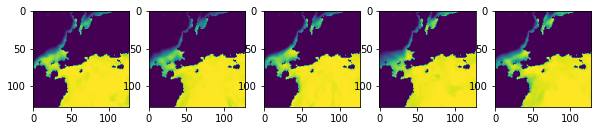

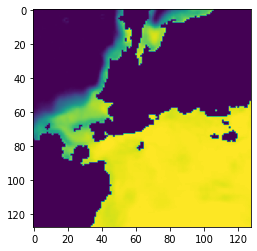

In [ ]:
i = 22
plt.figure(figsize=(10,5))
for y in range(x_train_.shape[1]):
    plt.subplot(1,window_size,y+1)
    plt.imshow(x_train_[i,y,:,:,0])
plt.show()
plt.imshow(y_train_[i,-1,:,:,0])

 - 데이터셋 만들기

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_, y_train_))
train_dataset = train_dataset.map(train_map_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((x_val_, y_val_))
val_dataset = val_dataset.map(train_map_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
next(iter(train_dataset))[0].shape, next(iter(train_dataset))[1].shape

(TensorShape([32, 5, 128, 128, 1]), TensorShape([32, 1, 128, 128, 1]))

In [ ]:
next(iter(val_dataset))[0].shape, next(iter(val_dataset))[1].shape

(TensorShape([32, 5, 128, 128, 1]), TensorShape([32, 1, 128, 128, 1]))

#5.위성 사진 전체 지역 학습  
(2) 학습
 - 1번째 학습 ( 초기 가중치를 변경하면서 2번의 학습을 수행해서 결과를 평균함 )

In [ ]:
model = makemodel()
#model.summary()

In [ ]:
#학습결과 재현을 위해 모델 초기 가중치를 저장해서 사용함

#model.save_weights(MODEL_PATH + 'model_init_20210407_1.h5')
model.load_weights(MODEL_PATH + 'model_init_20210407_1.h5')

In [ ]:
tf.keras.backend.clear_session()
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath = MODEL_PATH + model_name_1  + ".h5",
        monitor='val_loss',
        save_best_only=True
    )
]

model.fit(train_dataset, epochs=20, validation_data=val_dataset, callbacks=callbacks_list)

 - 2번째 학습

In [ ]:
model = makemodel()
#model.summary()

In [ ]:
#model.save_weights(MODEL_PATH + 'model_init_20210407_2.h5')
model.load_weights(MODEL_PATH + 'model_init_20210407_2.h5')

In [ ]:
tf.keras.backend.clear_session()
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath = MODEL_PATH + model_name_2  + ".h5",
        monitor='val_loss',
        save_best_only=True
    )
]

model.fit(train_dataset, epochs=20, validation_data=val_dataset, callbacks=callbacks_list)

#5.위성 사진 전체 지역 학습  
(3) 추론

 - 2020년 추론 데이터 전처리




In [ ]:
x_test = train_month[:,-1*window_size:,:,:,:1]
x_test = np.swapaxes(x_test , 0, 1)

x_test_ = []
for m in range(12):
    feature = []
    for i in range((x_train.shape[3]-feature_size)//stride+1):
        for j in range((x_train.shape[4]-feature_size)//stride+1):
            x_ = x_test[:, m, stride*i:stride*i+feature_size, stride*j:stride*j+feature_size, :1]/250
            feature.append(x_)
    feature = np.array(feature)
    x_test_.append(feature)
x_test_ = np.array(x_test_)

x_test_.shape

(12, 84, 5, 128, 128, 1)

 - TTS

In [ ]:
voting_mask = np.zeros((x_train.shape[-3], x_train.shape[-2]))
ones = np.ones((feature_size, feature_size))

for i in range((x_train.shape[3]-feature_size)//stride+1):
    for j in range((x_train.shape[4]-feature_size)//stride+1):
        voting_mask[stride*i:stride*i+feature_size, stride*j:stride*j+feature_size] += ones

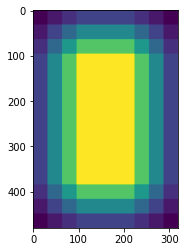

In [ ]:
plt.imshow(voting_mask)

 - 1번째 예측

In [ ]:
model = load_model(MODEL_PATH +  model_name_1  + ".h5") 

preds = []
for m in tqdm(range(12)):
    pred = model.predict(x_test_[m])
    pred = np.where(pred>250, 250, pred)
    preds.append(pred)

results_1 = []
for m in range(12):
    pred = np.zeros((x_train.shape[-3], x_train.shape[-2]))
    k = 0
    for i in range((x_train.shape[3]-feature_size)//stride+1):
        for j in range((x_train.shape[4]-feature_size)//stride+1):
            pred[stride*i:stride*i+feature_size, stride*j:stride*j+feature_size] += preds[m][k,-1,:,:,0]
            k+=1
    pred /= voting_mask
    results_1.append(pred[:MAP_ROW_SIZE, :MAP_COL_SIZE])
results_1 = np.array(results_1)    

100%|██████████| 12/12 [01:32<00:00,  7.74s/it]


 - 2번째 예측


In [ ]:
model = load_model(MODEL_PATH +  model_name_2  + ".h5")

preds = []
for m in tqdm(range(12)):
    pred = model.predict(x_test_[m])
    pred = np.where(pred>250, 250, pred)
    preds.append(pred)

results_2 = []
for m in range(12):
    pred = np.zeros((x_train.shape[-3], x_train.shape[-2]))
    k = 0
    for i in range((x_train.shape[3]-feature_size)//stride+1):
        for j in range((x_train.shape[4]-feature_size)//stride+1):
            pred[stride*i:stride*i+feature_size, stride*j:stride*j+feature_size] += preds[m][k,-1,:,:,0]
            k+=1
    pred /= voting_mask
    results_2.append(pred[:MAP_ROW_SIZE, :MAP_COL_SIZE])
results_2 = np.array(results_2) 

100%|██████████| 12/12 [01:33<00:00,  7.79s/it]


 - 데이터 결합 : 초기 가중치를 변경하여 두번 학습한 결과의 평균

In [ ]:
results_total_area = []
results_total_area = results_1 * 0.5 + results_2 * 0.5

In [ ]:
results_1.sum(), results_2.sum(), results_total_area.sum()

(40814233.77485474, 40188648.622642666, 40501441.19874871)

(40814233.77485474, 40188648.622642666, 40501441.19874871)

#5.위성 사진 전체 지역 학습  
(4) 후처리

 -  2019년 12월 Data Load

In [ ]:
train_temp = pd.read_csv(DIR_PATH + 'train_v2.csv')

#north_pole_mask from 2019 December
data_dec = np.load(DIR_TRAIN_PATH+train_temp['file_nm'][493]) 

 - 후처리 1: 북극점 미관측영역 마스크 만들기  및 적용

In [ ]:
north_pole_mask = data_dec[:, :, 1] * -1 + 1

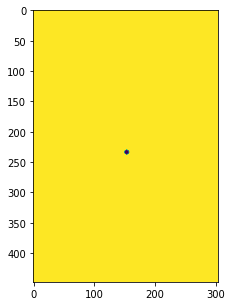

In [ ]:
plt.figure(figsize = (10,5))
tmpimg = north_pole_mask
plt.imshow(tmpimg)

In [ ]:
for m in range(12):
    results_total_area[m, : , : ] = results_total_area[m, : , : ] * north_pole_mask

 - 후처리 2: 육지 + 해안선 마스크 만들기 및 적용



In [ ]:
landmask = ((data_dec[:, :, 2] + data_dec[:, :, 3])-1)/255

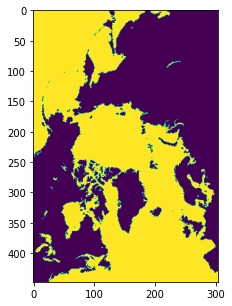

In [ ]:
plt.figure(figsize = (10,5))
tmpimg = landmask
plt.imshow(tmpimg)

In [ ]:
for m in range(12):
    results_total_area[m, : , : ] = results_total_area[m, : , : ] * landmask

In [ ]:
results_total_area.sum()

40368424.2868078

40368424.2868078

#5.위성 사진 전체 지역 학습  
(5) 추론 결과 확인

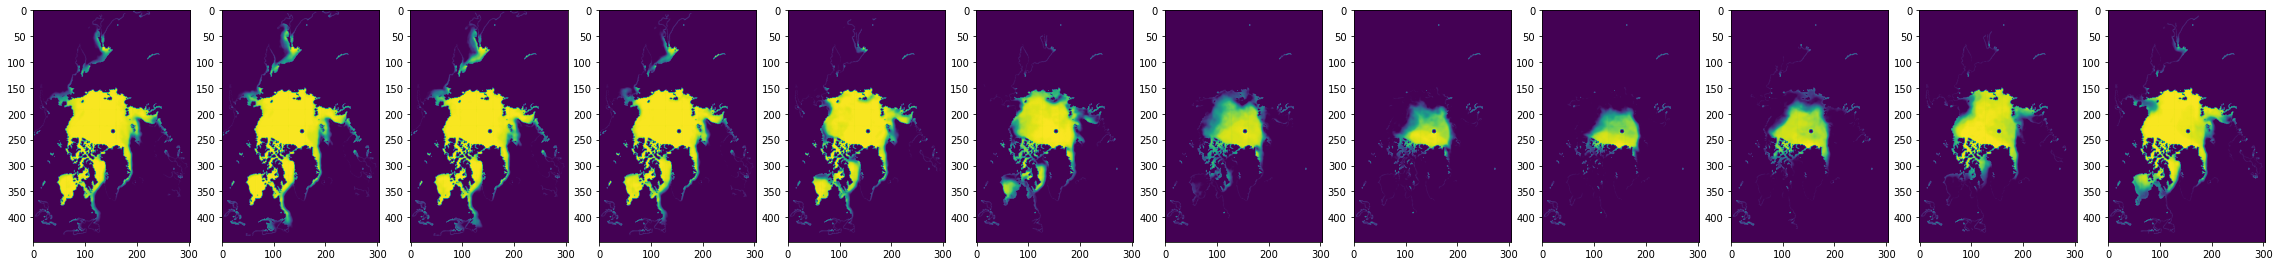

In [ ]:
fig = plt.figure(figsize =  (40, 50))
for month in range(12):
    fig.add_subplot(1, 12, month +1)
    plt.imshow(results_total_area[month]) 
fig.show()    

#5.위성 사진 전체 지역 학습  
(6) Submission 파일 저장

In [ ]:
#2019년 data load
results_2019 = []
for m in range(12): 
    data_2019 = np.load(DIR_TRAIN_PATH+train['file_nm'][482 + m])   
    results_2019.append(data_2019[:, :, 0])
results_2019 = np.array(results_2019) 

In [ ]:
results = np.append(results_2019 ,  results_total_area)
results = results.reshape(24,448, 304 )

submission_final = sample_submission.loc[:, ['month']].copy()
submission_final = pd.concat([submission_final, (pd.DataFrame(results.reshape([24,-1])))], axis=1)
submission_final.columns = sample_submission.columns

file_path =  SUBMISSION_PATH + "ConvLSTM_20210407"  + ".csv"
submission_final.to_csv(file_path, index=False, header=True)

In [ ]:
file_path

'/content/gdrive/My Drive/DACON/sea_ice/submission/ConvLSTM_20210407.csv'

#6. 결빙도 40% 기준 분할 학습  
 (1) 전처리

 - 월별 데이터로 분리

In [13]:
train_month = []
for i in range(12):
    train_month.append(train[i::12, :,:])
train_month = np.array(train_month)

train_month.shape

(12, 30, 448, 304, 5)

 -  30년간의 월별 평균 데이터 생성

In [14]:
train_monthly_mean =  np.zeros([12, MAP_ROW_SIZE, MAP_COL_SIZE])
for m in range(12):
    for i in range(MAP_ROW_SIZE):
        for j in range(MAP_COL_SIZE):
            train_monthly_mean[m][i][j] = train_month[m, :, i, j, 0].mean()

 - 평균 데이터 시각화

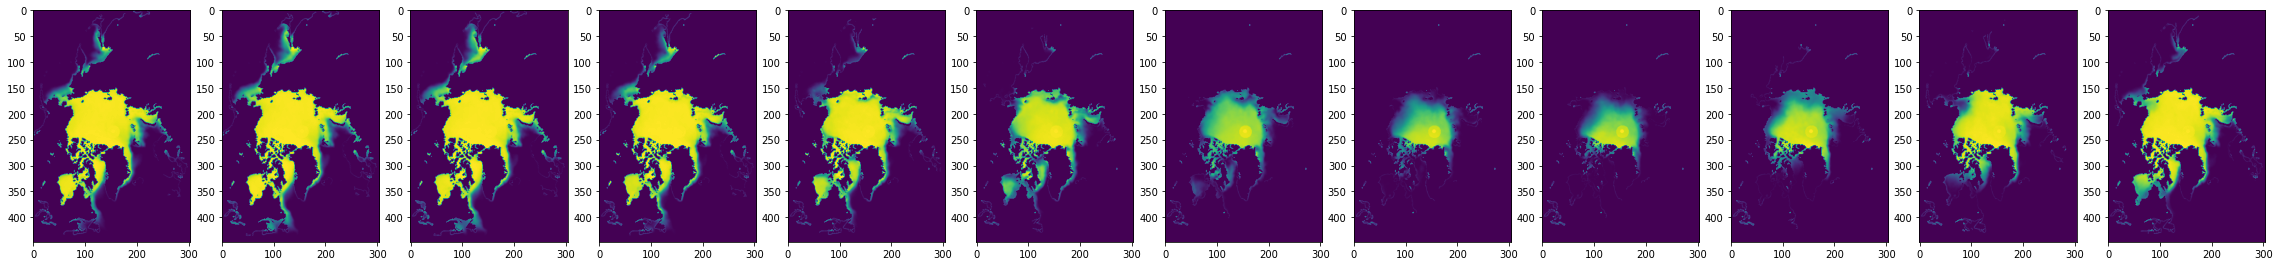

In [15]:
fig = plt.figure(figsize =  (40, 50))
for month in range(12):
    fig.add_subplot(1, 12, month +1)
    plt.imshow(train_monthly_mean[month, :, :]) 
fig.show()

 - 결빙도 40% 기준으로 두 지역으로 나누기

In [16]:
#결빙도 평균 40%(100) 이상 지역 Masking Map 생성
high_map = []
temp_map = []
  

for m in range(12): 
    temp_map = train_monthly_mean[m].flatten()
    temp_map[np.where((temp_map > 0) & (temp_map < 100))] = 0
    temp_map[np.where(temp_map >= 100)] = 1
    high_map = np.append(high_map, temp_map)

high_map = high_map.reshape(12, MAP_ROW_SIZE, MAP_COL_SIZE)

 - 결빙도 평균 40% 이상지역 Masking Map 시각화

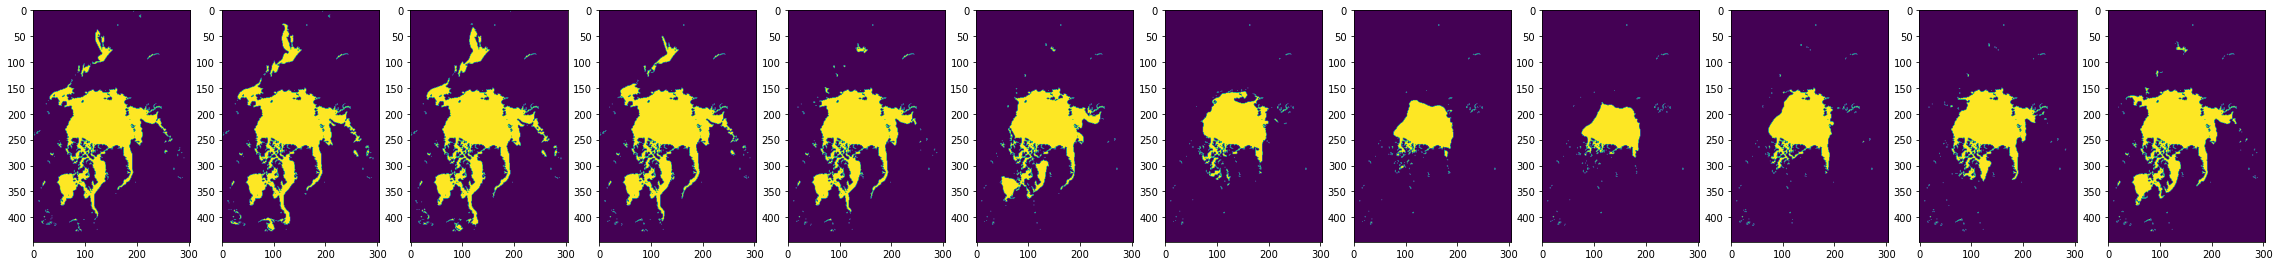

In [17]:
fig = plt.figure(figsize =  (40, 50))
for month in range(12):
    fig.add_subplot(1, 12, month +1)
    plt.imshow(high_map[month, :, :]) 
fig.show()

In [18]:
#결빙도 40%(100) 이상 지역 외 지역 Masking Map
low_map =  np.zeros([12, MAP_ROW_SIZE, MAP_COL_SIZE])
 
low_map = high_map * -1 + 1

 - 결빙도 평균 40% 미만 지역 Masking Map 시각화

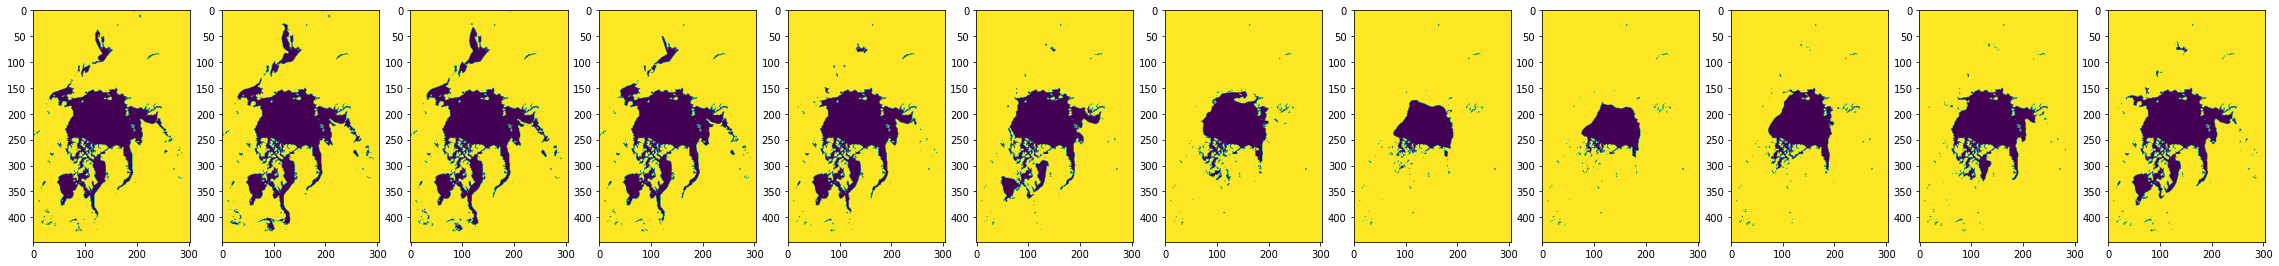

In [19]:
fig = plt.figure(figsize =  (40, 50))
for month in range(12):
    fig.add_subplot(1, 12, month +1)
    plt.imshow(low_map[month, :, :]) 
fig.show()

 - 결빙도 평균 40% 이상지역 Masking Map 적용한 2019년 data 시각화

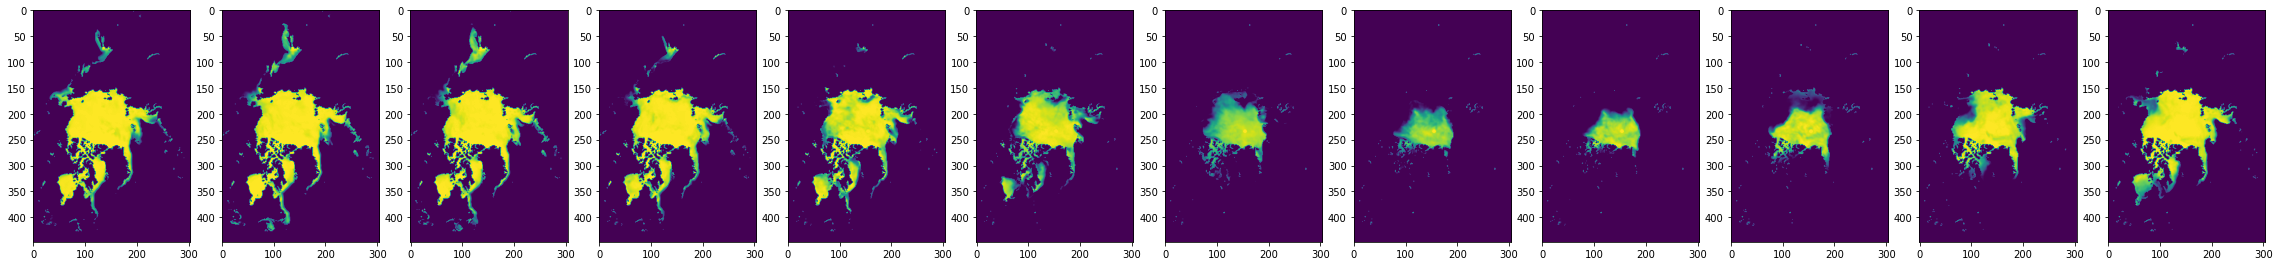

In [20]:
#high map을 적용한 2019년 data
fig = plt.figure(figsize =  (40, 50))
for month in range(12):
    fig.add_subplot(1, 12, month +1)
    plt.imshow(train_month[month,-1, :, :, 0]  * high_map[month]) 
fig.show()

 - 결빙도 평균 40% 미만지역 Masking Map 적용한 2019년 data 시각화

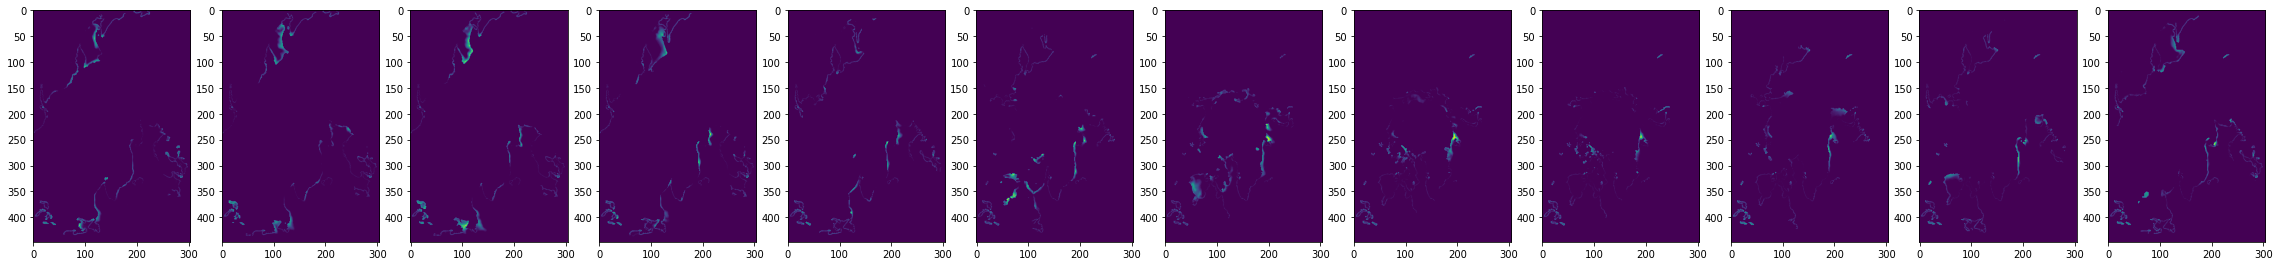

In [21]:
#low map을 적용한 2019년 data
fig = plt.figure(figsize =  (40, 50))
for month in range(12):
    fig.add_subplot(1, 12, month +1)
    plt.imshow(train_month[month,-1, :, :, 0] * low_map[month]) 
fig.show()

In [22]:
train_high_area = []
train_low_area =[]
 


for index in range(train_month.shape[1]):
    for month in range(train_month.shape[0]):
        train_high_area.append( train_month[month, index, :, :, 0] * high_map[month] )
        train_low_area.append( train_month[month, index, :, :, 0] * low_map[month] )

train_high_area = np.array(train_high_area)
train_low_area = np.array(train_low_area)

 - 결빙도 합 변화 그래프 1  
 : 결빙도 40%이상 지역에서 30년간의 결빙도 합 변화

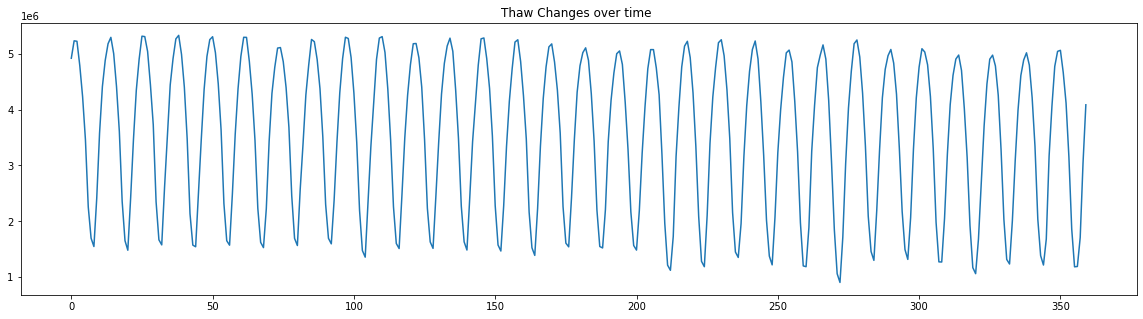

In [23]:
train_high_sum = []

train_high_sum = np.array(train_high_area.reshape(360, MAP_ROW_SIZE * MAP_COL_SIZE).sum(axis=1))
 
plt.figure(figsize = (20,5))
plt.title('Thaw Changes over time ')
plt.plot(train_high_sum)
plt.show()

 - 결빙도 합 변화 그래프 2  
 : 결빙도 40%미만 지역에서 30년간의 결빙도 합 변화

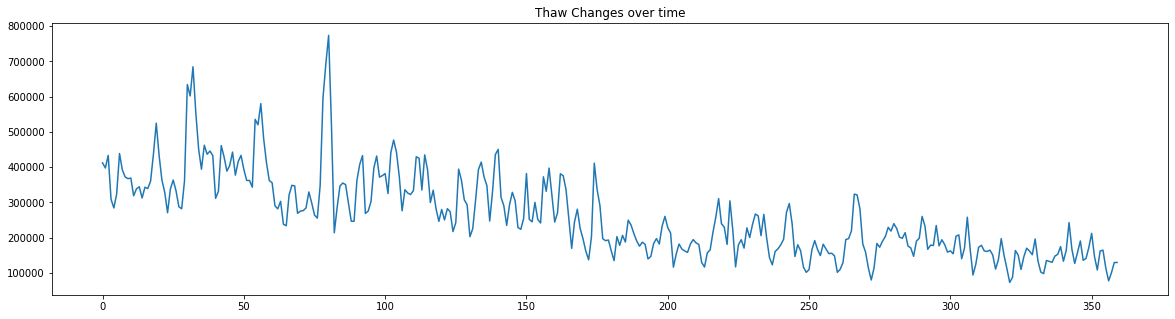

In [24]:
train_low_sum = []

train_low_sum = np.array(train_low_area.reshape(360, MAP_ROW_SIZE * MAP_COL_SIZE).sum(axis=1))
 
plt.figure(figsize = (20,5))
plt.title('Thaw Changes over time')
plt.plot(train_low_sum)
plt.show()

 - 월별 데이터로 분리

In [25]:
train_low_area = train_low_area.reshape(360, MAP_ROW_SIZE, MAP_COL_SIZE)
train_high_area = train_high_area.reshape(360, MAP_ROW_SIZE, MAP_COL_SIZE)

In [26]:
train_month_divided = []
for i in range(12):
    train_month_divided.append(train_low_area[i::12, :,:])

for i in range(12):
    train_month_divided.append(train_high_area[i::12, :,:])

train_month_divided = np.array(train_month_divided)

train.shape, train_month_divided.shape

((360, 448, 304, 5), (24, 30, 448, 304))

In [27]:
train_month_divided = train_month_divided.reshape(2, 12, 30, train_month.shape[2], train_month.shape[3] )

 - stride 크기대로 이미지를 자를 수 있도록 패딩추가

In [28]:
temp = np.zeros([train_month_divided.shape[0],
                 train_month_divided.shape[1],
                 train_month_divided.shape[2],
                 train_month_divided.shape[3]+(stride-train_month_divided.shape[3]%stride),
                 train_month_divided.shape[4]+(stride-train_month_divided.shape[4]%stride)],
                 np.uint8)
temp[:, :, :,:train_month_divided.shape[3], :train_month_divided.shape[4]] = train_month_divided
train_month_divided = temp
del temp

train_month_divided.shape

(2, 12, 30, 480, 320)

#6. 결빙도 40% 기준 분할 학습  
 (2) low 지역 학습

In [ ]:
x_train = []
y_train = []

for i in range(train_month_divided.shape[2]-window_size):
    x_train.append(train_month_divided[LOW_AREA,:, i: i+window_size,:,:])
    y_train.append(train_month_divided[LOW_AREA,:, i+window_size: i+window_size+1,:,:])

x_train = np.array(x_train)
y_train = np.array(y_train)    

In [ ]:
x_train.shape, y_train.shape

((25, 12, 5, 480, 320), (25, 12, 1, 480, 320))

 - feature size 대로 데이터 자르기

In [ ]:
x_train_ = []
y_train_ = []
for y in range(x_train.shape[0]):
    for m in range(12):
        for i in range((x_train.shape[3]-feature_size)//stride+1):
            for j in range((x_train.shape[4]-feature_size)//stride+1):
                x_ = x_train[y, m, :, stride*i:stride*i+feature_size, stride*j:stride*j+feature_size, ]
                y_ = y_train[y, m, :, stride*i:stride*i+feature_size, stride*j:stride*j+feature_size, ]
                x_train_.append(x_)
                y_train_.append(y_)

x_train_ = np.array(x_train_)
y_train_ = np.array(y_train_)

x_val_ = []
y_val_ = []

for m in range(12):
    for i in range((x_train.shape[3]-feature_size)//stride+1):
        for j in range((x_train.shape[4]-feature_size)//stride+1):
            x_ = x_train[-1, m, :, stride*i:stride*i+feature_size, stride*j:stride*j+feature_size, ]
            y_ = y_train[-1, m, :, stride*i:stride*i+feature_size, stride*j:stride*j+feature_size, ]
            x_val_.append(x_)
            y_val_.append(y_)
            
x_val_ = np.array(x_val_)
y_val_ = np.array(y_val_)

x_train_.shape, y_train_.shape, x_val_.shape, y_val_.shape

((25200, 5, 128, 128),
 (25200, 1, 128, 128),
 (1008, 5, 128, 128),
 (1008, 1, 128, 128))

 - 데이터셋 만들기

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_, y_train_))
train_dataset = train_dataset.map(train_map_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((x_val_, y_val_))
val_dataset = val_dataset.map(train_map_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
next(iter(train_dataset))[0].shape, next(iter(train_dataset))[1].shape

(TensorShape([32, 5, 128, 128]), TensorShape([32, 1, 128, 128]))

In [ ]:
next(iter(val_dataset))[0].shape, next(iter(val_dataset))[1].shape

(TensorShape([32, 5, 128, 128]), TensorShape([32, 1, 128, 128]))

 - 모델 생성

In [ ]:
model = makemodel()
#model.summary()

In [ ]:
#model.save_weights(MODEL_PATH + 'model_init_low_20210409.h5')
model.load_weights(MODEL_PATH + 'model_init_low_20210409.h5')

In [ ]:
#tf.keras.backend.clear_session()
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath = MODEL_PATH + model_name_40_1 + '.h5',
        monitor='val_loss',
        save_best_only=True
    )
]

model.fit(train_dataset, epochs=20, validation_data=val_dataset, callbacks=callbacks_list)

#6. 결빙도 40% 기준 분할 학습  
 (3) high 지역 학습

In [ ]:
x_train = []
y_train = []

for i in range(train_month_divided.shape[2]-window_size):
    x_train.append(train_month_divided[HIGH_AREA,:, i: i+window_size,:,:])
    y_train.append(train_month_divided[HIGH_AREA,:, i+window_size: i+window_size+1,:,:])

x_train = np.array(x_train)
y_train = np.array(y_train)    

 - feature size 대로 데이터 자르기

In [ ]:
x_train_ = []
y_train_ = []
for y in range(x_train.shape[0]):
    for m in range(12):
        for i in range((x_train.shape[3]-feature_size)//stride+1):
            for j in range((x_train.shape[4]-feature_size)//stride+1):
                x_ = x_train[y, m, :, stride*i:stride*i+feature_size, stride*j:stride*j+feature_size, ]
                y_ = y_train[y, m, :, stride*i:stride*i+feature_size, stride*j:stride*j+feature_size, ]
                x_train_.append(x_)
                y_train_.append(y_)

x_train_ = np.array(x_train_)
y_train_ = np.array(y_train_)

x_val_ = []
y_val_ = []

for m in range(12):
    for i in range((x_train.shape[3]-feature_size)//stride+1):
        for j in range((x_train.shape[4]-feature_size)//stride+1):
            x_ = x_train[-1, m, :, stride*i:stride*i+feature_size, stride*j:stride*j+feature_size, ]
            y_ = y_train[-1, m, :, stride*i:stride*i+feature_size, stride*j:stride*j+feature_size, ]
            x_val_.append(x_)
            y_val_.append(y_)
            
x_val_ = np.array(x_val_)
y_val_ = np.array(y_val_)

x_train_.shape, y_train_.shape, x_val_.shape, y_val_.shape

((25200, 5, 128, 128),
 (25200, 1, 128, 128),
 (1008, 5, 128, 128),
 (1008, 1, 128, 128))

 - 데이터셋 만들기

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_, y_train_))
train_dataset = train_dataset.map(train_map_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((x_val_, y_val_))
val_dataset = val_dataset.map(train_map_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
next(iter(train_dataset))[0].shape, next(iter(train_dataset))[1].shape

(TensorShape([32, 5, 128, 128]), TensorShape([32, 1, 128, 128]))

In [ ]:
next(iter(val_dataset))[0].shape, next(iter(val_dataset))[1].shape

(TensorShape([32, 5, 128, 128]), TensorShape([32, 1, 128, 128]))

 - 모델 생성

In [ ]:
model = makemodel()

In [ ]:
#model.save_weights(MODEL_PATH + 'model_init_high_20210409.h5')
model.load_weights(MODEL_PATH + 'model_init_high_20210409.h5')

 - 학습

In [ ]:
tf.keras.backend.clear_session()
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath = MODEL_PATH + model_name_40_2 + '.h5',
        monitor='val_loss',
        save_best_only=True
    )
]

model.fit(train_dataset, epochs=20, validation_data=val_dataset, callbacks=callbacks_list)

#6. 결빙도 40% 기준 분할 학습  
 (4) 추론

 - TTS

In [29]:
voting_mask = np.zeros((train_month_divided.shape[3], train_month_divided.shape[4]))
ones = np.ones((feature_size, feature_size))

for i in range((train_month_divided.shape[3]-feature_size)//stride+1):
    for j in range((train_month_divided.shape[4]-feature_size)//stride+1):
        voting_mask[stride*i:stride*i+feature_size, stride*j:stride*j+feature_size] += ones

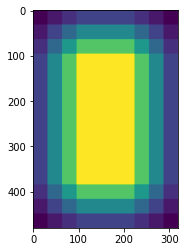

In [30]:
plt.imshow(voting_mask)

 - low 지역 추론

In [31]:
model = load_model(MODEL_PATH + model_name_40_1 + '.h5')

x_test = train_month_divided[LOW_AREA, :, -1*window_size:,:]
x_test = np.swapaxes(x_test , 0, 1)

x_test_ = []
for m in range(12):
    feature = []
    for i in range((train_month_divided.shape[3]-feature_size)//stride+1):
        for j in range((train_month_divided.shape[4]-feature_size)//stride+1):
            x_ = x_test[:, m, stride*i:stride*i+feature_size, stride*j:stride*j+feature_size]/250
            feature.append(x_)
    feature = np.array(feature)
    x_test_.append(feature)
x_test_ = np.array(x_test_)


preds = []
for m in tqdm(range(12)):
    pred = model.predict(x_test_[m])
    pred = np.where(pred>250, 250, pred)
    preds.append(pred)


results_low = []
for m in range(12):
    pred = np.zeros((train_month_divided.shape[3], train_month_divided.shape[4]))
    k = 0
    for i in range((train_month_divided.shape[3]-feature_size)//stride+1):
        for j in range((train_month_divided.shape[4]-feature_size)//stride+1):
            pred[stride*i:stride*i+feature_size, stride*j:stride*j+feature_size] += preds[m][k,-1,:,:,0]
            k+=1
    pred /= voting_mask
    results_low.append(pred[:MAP_ROW_SIZE, :MAP_COL_SIZE])
results_low = np.array(results_low)


100%|██████████| 12/12 [01:31<00:00,  7.62s/it]


 - high 지역 추론

In [32]:
model = load_model(MODEL_PATH + model_name_40_2 + '.h5')

x_test = train_month_divided[HIGH_AREA, :, -1*window_size:,:,:]
x_test = np.swapaxes(x_test , 0, 1)

x_test_ = []
for m in range(12):
    feature = []
    for i in range((train_month_divided.shape[3]-feature_size)//stride+1):
        for j in range((train_month_divided.shape[4]-feature_size)//stride+1):
            x_ = x_test[:, m, stride*i:stride*i+feature_size, stride*j:stride*j+feature_size]/250
            feature.append(x_)
    feature = np.array(feature)
    x_test_.append(feature)
x_test_ = np.array(x_test_)


preds = []
for m in tqdm(range(12)):
    pred = model.predict(x_test_[m])
    pred = np.where(pred>250, 250, pred)
    preds.append(pred)


results_high = []
for m in range(12):
    pred = np.zeros((train_month_divided.shape[3], train_month_divided.shape[4]))
    k = 0
    for i in range((train_month_divided.shape[3]-feature_size)//stride+1):
        for j in range((train_month_divided.shape[4]-feature_size)//stride+1):
            pred[stride*i:stride*i+feature_size, stride*j:stride*j+feature_size] += preds[m][k,-1,:,:,0]
            k+=1
    pred /= voting_mask
    results_high.append(pred[:MAP_ROW_SIZE, :MAP_COL_SIZE])
results_high = np.array(results_high)

100%|██████████| 12/12 [01:31<00:00,  7.66s/it]


 - LOW + HIGH 데이터 결합

In [34]:
results_area40= []
for m in range(12):
    results_area40.append(results_low[m] * low_map[m] + results_high[m] * high_map[m])
 
results_area40 = np.array(results_area40)

In [35]:
results_area40.shape

(12, 448, 304)

#6. 결빙도 40% 기준 분할 학습  
 (5) 후처리

 - 2019년 12월 Data Load

In [36]:
train = pd.read_csv(DIR_PATH + 'train_v2.csv')

#north_pole_mask from 2019 December
data_dec = np.load(DIR_TRAIN_PATH+train['file_nm'][493]) 

 - 후처리 1: 북극점 미관측영역 마스크 만들기  및 적용

In [37]:
north_pole_mask = data_dec[:, :, 1] * -1 + 1

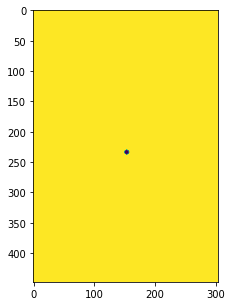

In [38]:
plt.figure(figsize = (10,5))
tmpimg = north_pole_mask
plt.imshow(tmpimg)

In [39]:
for m in range(12):
    results_area40[m, : , : ] = results_area40[m, : , : ] * north_pole_mask

 - 후처리 2: 육지 + 해안선 마스크 만들기 및 적용

In [40]:
landmask = ((data_dec[:, :, 2] + data_dec[:, :, 3])-1)/255

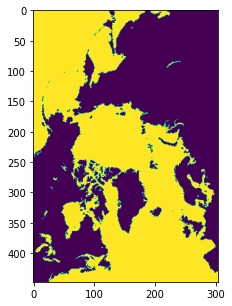

In [41]:
plt.figure(figsize = (10,5))
tmpimg = landmask
plt.imshow(tmpimg)

In [42]:
for m in range(12):
    results_area40[m, : , : ] = results_area40[m, : , : ] * landmask

#6. 결빙도 40% 기준 분할 학습  
 (6) 추론 결과 확인

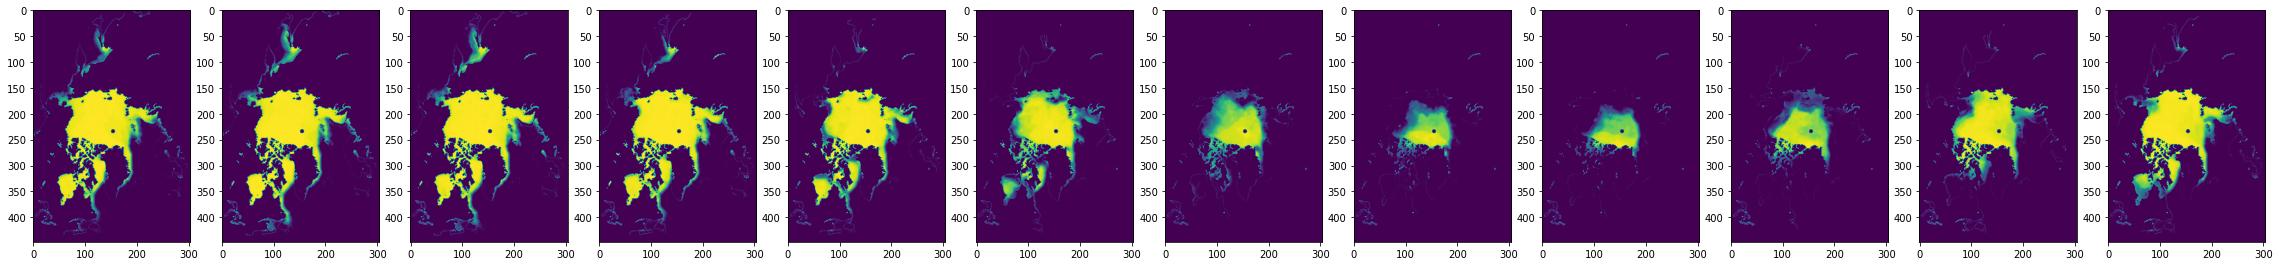

In [43]:
fig = plt.figure(figsize =  (40, 50))
for month in range(12):
    fig.add_subplot(1, 12, month +1)
    plt.imshow(results_area40[month]) 
fig.show()    

In [45]:
results_area40.shape, results_area40.sum()

((12, 448, 304), 40318018.66797465)

#6. 결빙도 40% 기준 분할 학습  
 (7) Submission 파일 저장

In [52]:
results_2019 = []
for m in range(12): 
    data_2019 = np.load(DIR_TRAIN_PATH+train['file_nm'][482 + m])   
    results_2019.append(data_2019[:, :, 0])
results_2019 = np.array(results_2019) 

In [53]:
results_final = np.append(results_2019 ,  results_area40)

In [54]:
results_final = results_final.reshape(24,448, 304 )
results_final.shape

(24, 448, 304)

In [55]:
submission_final = sample_submission.loc[:, ['month']].copy()
submission_final = pd.concat([submission_final, (pd.DataFrame(results_final.reshape([24,-1])))], axis=1)
submission_final.columns = sample_submission.columns

In [56]:
file_path =  SUBMISSION_PATH + "ConvLSTM_area40_20210409" + '.csv'
submission_final.to_csv(file_path, index=False, header=True)

# 7.결빙도 50% 기준 분할 학습  
 (1) 전처리

 - 월별 데이터로 분리

In [13]:
train_month = []
for i in range(12):
    train_month.append(train[i::12, :,:])
train_month = np.array(train_month)

train_month.shape

(12, 30, 448, 304, 5)

 -  30년간의 월별 평균 데이터 생성

In [15]:
train_monthly_mean =  np.zeros([12, MAP_ROW_SIZE, MAP_COL_SIZE])
for m in range(12):
    for i in range(MAP_ROW_SIZE):
        for j in range(MAP_COL_SIZE):
            train_monthly_mean[m][i][j] = train_month[m, :, i, j, 0].mean()



 - 결빙도 기준으로 두 지역으로 나누기

In [16]:
#결빙도 평균 50%(125) 이상 지역 Masking Map 생성
high_map = []
temp_map = []
  

for m in range(12): 
    temp_map = train_monthly_mean[m].flatten()
    temp_map[np.where((temp_map > 0) & (temp_map < 125))] = 0
    temp_map[np.where(temp_map >= 125)] = 1
    high_map = np.append(high_map, temp_map)

high_map = high_map.reshape(12, MAP_ROW_SIZE, MAP_COL_SIZE)


 - 결빙도 평균 50% 이상지역 Masking Map 시각화

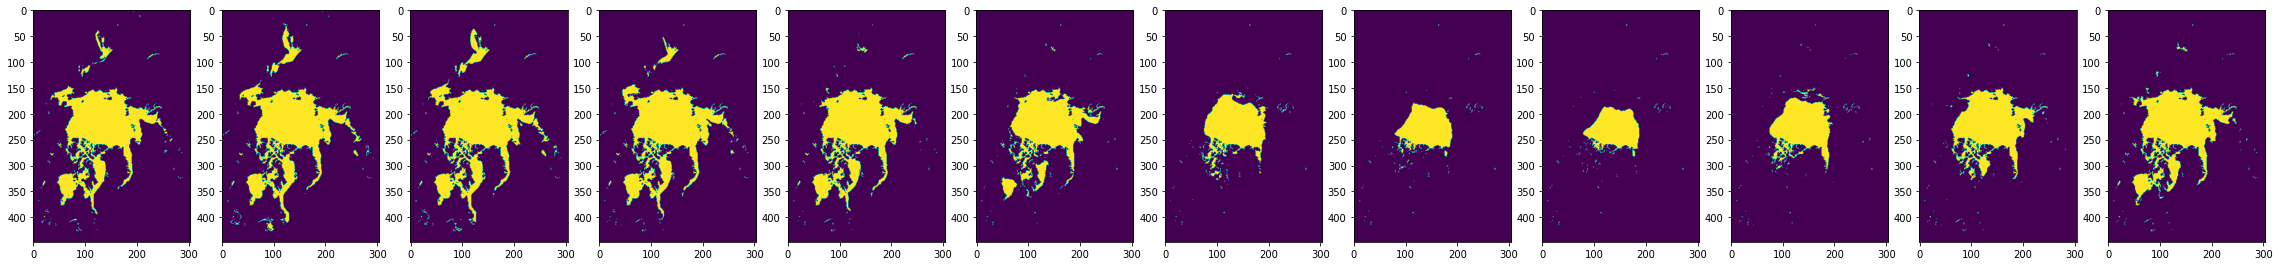

In [17]:
fig = plt.figure(figsize =  (40, 50))
for month in range(12):
    fig.add_subplot(1, 12, month +1)
    plt.imshow(high_map[month, :, :]) 
fig.show()

In [18]:
#결빙도 50%(125) 이상 지역 외 지역 Masking Map
low_map =  np.zeros([12, MAP_ROW_SIZE, MAP_COL_SIZE])
 
low_map = high_map * -1 + 1

 - 결빙도 평균 50% 미만 지역 Masking Map 시각화

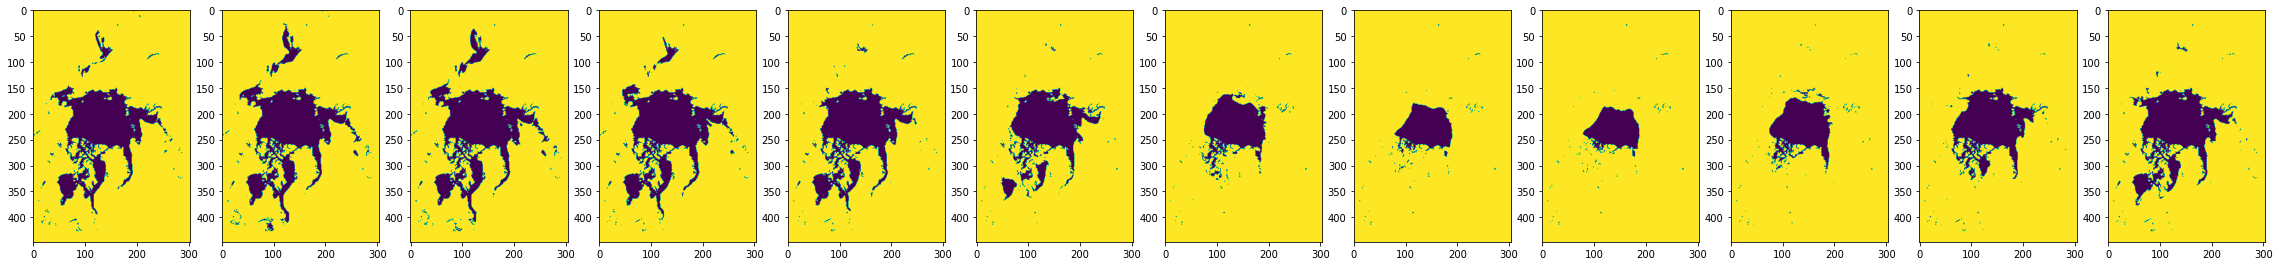

In [19]:
fig = plt.figure(figsize =  (40, 50))
for month in range(12):
    fig.add_subplot(1, 12, month +1)
    plt.imshow(low_map[month, :, :]) 
fig.show()

 - 결빙도 평균 50% 이상지역 Masking Map 적용한 2019년 data 시각화

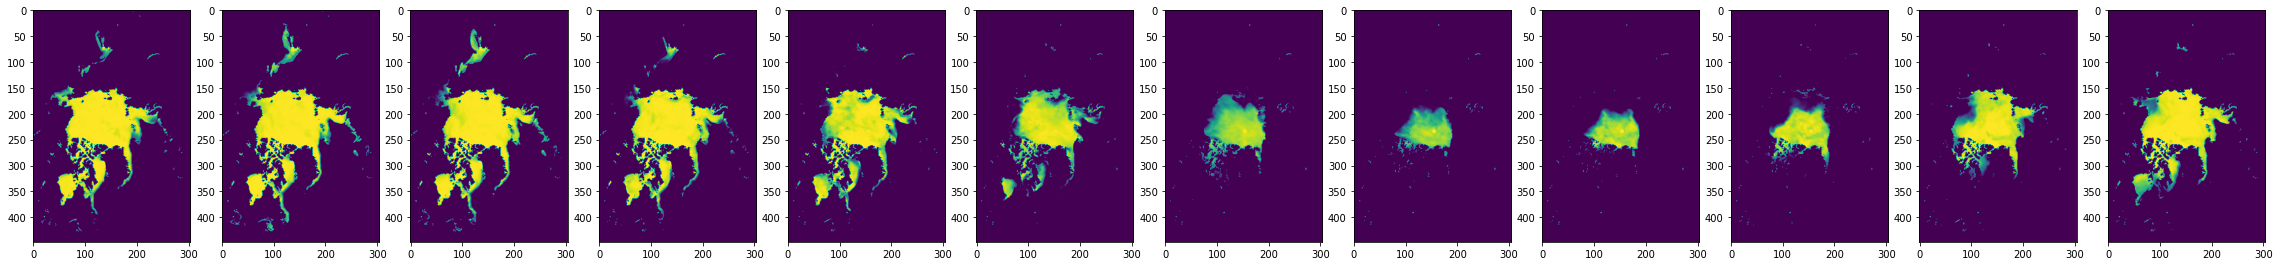

In [21]:
#high map을 적용한 2019년 data
fig = plt.figure(figsize =  (40, 50))
for month in range(12):
    fig.add_subplot(1, 12, month +1)
    plt.imshow(train_month[month,-1, :, :, 0]  * high_map[month]) 
fig.show()

 - 결빙도 평균 50% 미만지역 Masking Map 적용한 2019년 data 시각화

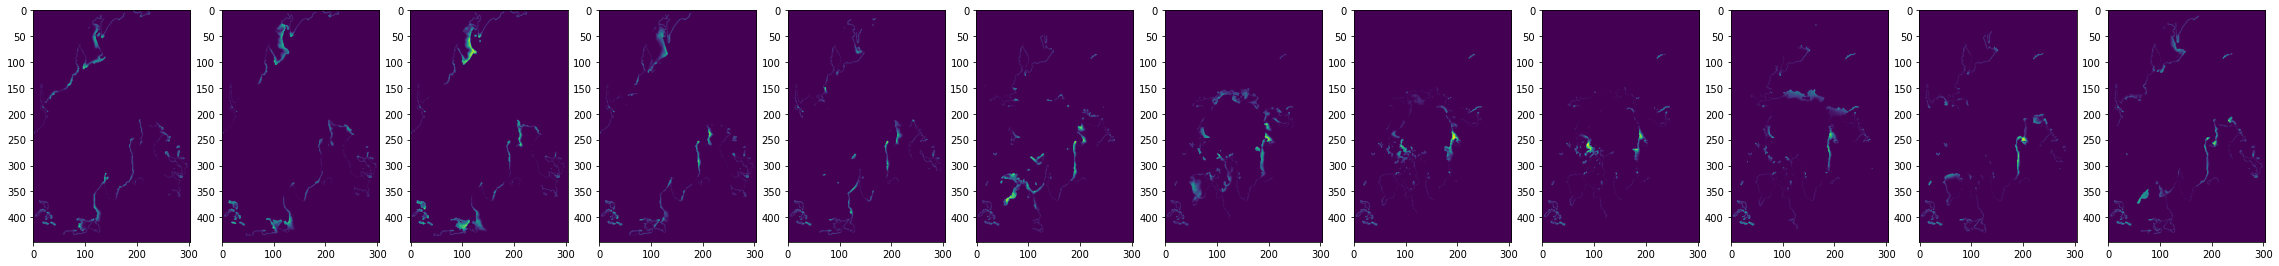

In [23]:
#low map을 적용한 2019년 data
fig = plt.figure(figsize =  (40, 50))
for month in range(12):
    fig.add_subplot(1, 12, month +1)
    plt.imshow(train_month[month,-1, :, :, 0] * low_map[month]) 
fig.show()

In [26]:
train_high_area = []
train_low_area =[]
 


for index in range(train_month.shape[1]):
    for month in range(train_month.shape[0]):
        train_high_area.append( train_month[month, index, :, :, 0] * high_map[month] )
        train_low_area.append( train_month[month, index, :, :, 0] * low_map[month] )

train_high_area = np.array(train_high_area)
train_low_area = np.array(train_low_area)

train_high_area.shape, train_low_area.shape

((360, 448, 304), (360, 448, 304))

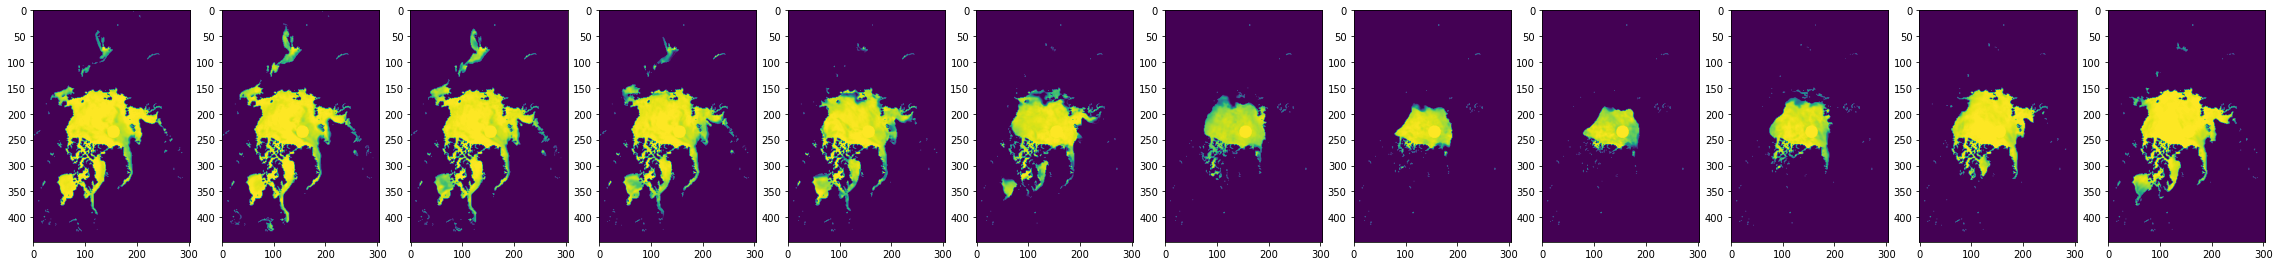

In [27]:
train_high_area = train_high_area.reshape(30, 12,MAP_ROW_SIZE, MAP_COL_SIZE)
 
index = 0
fig = plt.figure(figsize =  (40, 50))
for month in range(12):
    fig.add_subplot(1, 12, month +1)
    plt.imshow(train_high_area[index,month, :, :]) 
fig.show()

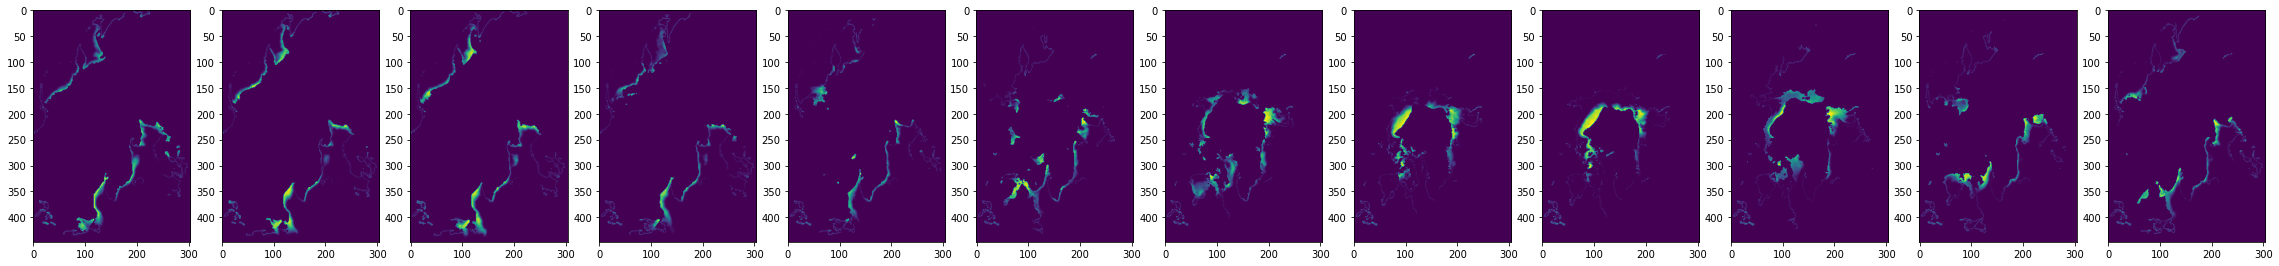

In [28]:
train_low_area = train_low_area.reshape(30, 12,MAP_ROW_SIZE, MAP_COL_SIZE)
 
index = 0
fig = plt.figure(figsize =  (40, 50))
for month in range(12):
    fig.add_subplot(1, 12, month +1)
    plt.imshow(train_low_area[index,month, :, :]) 
fig.show()
 

 - 결빙도 50%이상 지역의 결빙도 합 변화 그래프

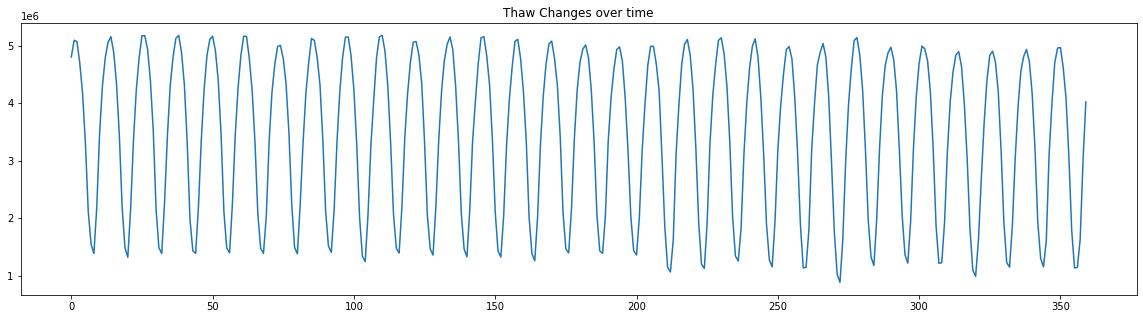

In [31]:
train_high_sum = []

train_high_sum = np.array(train_high_area.reshape(360, MAP_ROW_SIZE * MAP_COL_SIZE).sum(axis=1))
 
plt.figure(figsize = (20,5))
plt.title('Thaw Changes over time')
plt.plot(train_high_sum)
plt.show()

  - 결빙도 50%미만 지역의 결빙도 합 변화 그래프

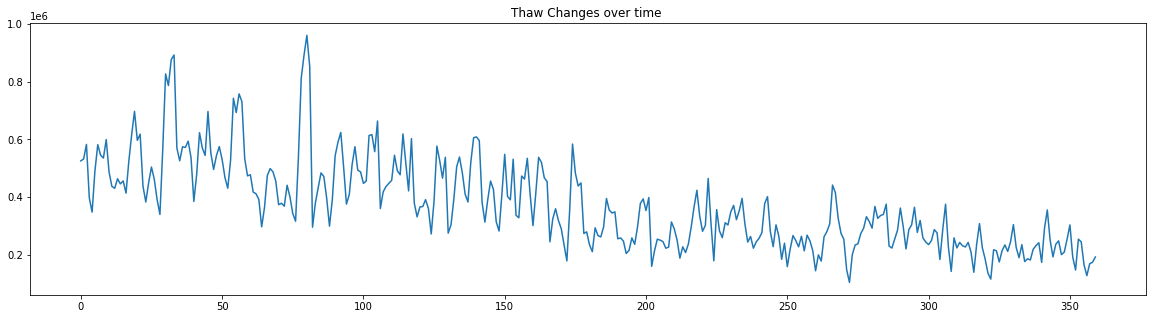

In [32]:
train_low_sum = []

train_low_sum = np.array(train_low_area.reshape(360, MAP_ROW_SIZE * MAP_COL_SIZE).sum(axis=1))
 
plt.figure(figsize = (20,5))
plt.title('Thaw Changes over time ')
plt.plot(train_low_sum)
plt.show()

 - 월별 데이터로 분리

In [33]:
train_low_area = train_low_area.reshape(360, MAP_ROW_SIZE, MAP_COL_SIZE)
train_high_area = train_high_area.reshape(360, MAP_ROW_SIZE, MAP_COL_SIZE)

In [36]:
train_month_divided = []
for i in range(12):
    train_month_divided.append(train_low_area[i::12, :,:])

for i in range(12):
    train_month_divided.append(train_high_area[i::12, :,:])

train_month_divided = np.array(train_month_divided)

In [38]:
train.shape, train_month_divided.shape

((360, 448, 304, 5), (24, 30, 448, 304))

In [39]:
train_month_divided = train_month_divided.reshape(2, 12, 30, train_month_divided.shape[2], train_month_divided.shape[3] )

 - stride 크기대로 이미지를 자를 수 있도록 패딩추가

In [41]:
temp = np.zeros([train_month_divided.shape[0],
                 train_month_divided.shape[1],
                 train_month_divided.shape[2],
                 train_month_divided.shape[3]+(stride-train_month_divided.shape[3]%stride),
                 train_month_divided.shape[4]+(stride-train_month_divided.shape[4]%stride)],
                 np.uint8)
temp[:, :, :,:train_month_divided.shape[3], :train_month_divided.shape[4]] = train_month_divided
train_month_divided = temp
del temp

In [42]:
train_month_divided.shape

(2, 12, 30, 480, 320)

# 7.결빙도 50% 기준 분할 학습  
 (2) low 지역 학습

In [43]:
x_train = []
y_train = []

for i in range(train_month_divided.shape[2]-window_size):
    x_train.append(train_month_divided[LOW_AREA,:, i: i+window_size,:,:])
    y_train.append(train_month_divided[LOW_AREA,:, i+window_size: i+window_size+1,:,:])

x_train = np.array(x_train)
y_train = np.array(y_train)    

 - feature size 대로 데이터 자르기

In [44]:
x_train_ = []
y_train_ = []
for y in range(x_train.shape[0]):
    for m in range(12):
        for i in range((x_train.shape[3]-feature_size)//stride+1):
            for j in range((x_train.shape[4]-feature_size)//stride+1):
                x_ = x_train[y, m, :, stride*i:stride*i+feature_size, stride*j:stride*j+feature_size, ]
                y_ = y_train[y, m, :, stride*i:stride*i+feature_size, stride*j:stride*j+feature_size, ]
                x_train_.append(x_)
                y_train_.append(y_)

x_train_ = np.array(x_train_)
y_train_ = np.array(y_train_)

x_val_ = []
y_val_ = []

for m in range(12):
    for i in range((x_train.shape[3]-feature_size)//stride+1):
        for j in range((x_train.shape[4]-feature_size)//stride+1):
            x_ = x_train[-1, m, :, stride*i:stride*i+feature_size, stride*j:stride*j+feature_size, ]
            y_ = y_train[-1, m, :, stride*i:stride*i+feature_size, stride*j:stride*j+feature_size, ]
            x_val_.append(x_)
            y_val_.append(y_)
            
x_val_ = np.array(x_val_)
y_val_ = np.array(y_val_)

x_train_.shape, y_train_.shape, x_val_.shape, y_val_.shape

((25200, 5, 128, 128),
 (25200, 1, 128, 128),
 (1008, 5, 128, 128),
 (1008, 1, 128, 128))

 - 데이터셋 만들기

In [45]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_, y_train_))
train_dataset = train_dataset.map(train_map_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((x_val_, y_val_))
val_dataset = val_dataset.map(train_map_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [46]:
next(iter(train_dataset))[0].shape, next(iter(train_dataset))[1].shape

(TensorShape([32, 5, 128, 128]), TensorShape([32, 1, 128, 128]))

In [47]:
next(iter(val_dataset))[0].shape, next(iter(val_dataset))[1].shape

(TensorShape([32, 5, 128, 128]), TensorShape([32, 1, 128, 128]))

 - 모델 생성

In [48]:
model = makemodel()
#model.summary()

In [49]:
#model.save_weights(MODEL_PATH + 'model_init_low_20210409.h5')
model.load_weights(MODEL_PATH + 'model_init_low_20210409.h5')

 - 학습

In [ ]:
#tf.keras.backend.clear_session()
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath = MODEL_PATH + model_name_50_1 + '.h5',
        monitor='val_loss',
        save_best_only=True
    )
]

model.fit(train_dataset, epochs=20, validation_data=val_dataset, callbacks=callbacks_list)

# 7.결빙도 50% 기준 분할 학습  
 (3) high 지역 학습

In [50]:
x_train = []
y_train = []

for i in range(train_month_divided.shape[2]-window_size):
    x_train.append(train_month_divided[HIGH_AREA,:, i: i+window_size,:,:])
    y_train.append(train_month_divided[HIGH_AREA,:, i+window_size: i+window_size+1,:,:])

x_train = np.array(x_train)
y_train = np.array(y_train)    

 - feature size 대로 데이터 자르기

In [51]:
x_train_ = []
y_train_ = []
for y in range(x_train.shape[0]):
    for m in range(12):
        for i in range((x_train.shape[3]-feature_size)//stride+1):
            for j in range((x_train.shape[4]-feature_size)//stride+1):
                x_ = x_train[y, m, :, stride*i:stride*i+feature_size, stride*j:stride*j+feature_size, ]
                y_ = y_train[y, m, :, stride*i:stride*i+feature_size, stride*j:stride*j+feature_size, ]
                x_train_.append(x_)
                y_train_.append(y_)

x_train_ = np.array(x_train_)
y_train_ = np.array(y_train_)

x_val_ = []
y_val_ = []

for m in range(12):
    for i in range((x_train.shape[3]-feature_size)//stride+1):
        for j in range((x_train.shape[4]-feature_size)//stride+1):
            x_ = x_train[-1, m, :, stride*i:stride*i+feature_size, stride*j:stride*j+feature_size, ]
            y_ = y_train[-1, m, :, stride*i:stride*i+feature_size, stride*j:stride*j+feature_size, ]
            x_val_.append(x_)
            y_val_.append(y_)
            
x_val_ = np.array(x_val_)
y_val_ = np.array(y_val_)

x_train_.shape, y_train_.shape, x_val_.shape, y_val_.shape

((25200, 5, 128, 128),
 (25200, 1, 128, 128),
 (1008, 5, 128, 128),
 (1008, 1, 128, 128))

 - 데이터셋 만들기

In [52]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_, y_train_))
train_dataset = train_dataset.map(train_map_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((x_val_, y_val_))
val_dataset = val_dataset.map(train_map_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [53]:
next(iter(train_dataset))[0].shape, next(iter(train_dataset))[1].shape

(TensorShape([32, 5, 128, 128]), TensorShape([32, 1, 128, 128]))

In [54]:
next(iter(val_dataset))[0].shape, next(iter(val_dataset))[1].shape

(TensorShape([32, 5, 128, 128]), TensorShape([32, 1, 128, 128]))

 - 모델 생성

In [55]:
model = makemodel()

In [56]:
#model.save_weights(MODEL_PATH + 'model_init_20210316.h5')
model.load_weights(MODEL_PATH + 'model_init_high_20210409.h5')

In [ ]:
tf.keras.backend.clear_session()
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath = MODEL_PATH + model_name_50_2 + '.h5',
        monitor='val_loss',
        save_best_only=True
    )
]

model.fit(train_dataset, epochs=20, validation_data=val_dataset, callbacks=callbacks_list)

# 7.결빙도 50% 기준 분할 학습  
 (4) 추론

 - TTS

In [58]:
voting_mask = np.zeros((train_month_divided.shape[3], train_month_divided.shape[4]))
ones = np.ones((feature_size, feature_size))

for i in range((train_month_divided.shape[3]-feature_size)//stride+1):
    for j in range((train_month_divided.shape[4]-feature_size)//stride+1):
        voting_mask[stride*i:stride*i+feature_size, stride*j:stride*j+feature_size] += ones

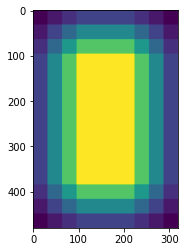

In [59]:
plt.imshow(voting_mask)

 - low 지역 추론

In [61]:
model = load_model(MODEL_PATH + model_name_50_1 + '.h5')

x_test = train_month_divided[LOW_AREA, :, -1*window_size:,:]
x_test = np.swapaxes(x_test , 0, 1)

x_test_ = []
for m in range(12):
    feature = []
    for i in range((train_month_divided.shape[3]-feature_size)//stride+1):
        for j in range((train_month_divided.shape[4]-feature_size)//stride+1):
            x_ = x_test[:, m, stride*i:stride*i+feature_size, stride*j:stride*j+feature_size]/250
            feature.append(x_)
    feature = np.array(feature)
    x_test_.append(feature)
x_test_ = np.array(x_test_)


preds = []
for m in tqdm(range(12)):
    pred = model.predict(x_test_[m])
    pred = np.where(pred>250, 250, pred)
    preds.append(pred)


results_low = []
for m in range(12):
    pred = np.zeros((train_month_divided.shape[3], train_month_divided.shape[4]))
    k = 0
    for i in range((train_month_divided.shape[3]-feature_size)//stride+1):
        for j in range((train_month_divided.shape[4]-feature_size)//stride+1):
            pred[stride*i:stride*i+feature_size, stride*j:stride*j+feature_size] += preds[m][k,-1,:,:,0]
            k+=1
    pred /= voting_mask
    results_low.append(pred[:MAP_ROW_SIZE, :MAP_COL_SIZE])
results_low = np.array(results_low)


100%|██████████| 12/12 [01:30<00:00,  7.58s/it]


 - high 지역 추론

In [62]:
model = load_model(MODEL_PATH + model_name_50_2 + '.h5')

x_test = train_month_divided[HIGH_AREA, :, -1*window_size:,:,:]
x_test = np.swapaxes(x_test , 0, 1)

x_test_ = []
for m in range(12):
    feature = []
    for i in range((train_month_divided.shape[3]-feature_size)//stride+1):
        for j in range((train_month_divided.shape[4]-feature_size)//stride+1):
            x_ = x_test[:, m, stride*i:stride*i+feature_size, stride*j:stride*j+feature_size]/250
            feature.append(x_)
    feature = np.array(feature)
    x_test_.append(feature)
x_test_ = np.array(x_test_)


preds = []
for m in tqdm(range(12)):
    pred = model.predict(x_test_[m])
    pred = np.where(pred>250, 250, pred)
    preds.append(pred)


results_high = []
for m in range(12):
    pred = np.zeros((train_month_divided.shape[3], train_month_divided.shape[4]))
    k = 0
    for i in range((train_month_divided.shape[3]-feature_size)//stride+1):
        for j in range((train_month_divided.shape[4]-feature_size)//stride+1):
            pred[stride*i:stride*i+feature_size, stride*j:stride*j+feature_size] += preds[m][k,-1,:,:,0]
            k+=1
    pred /= voting_mask
    results_high.append(pred[:MAP_ROW_SIZE, :MAP_COL_SIZE])
results_high = np.array(results_high)

100%|██████████| 12/12 [01:32<00:00,  7.74s/it]


 - LOW + HIGH 데이터 결합

In [63]:
results_area50 = []
for m in range(12):
    results_area50.append(results_low[m] * low_map[m] + results_high[m] * high_map[m])
 
results_area50 = np.array(results_area50)

results_area50.shape

(12, 448, 304)

# 7.결빙도 50% 기준 분할 학습  
 (5) 후처리

 - 2019년 12월 Data Load

In [64]:
train = pd.read_csv(DIR_PATH + 'train_v2.csv')

#north_pole_mask from 2019 December
data_dec = np.load(DIR_TRAIN_PATH+train['file_nm'][493]) 

 - 후처리 1: 북극점 미관측영역 마스크 만들기  및 적용

In [65]:
north_pole_mask = data_dec[:, :, 1] * -1 + 1

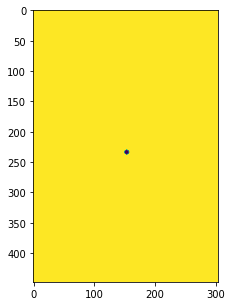

In [66]:
plt.figure(figsize = (10,5))
tmpimg = north_pole_mask
plt.imshow(tmpimg)

In [67]:
for m in range(12):
    results_area50[m, : , : ] = results_area50[m, : , : ] * north_pole_mask

 - 후처리 2: 육지 + 해안선 마스크 만들기 및 적용

In [68]:
landmask = ((data_dec[:, :, 2] + data_dec[:, :, 3])-1)/255

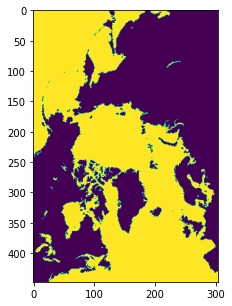

In [69]:
plt.figure(figsize = (10,5))
tmpimg = landmask
plt.imshow(tmpimg)

In [70]:
for m in range(12):
    results_area50[m, : , : ] = results_area50[m, : , : ] * landmask

# 7.결빙도 50% 기준 분할 학습  
 (6) 추론 결과 확인

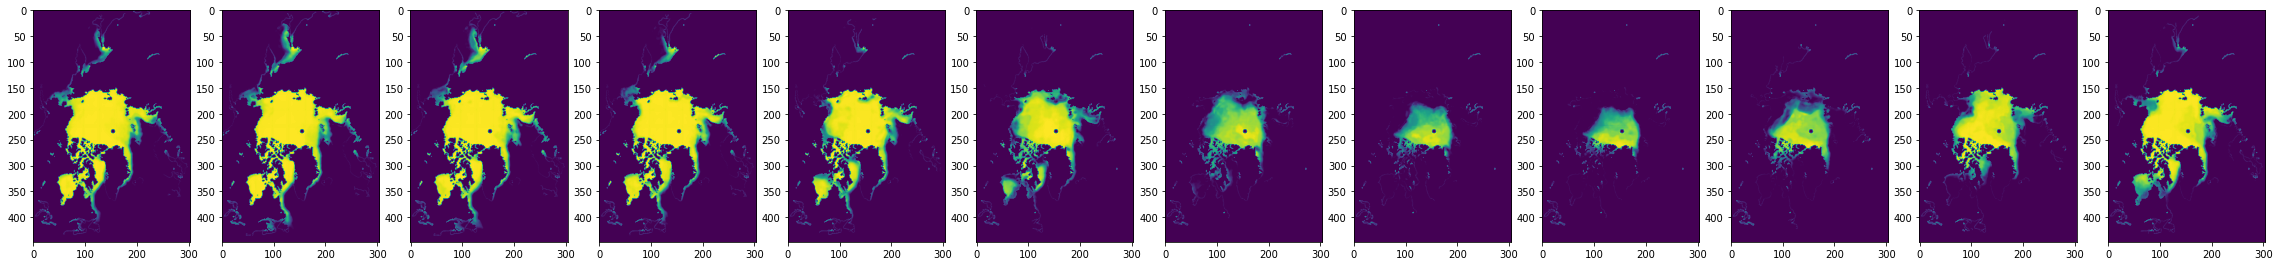

In [71]:
fig = plt.figure(figsize =  (40, 50))
for month in range(12):
    fig.add_subplot(1, 12, month +1)
    plt.imshow(results_area50[month]) 
fig.show()    

In [72]:
results_area50.shape, results_area50.sum()

((12, 448, 304), 40330452.37729045)

# 7.결빙도 50% 기준 분할 학습  
 (7) Submission 파일 저장

In [74]:
results_2019 = []
for m in range(12): 
    data_2019 = np.load(DIR_TRAIN_PATH+train['file_nm'][482 + m])   
    results_2019.append(data_2019[:, :, 0])
results_2019 = np.array(results_2019) 

In [75]:
results_final = np.append(results_2019 ,  results_area50)

In [76]:
results_final = results_final.reshape(24,448, 304 )
results_final.shape

(24, 448, 304)

In [77]:
submission_final = sample_submission.loc[:, ['month']].copy()
submission_final = pd.concat([submission_final, (pd.DataFrame(results_final.reshape([24,-1])))], axis=1)
submission_final.columns = sample_submission.columns

In [78]:
file_path =  SUBMISSION_PATH + "ConvLSTM_area50_20210409" + '.csv'
submission_final.to_csv(file_path, index=False, header=True)

#8. Ensenble

 -  (결빙도 40% 기준 분할 학습 x 0.5 + 결빙도 50% 기준 분할 학습 x 0.5) x 0.5 + (위성사진 전체 지역 학습 x 0.5)

In [13]:
submission_area1 = pd.read_csv(SUBMISSION_PATH+'ConvLSTM_area40_20210409.csv')
submission_area2 = pd.read_csv(SUBMISSION_PATH+'ConvLSTM_area50_20210409.csv')

submission_area1.shape, submission_area2.shape

((24, 136193), (24, 136193))

In [14]:
np_sub1 = np.array(submission_area1)
np_sub2 = np.array(submission_area2)

np_sub1  = np_sub1[:24, 1:]
np_sub2 = np_sub2[:24, 1:]


np_sub1.shape, np_sub2.shape

((24, 136192), (24, 136192))

In [15]:
results_area = np_sub1 * 0.5 + np_sub2 * 0.5

results_area.sum(), np_sub1.sum(), np_sub2.sum()

(81735614.52263233, 81729397.66797447, 81741831.3772907)

In [16]:
submission_2 = pd.read_csv(SUBMISSION_PATH+'ConvLSTM_20210407.csv')

In [17]:
np_sub1 = np.array(results_area)
np_sub2 = np.array(submission_2)
np_sub2 = np_sub2[:24, 1:]

np_sub1.shape, np_sub2.shape

((24, 136192), (24, 136192))

In [18]:
results_final = np_sub1 * 0.5 + np_sub2 * 0.5

results_final.sum(), np_sub1.sum(), np_sub2.sum()

(81757708.90472071, 81735614.52263233, 81779803.28680831)

In [19]:
submission_final = sample_submission.loc[:, ['month']].copy()
submission_final = pd.concat([submission_final, (pd.DataFrame(results_final.reshape([24,-1])))], axis=1)
submission_final.columns = sample_submission.columns

In [20]:
file_path =  SUBMISSION_PATH + "Ensenble20210411" + ".csv"
submission_final.to_csv(file_path, index=False, header=True)

 - 최종 예측 결과 시각화

In [ ]:
fig = plt.figure(figsize =  (40, 50))
for month in range(12):
    fig.add_subplot(1, 12, month +1)
    plt.imshow(results_area50[month]) 
fig.show()  

1 month 



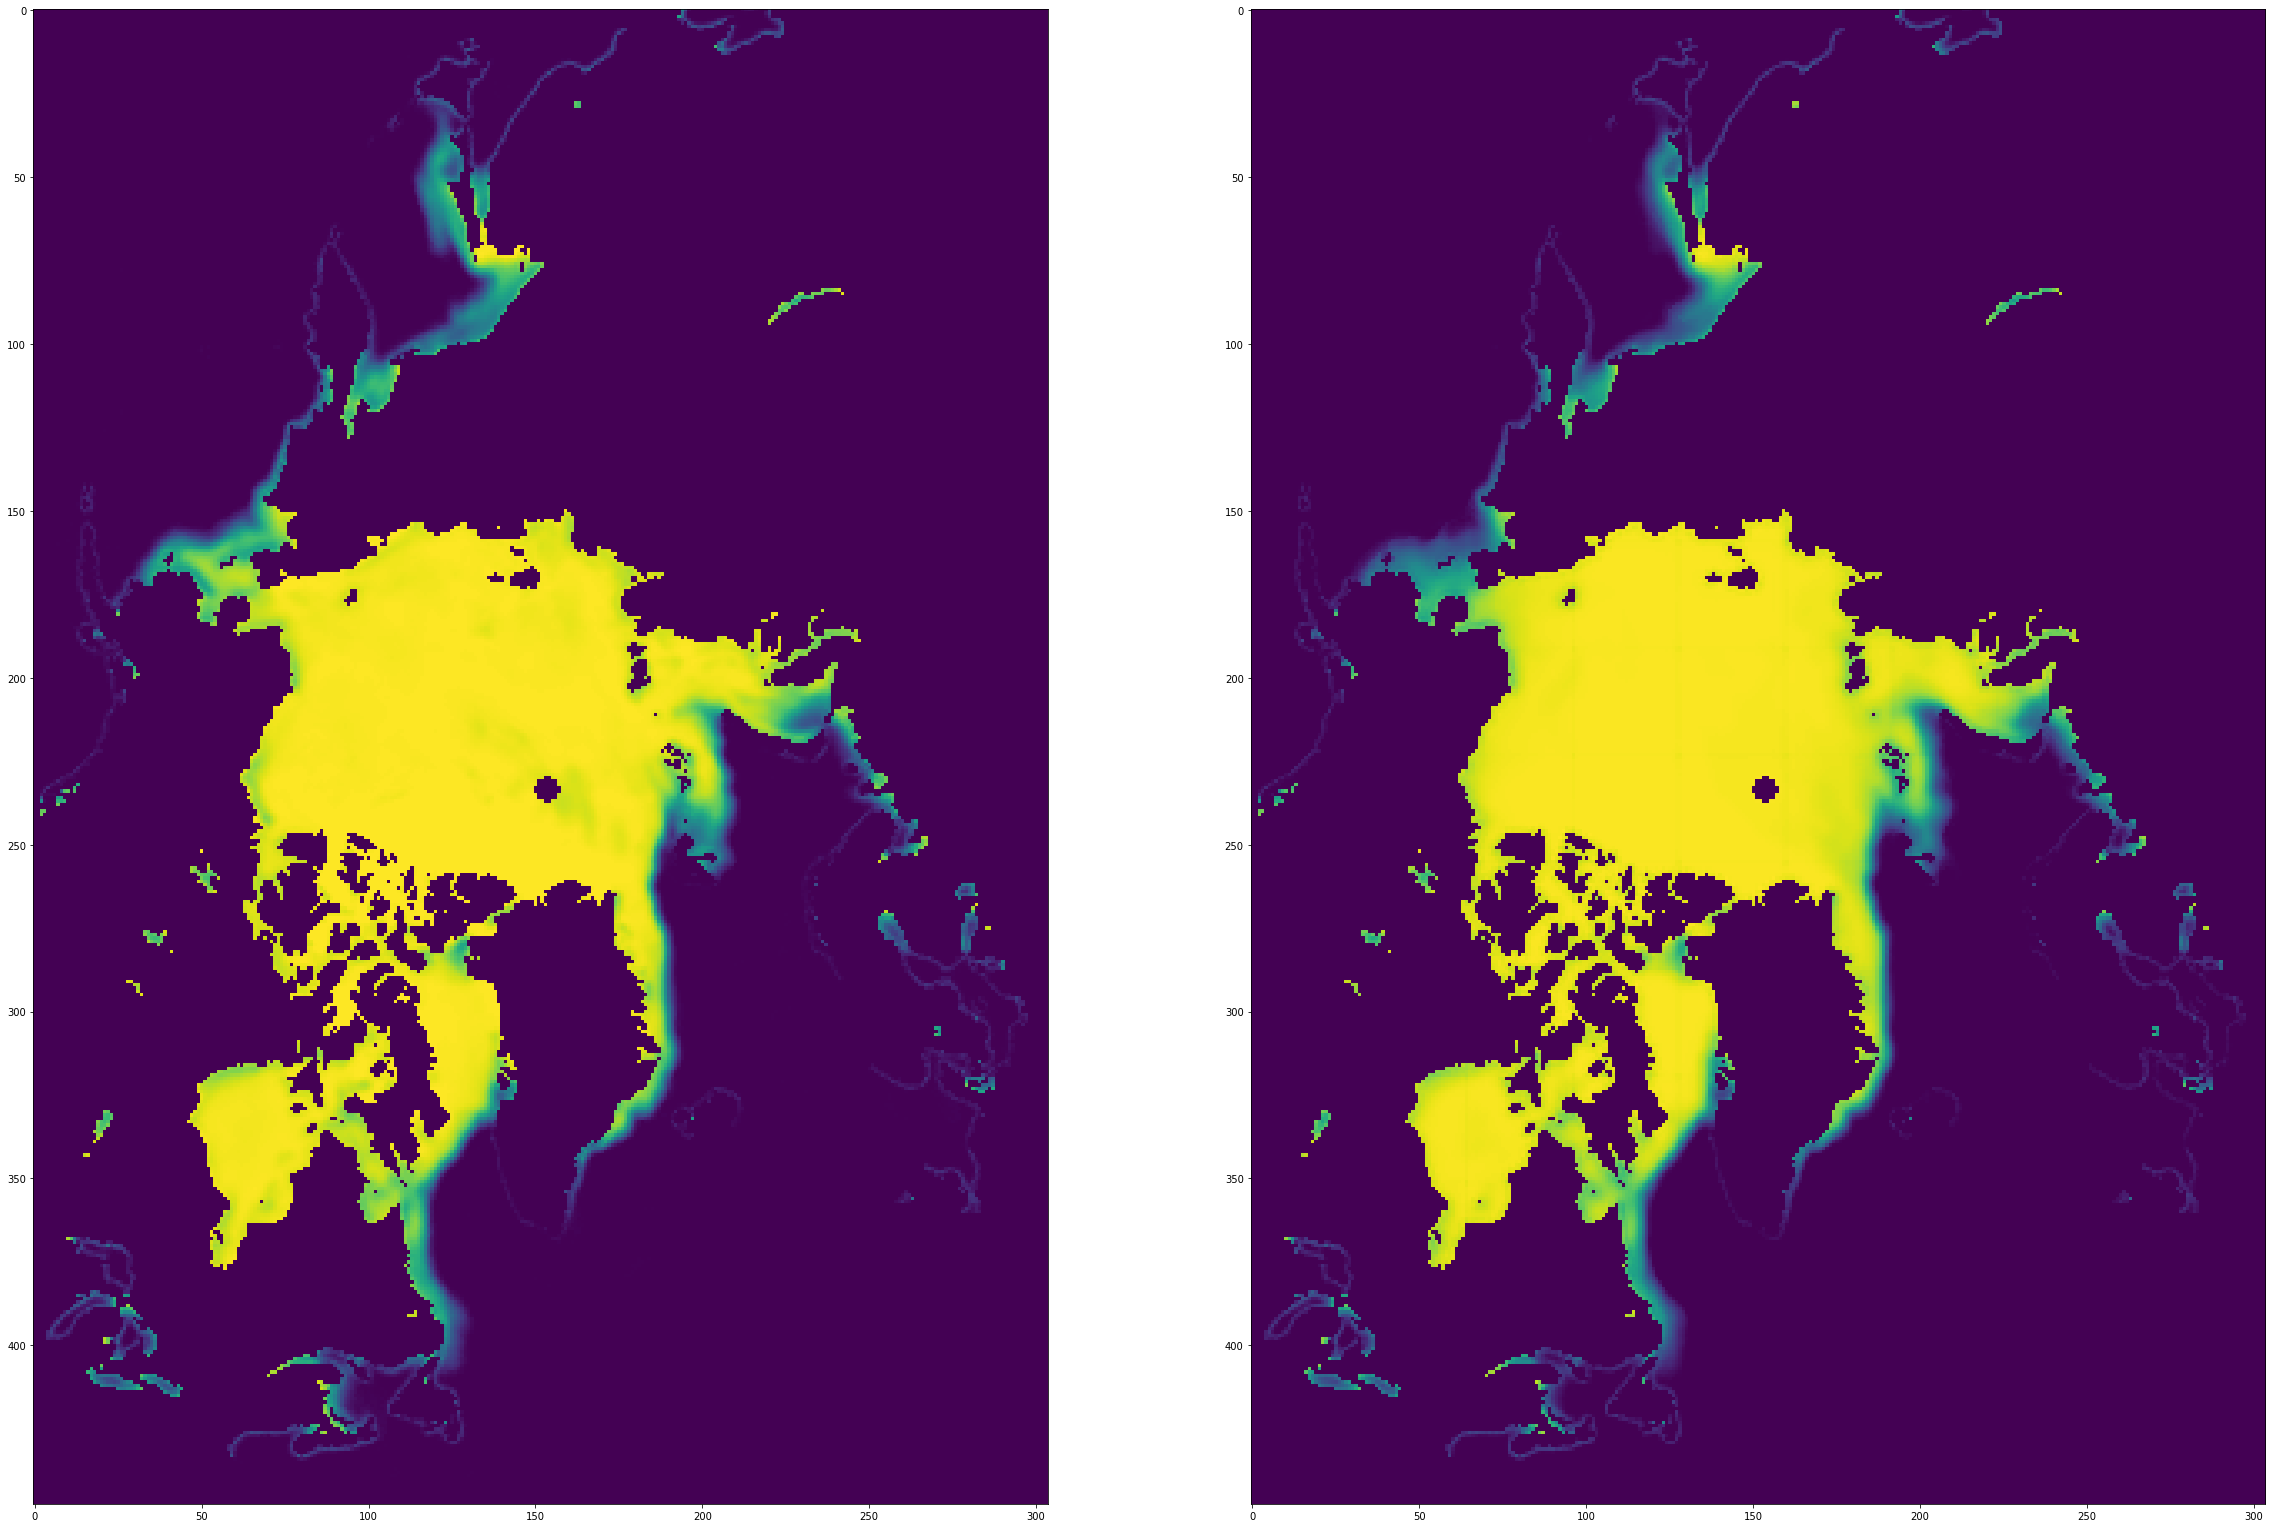

2 month 



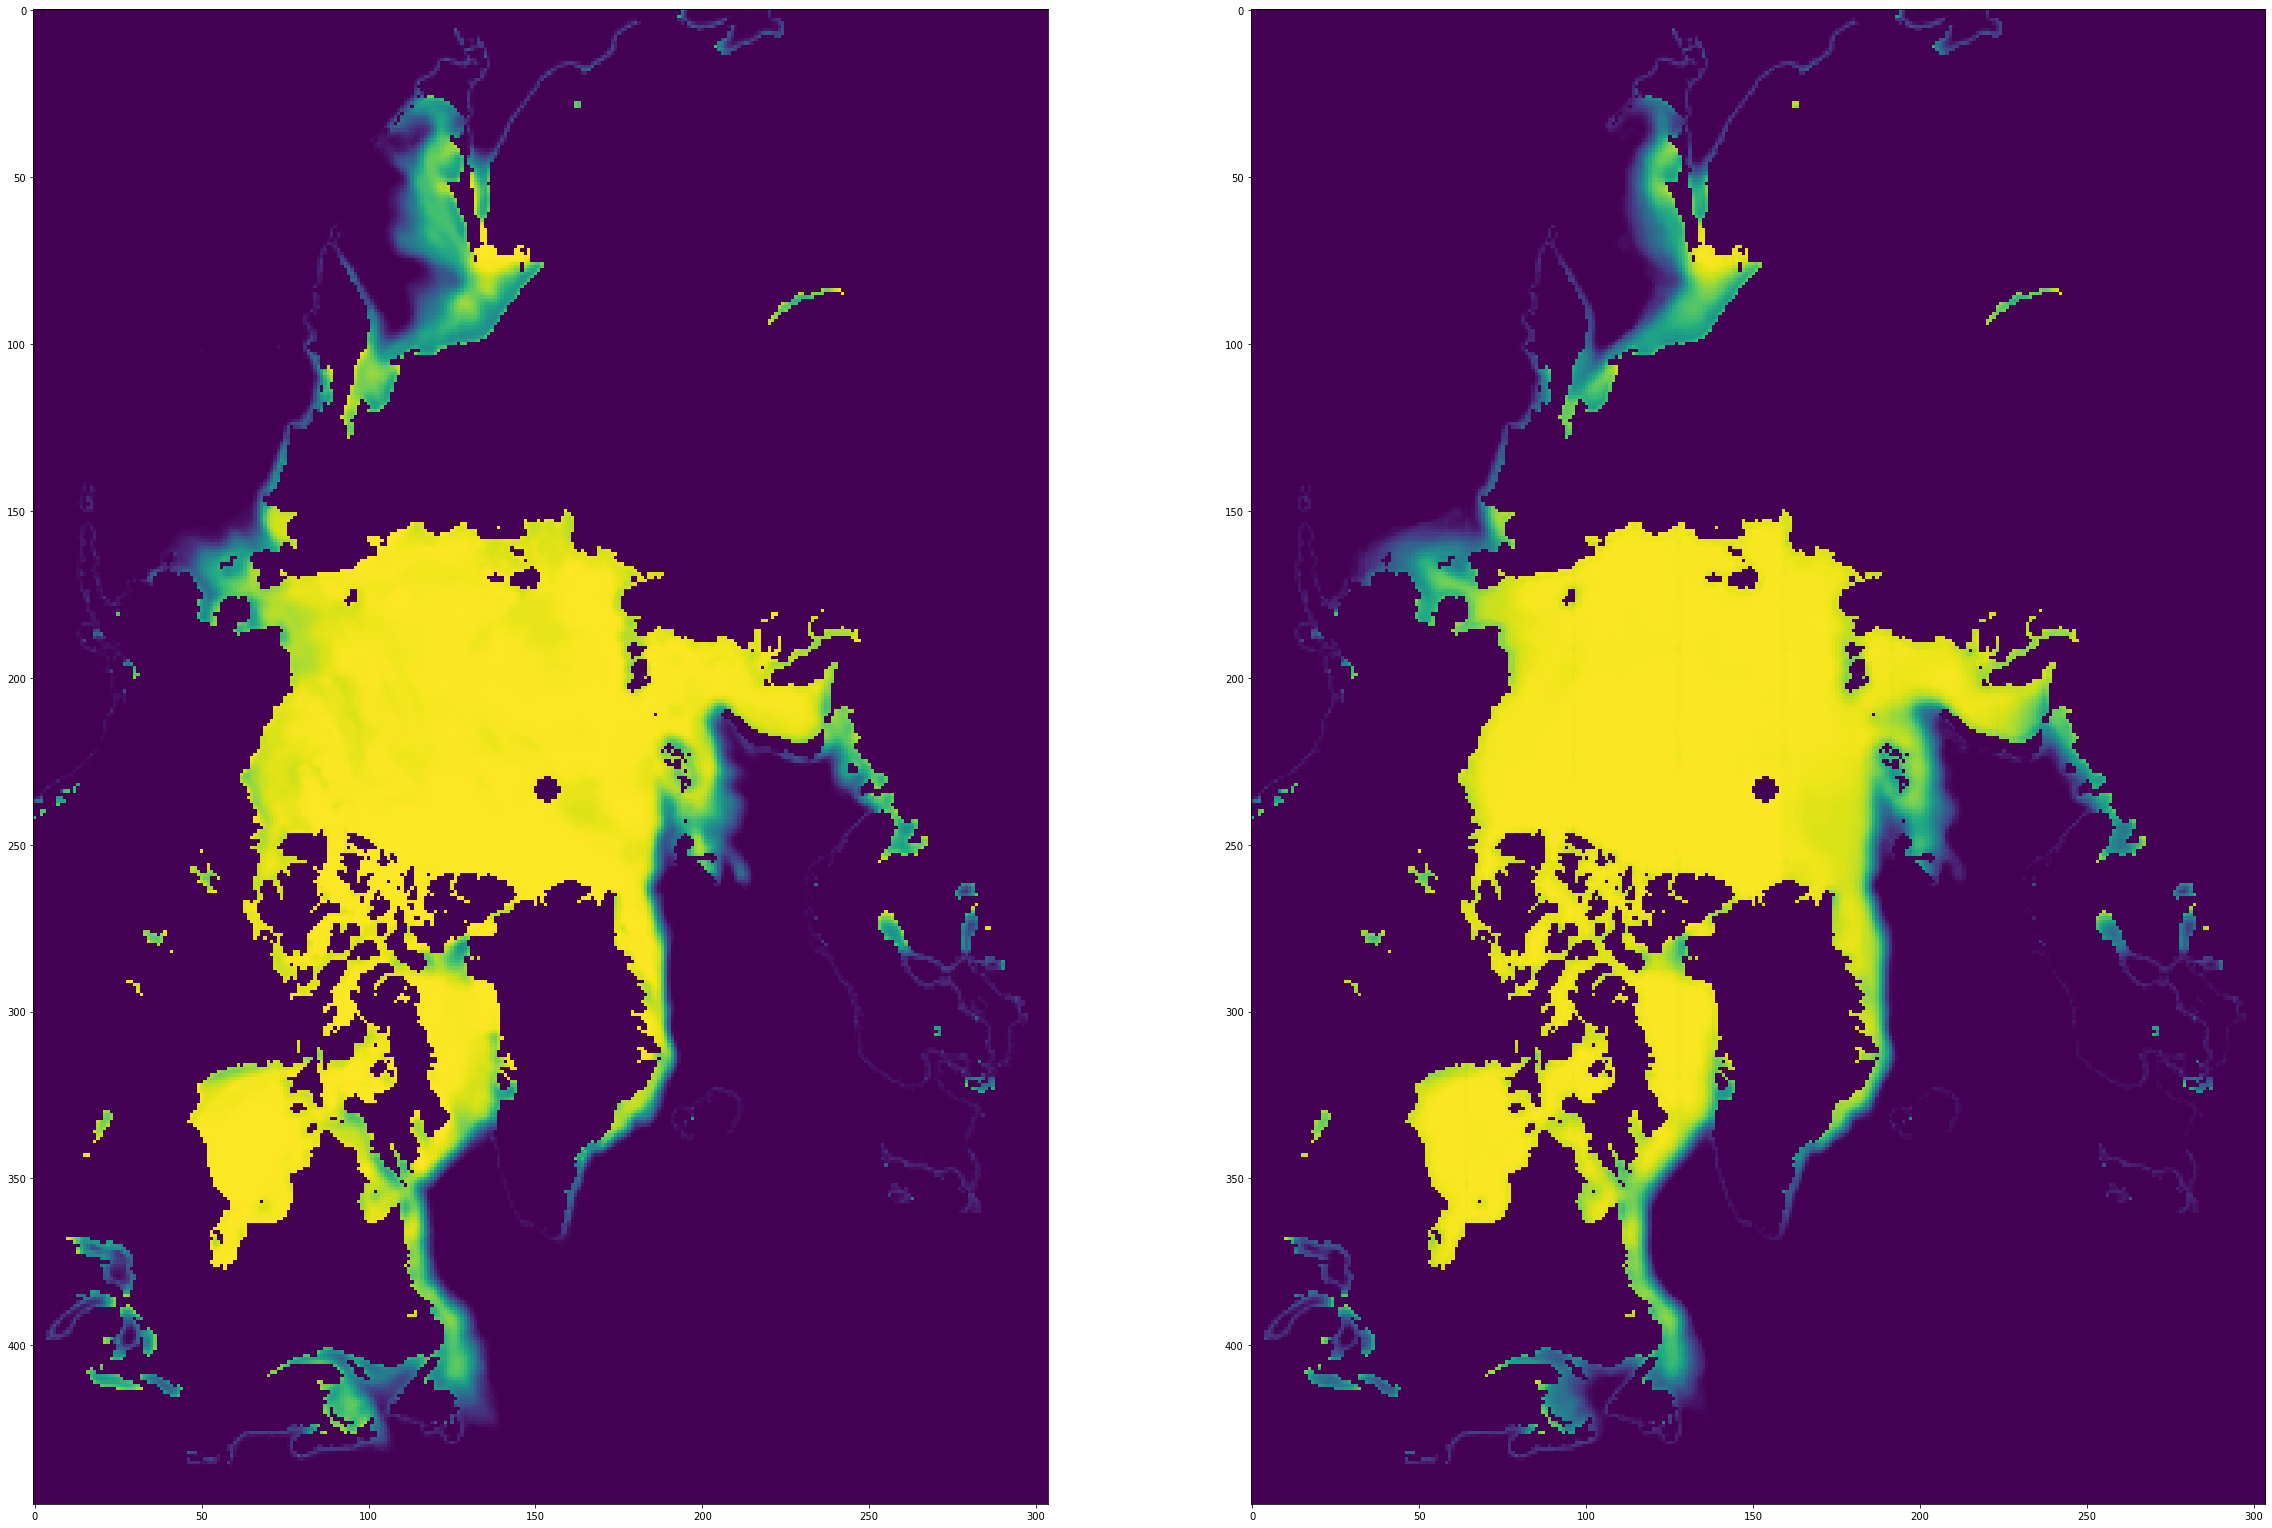

3 month 



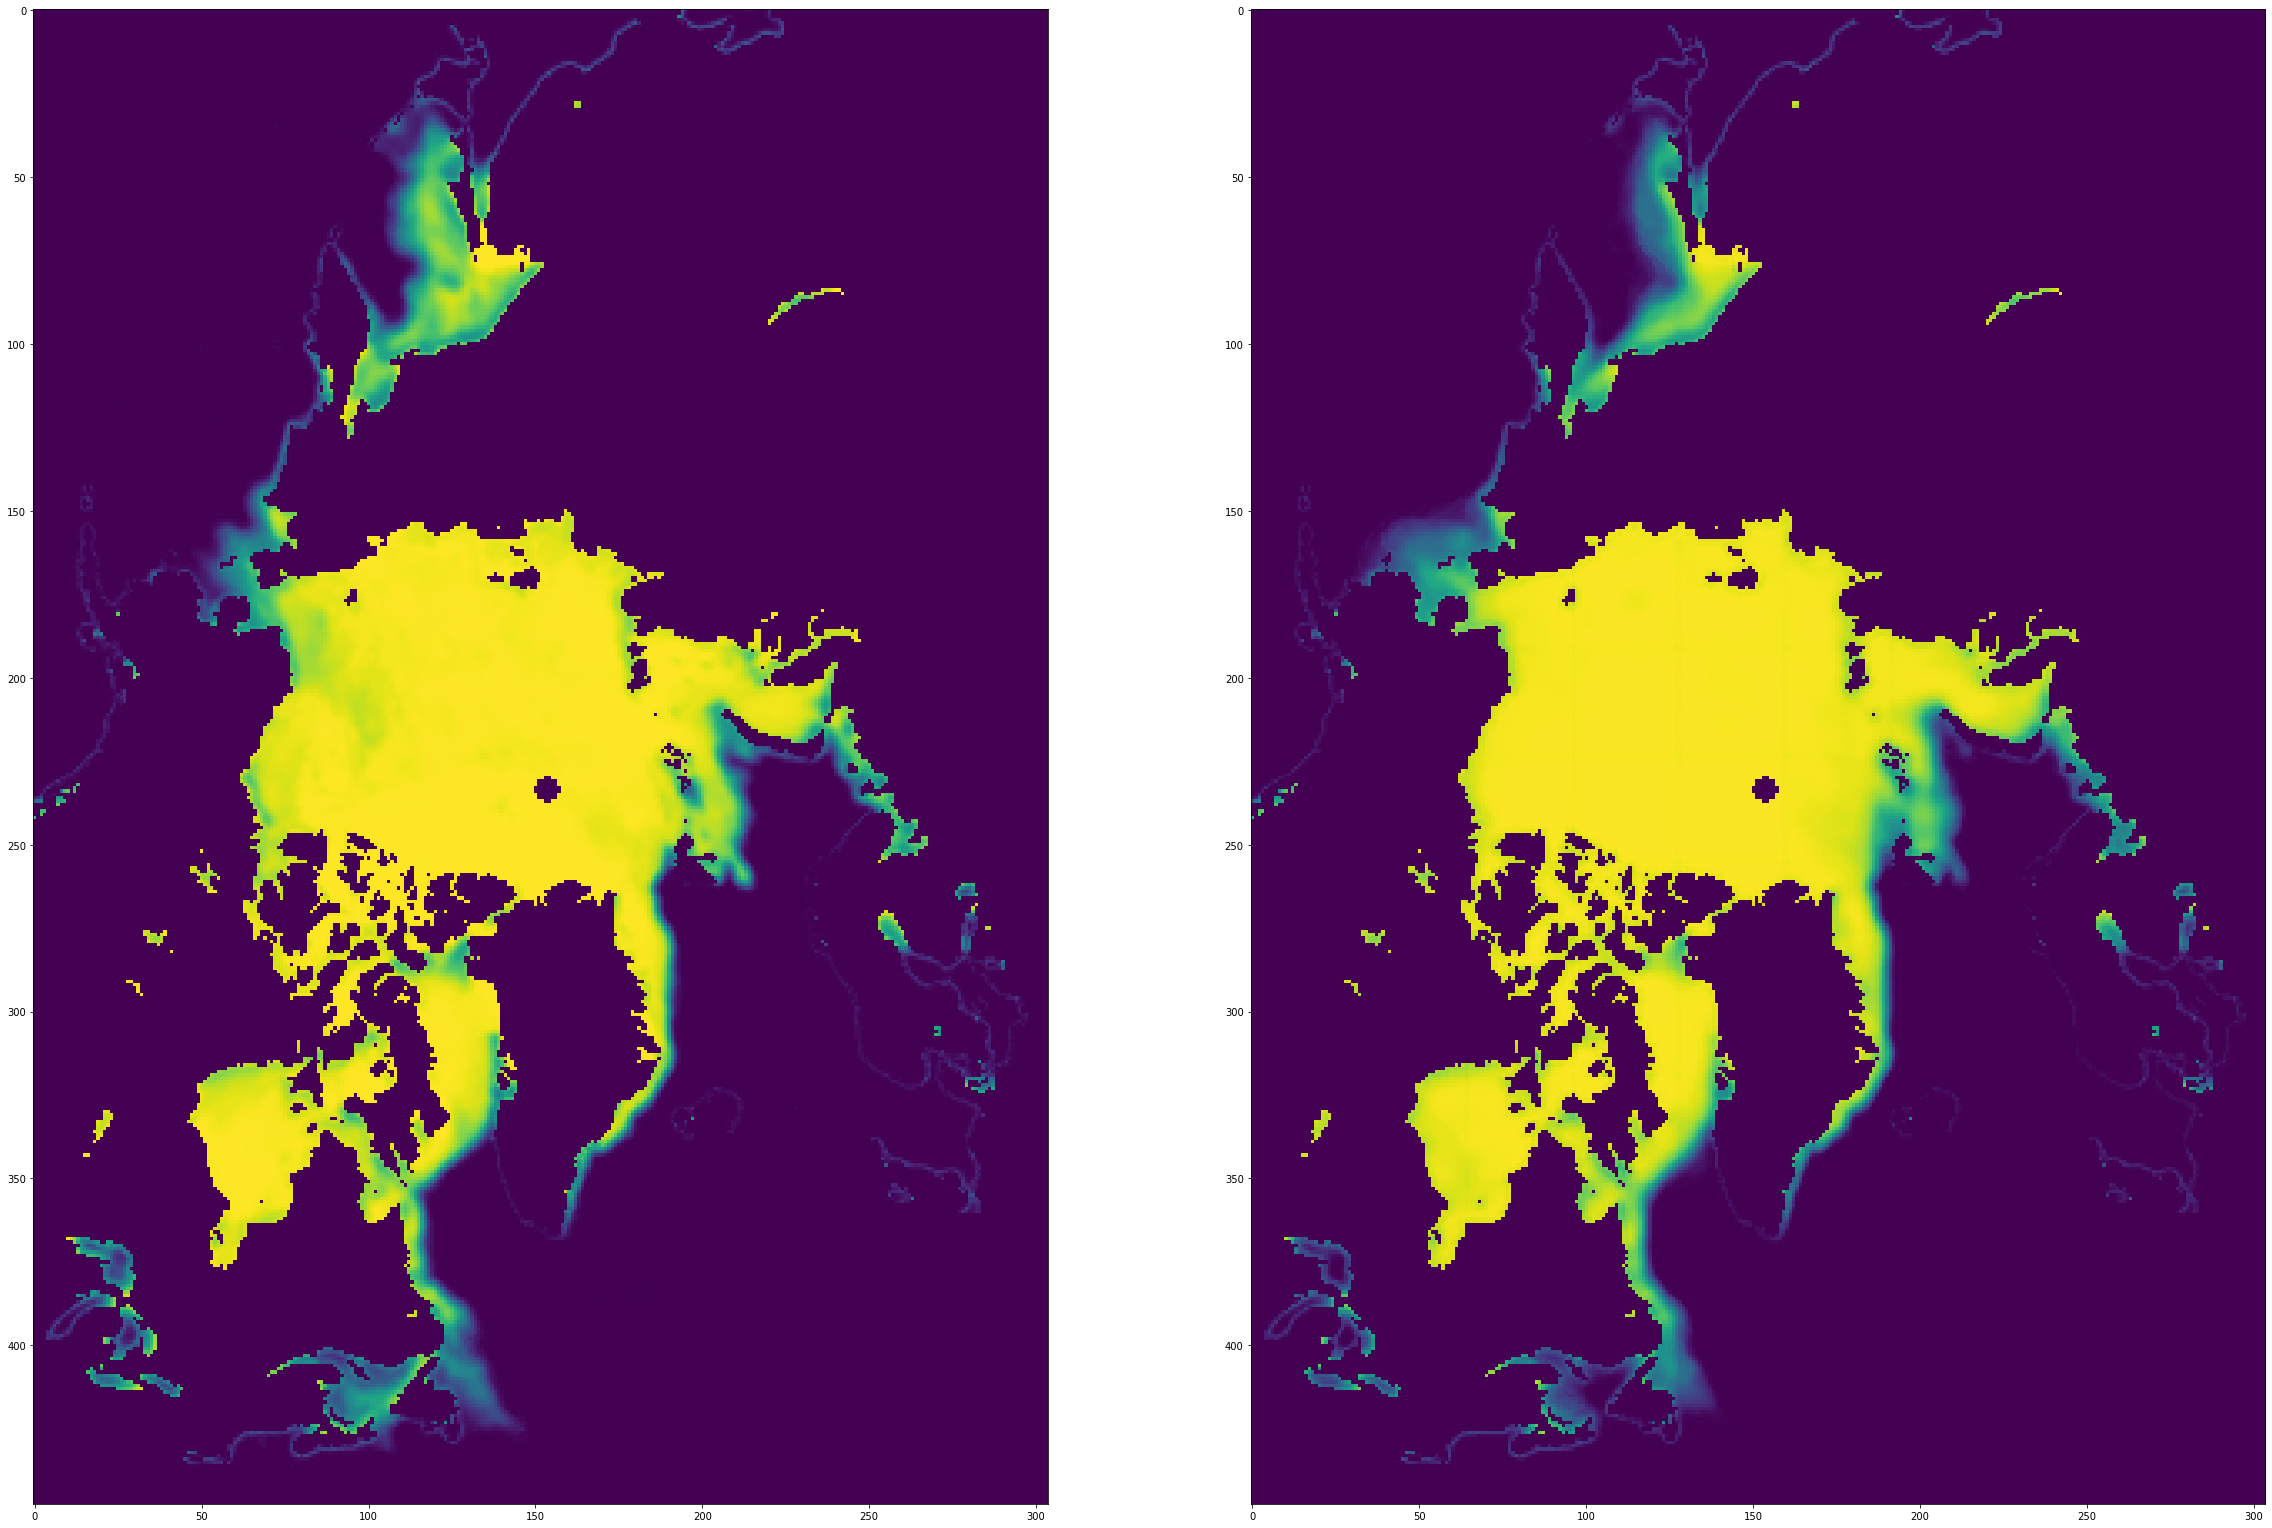

4 month 



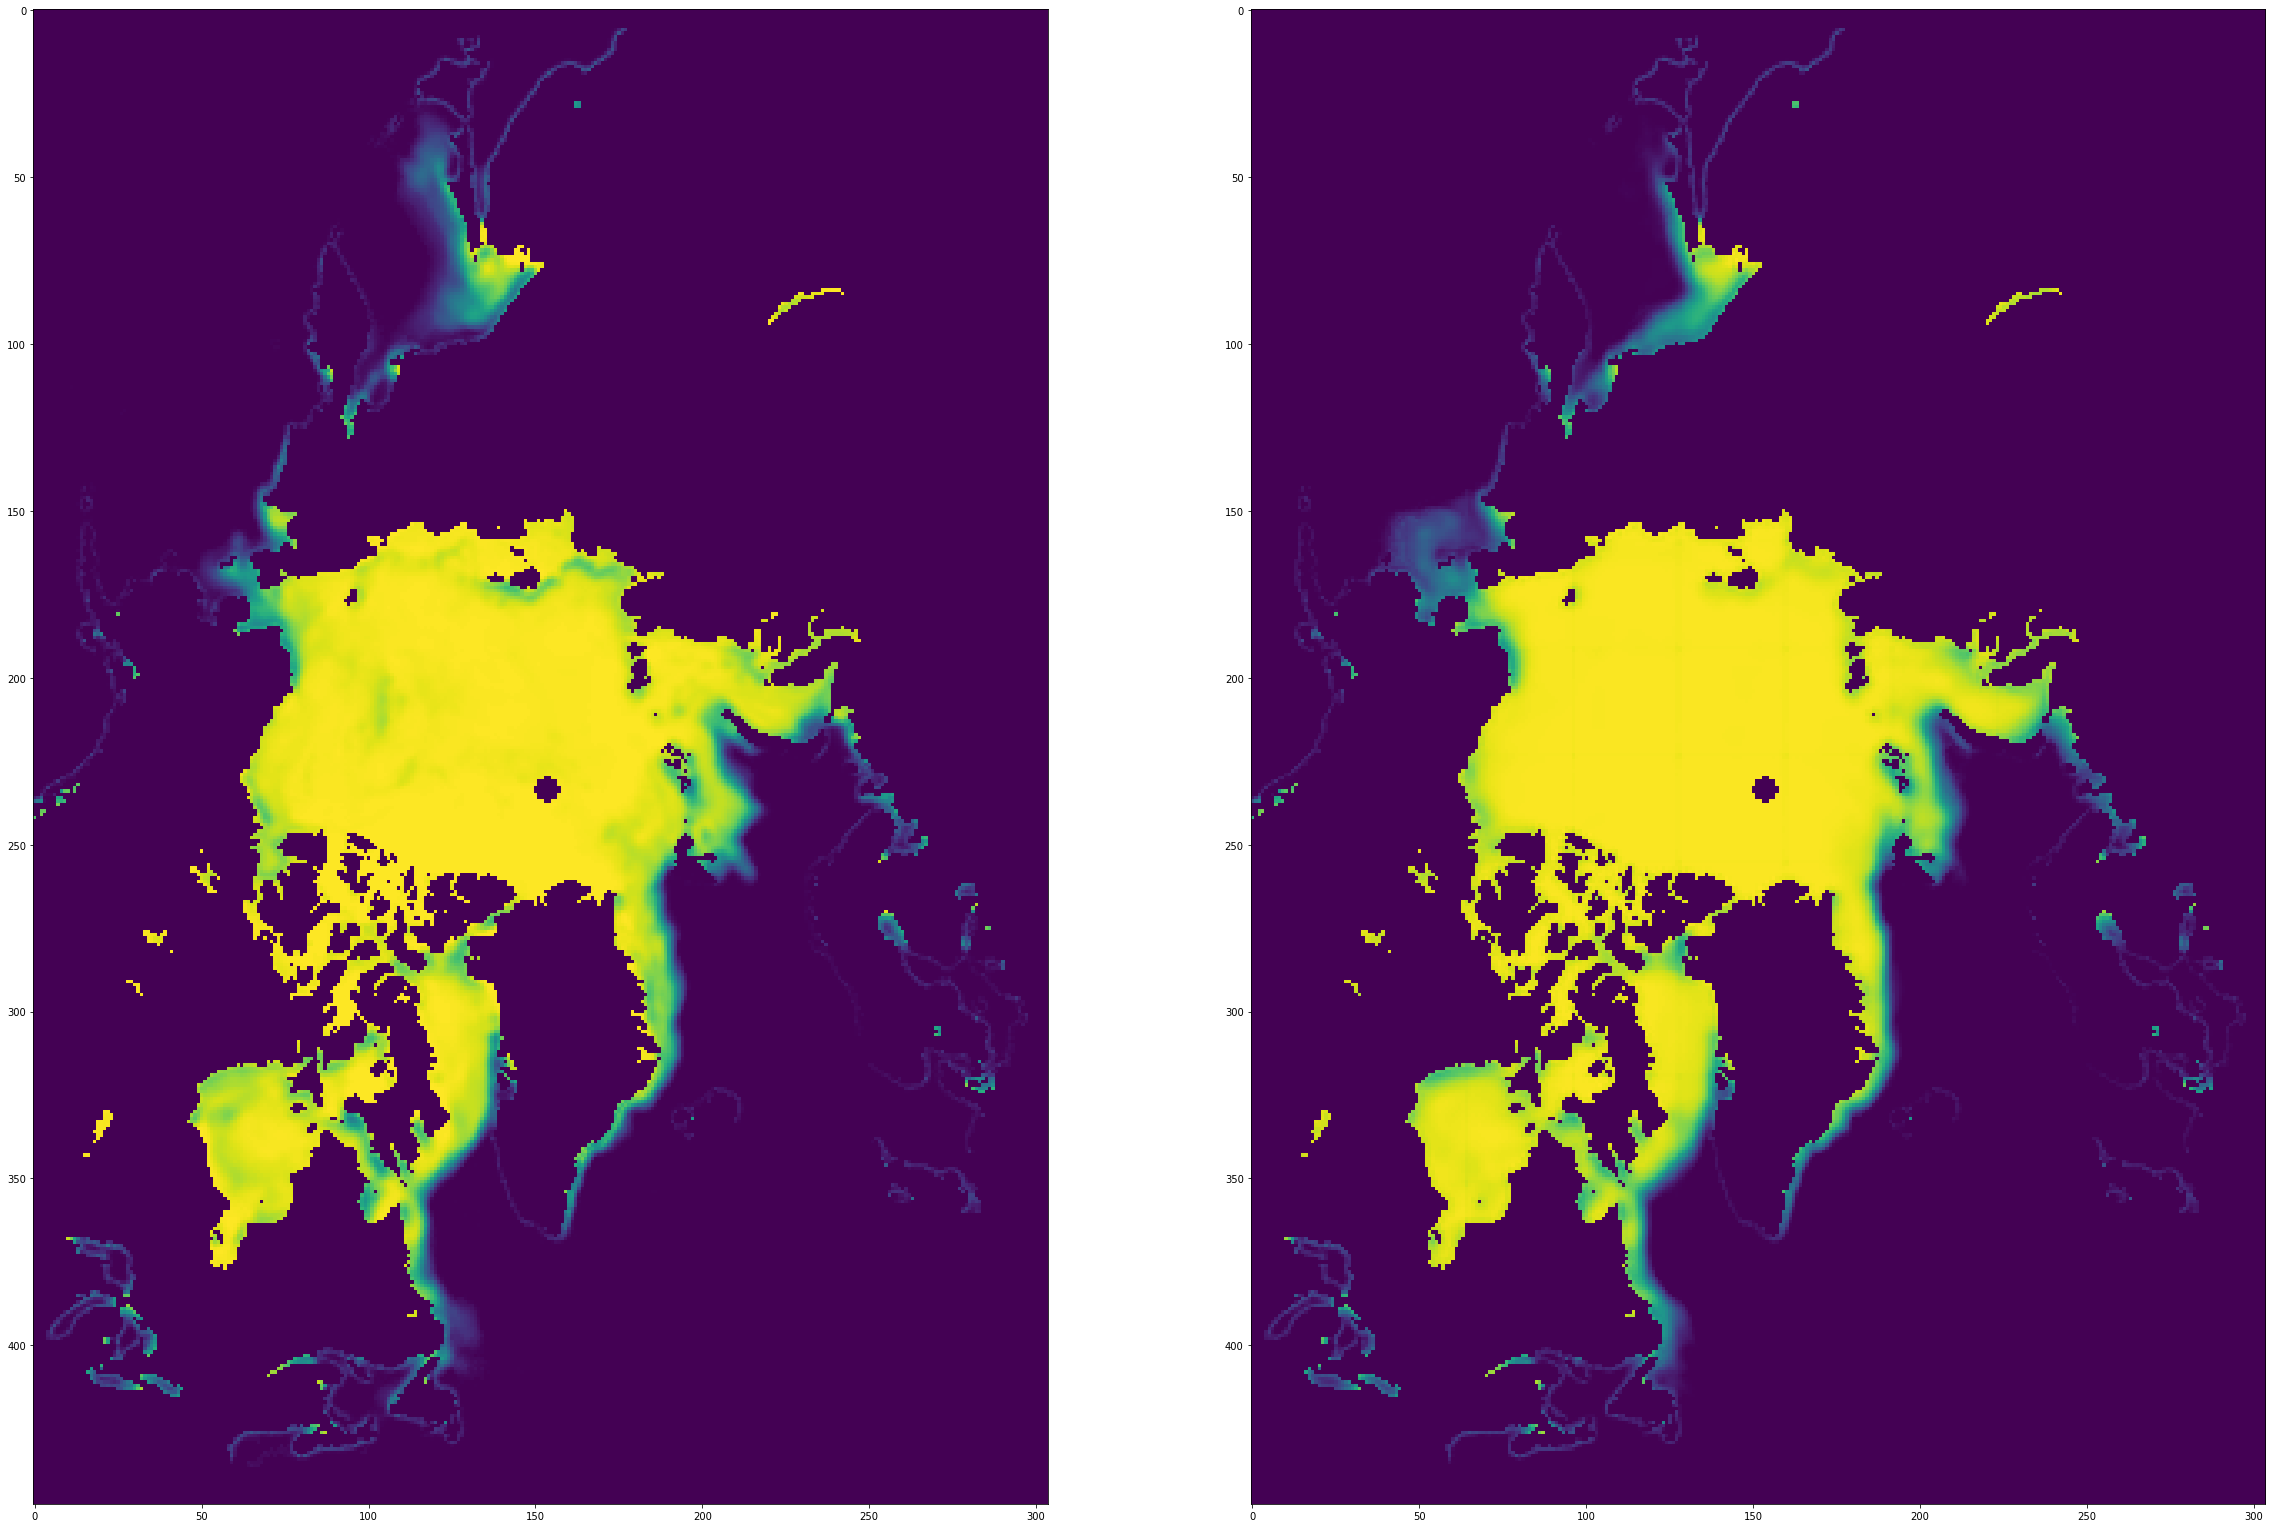

5 month 



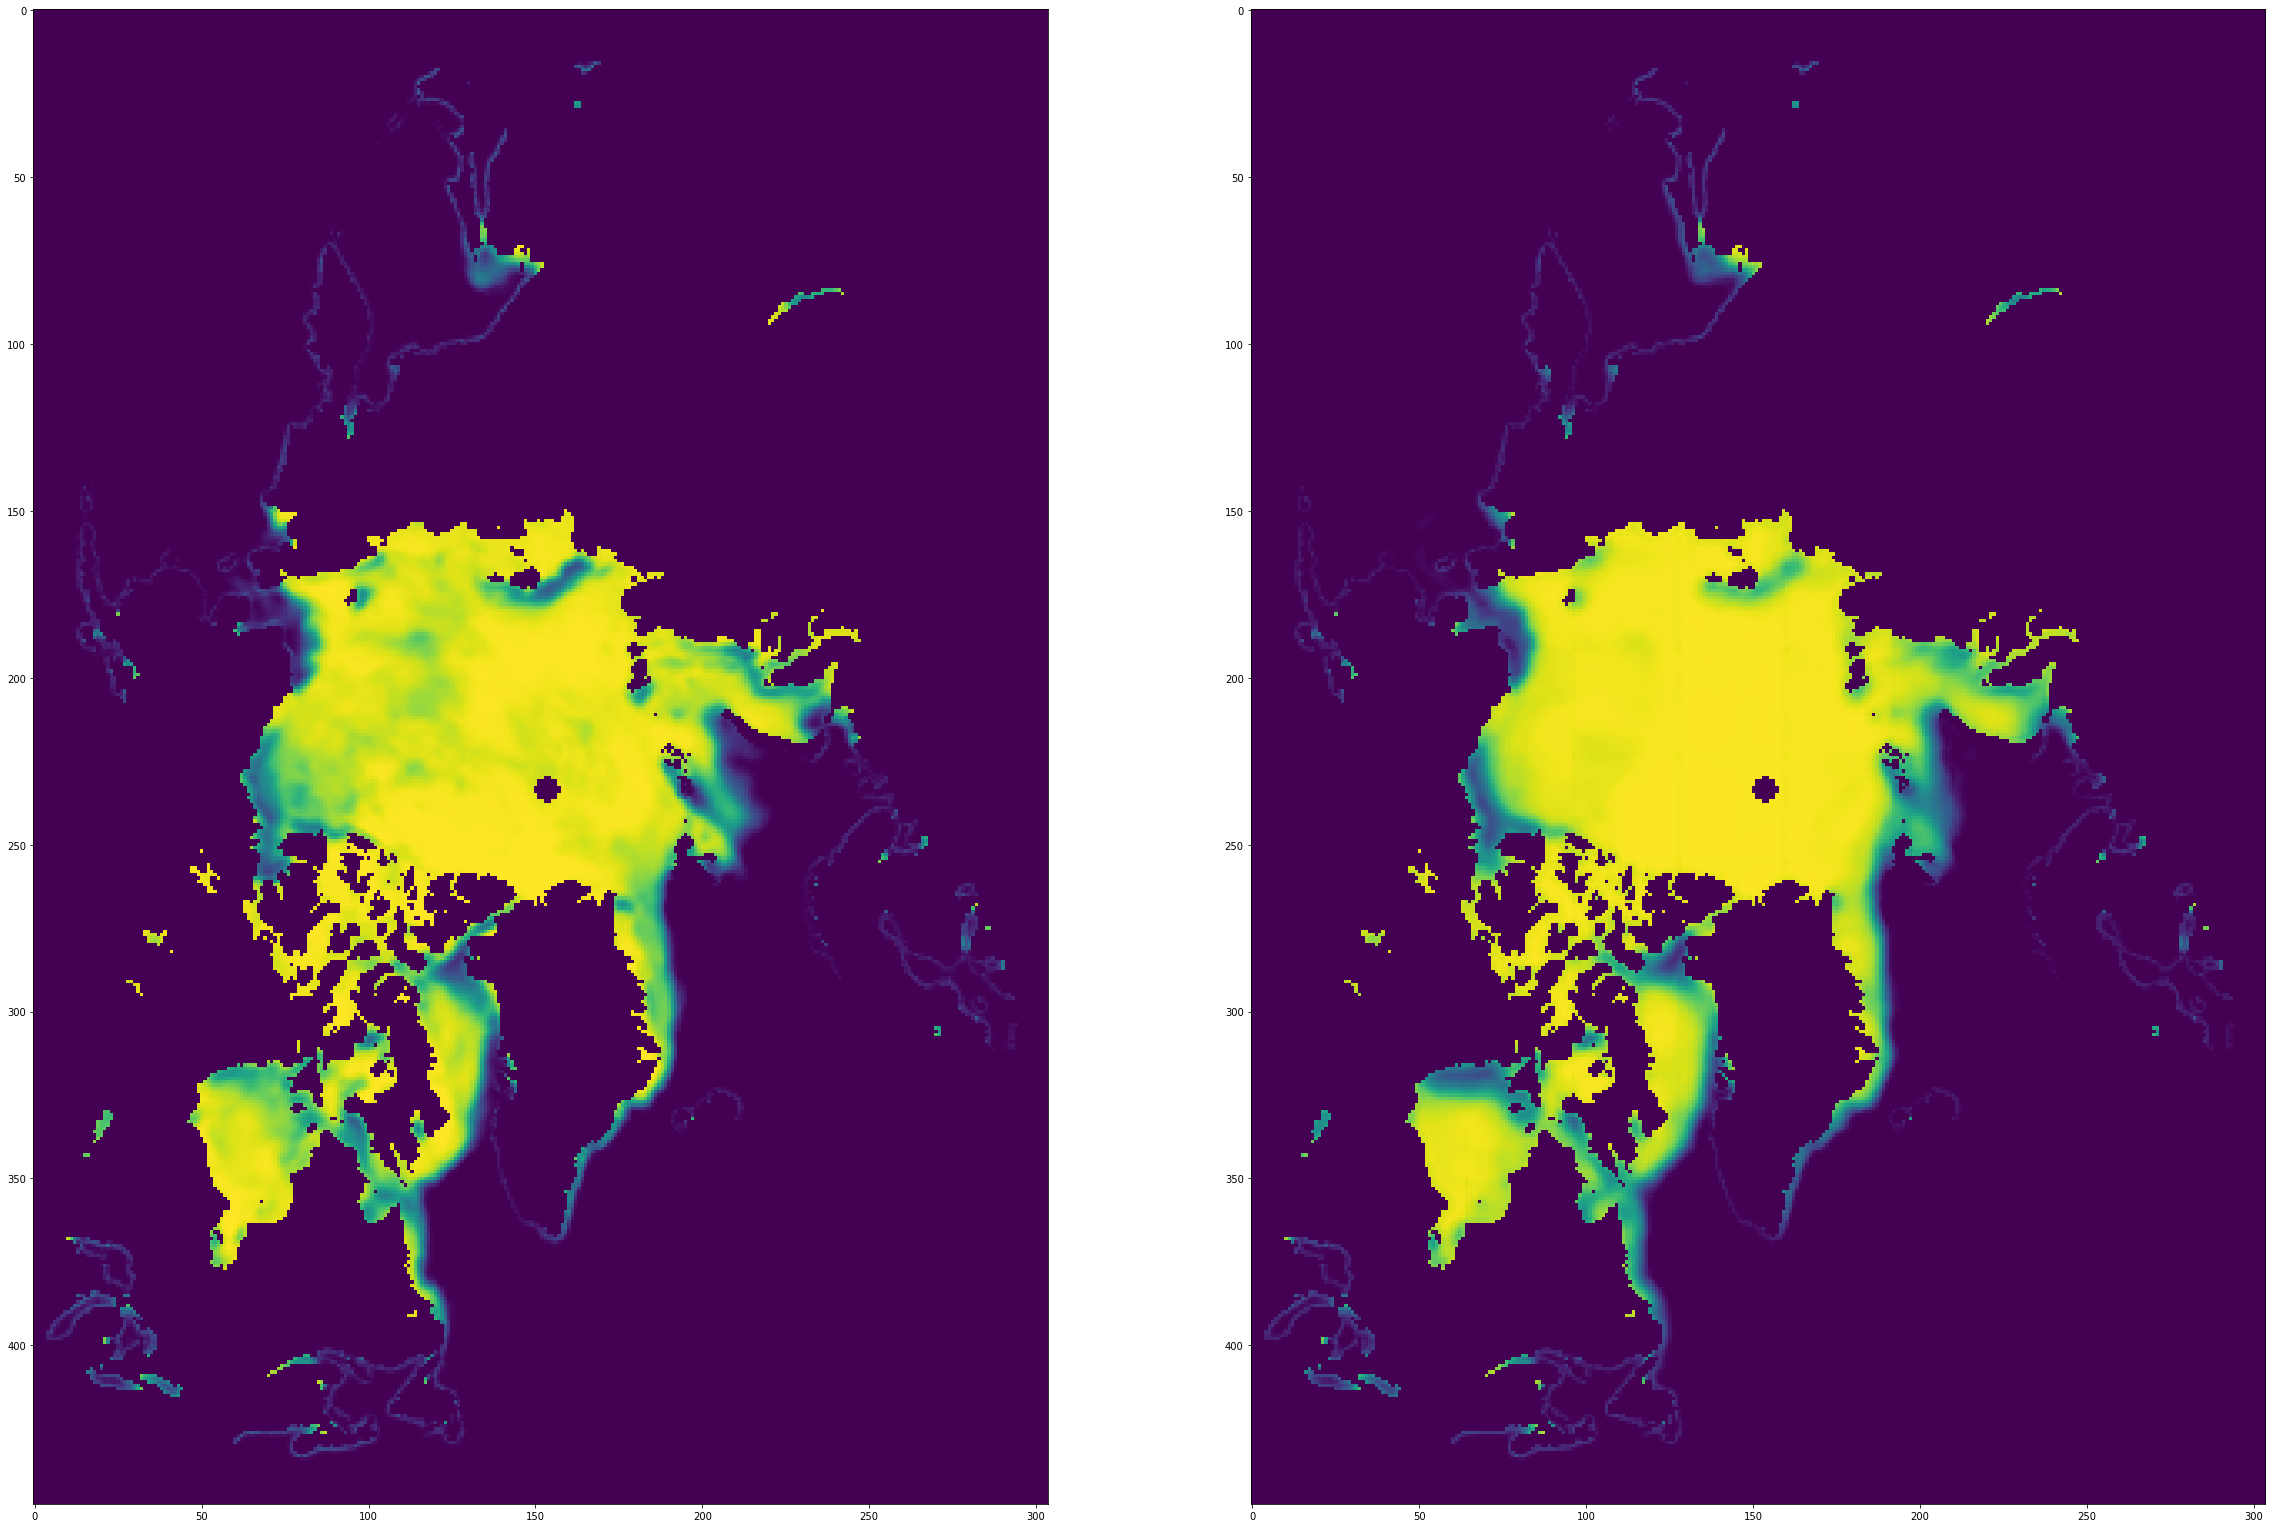

6 month 



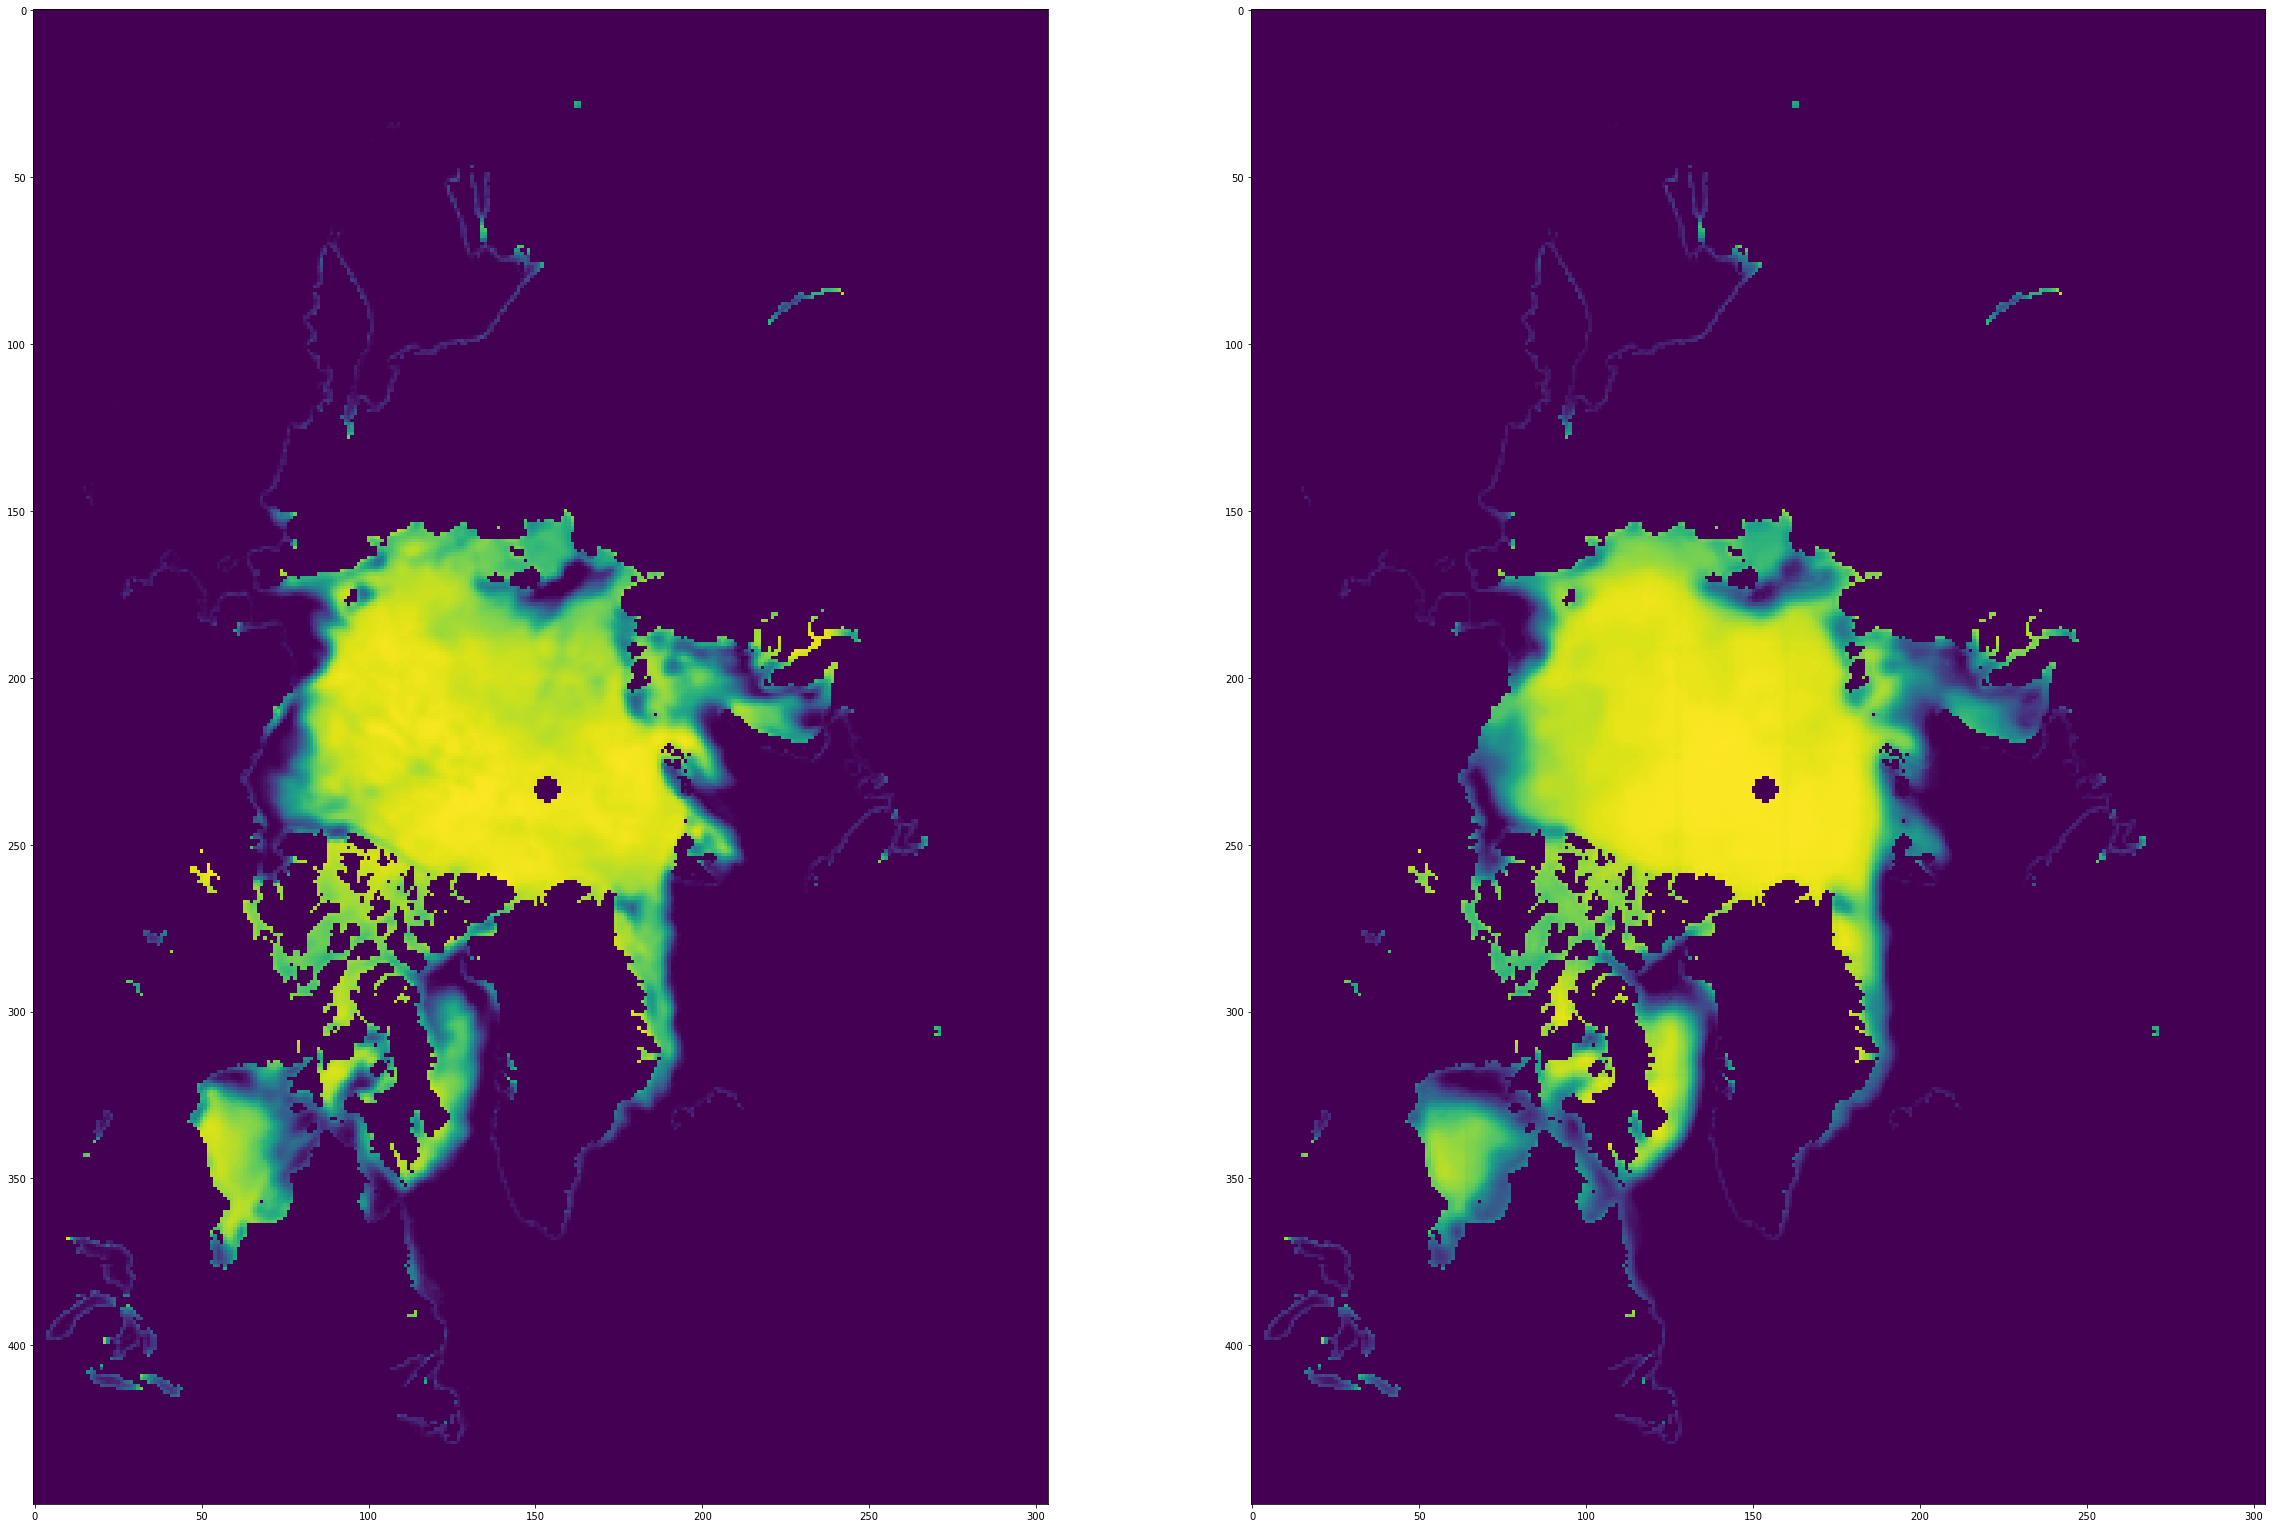

7 month 



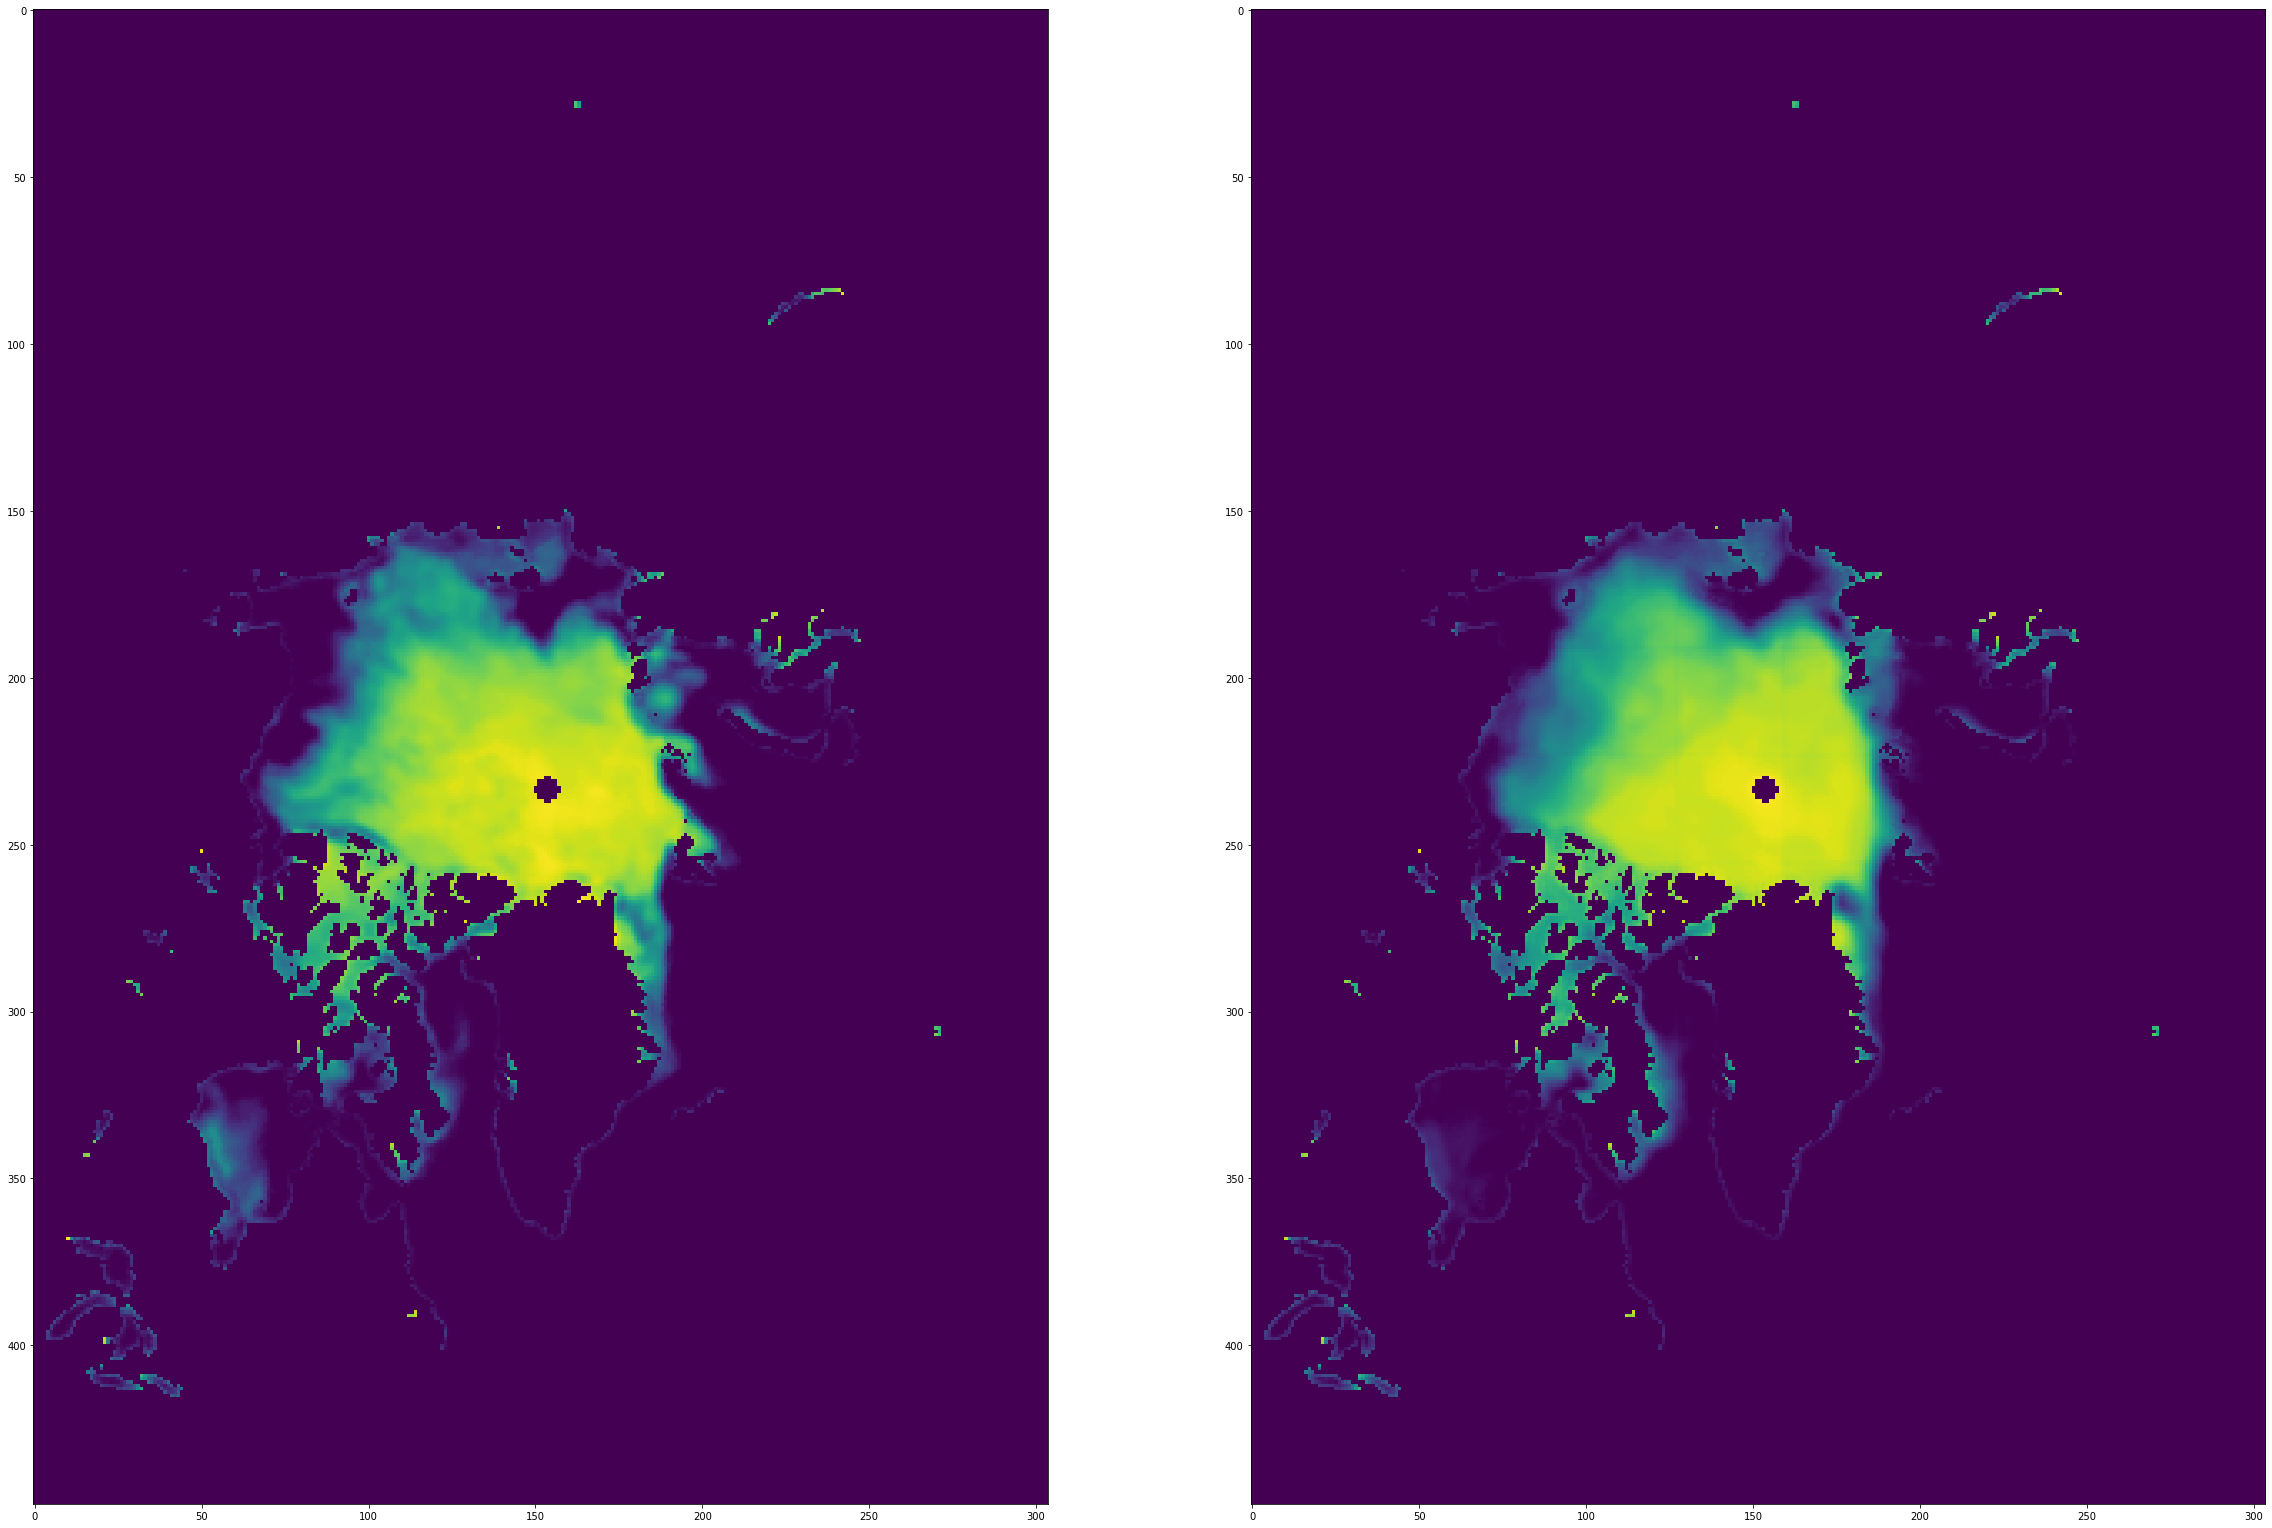

8 month 



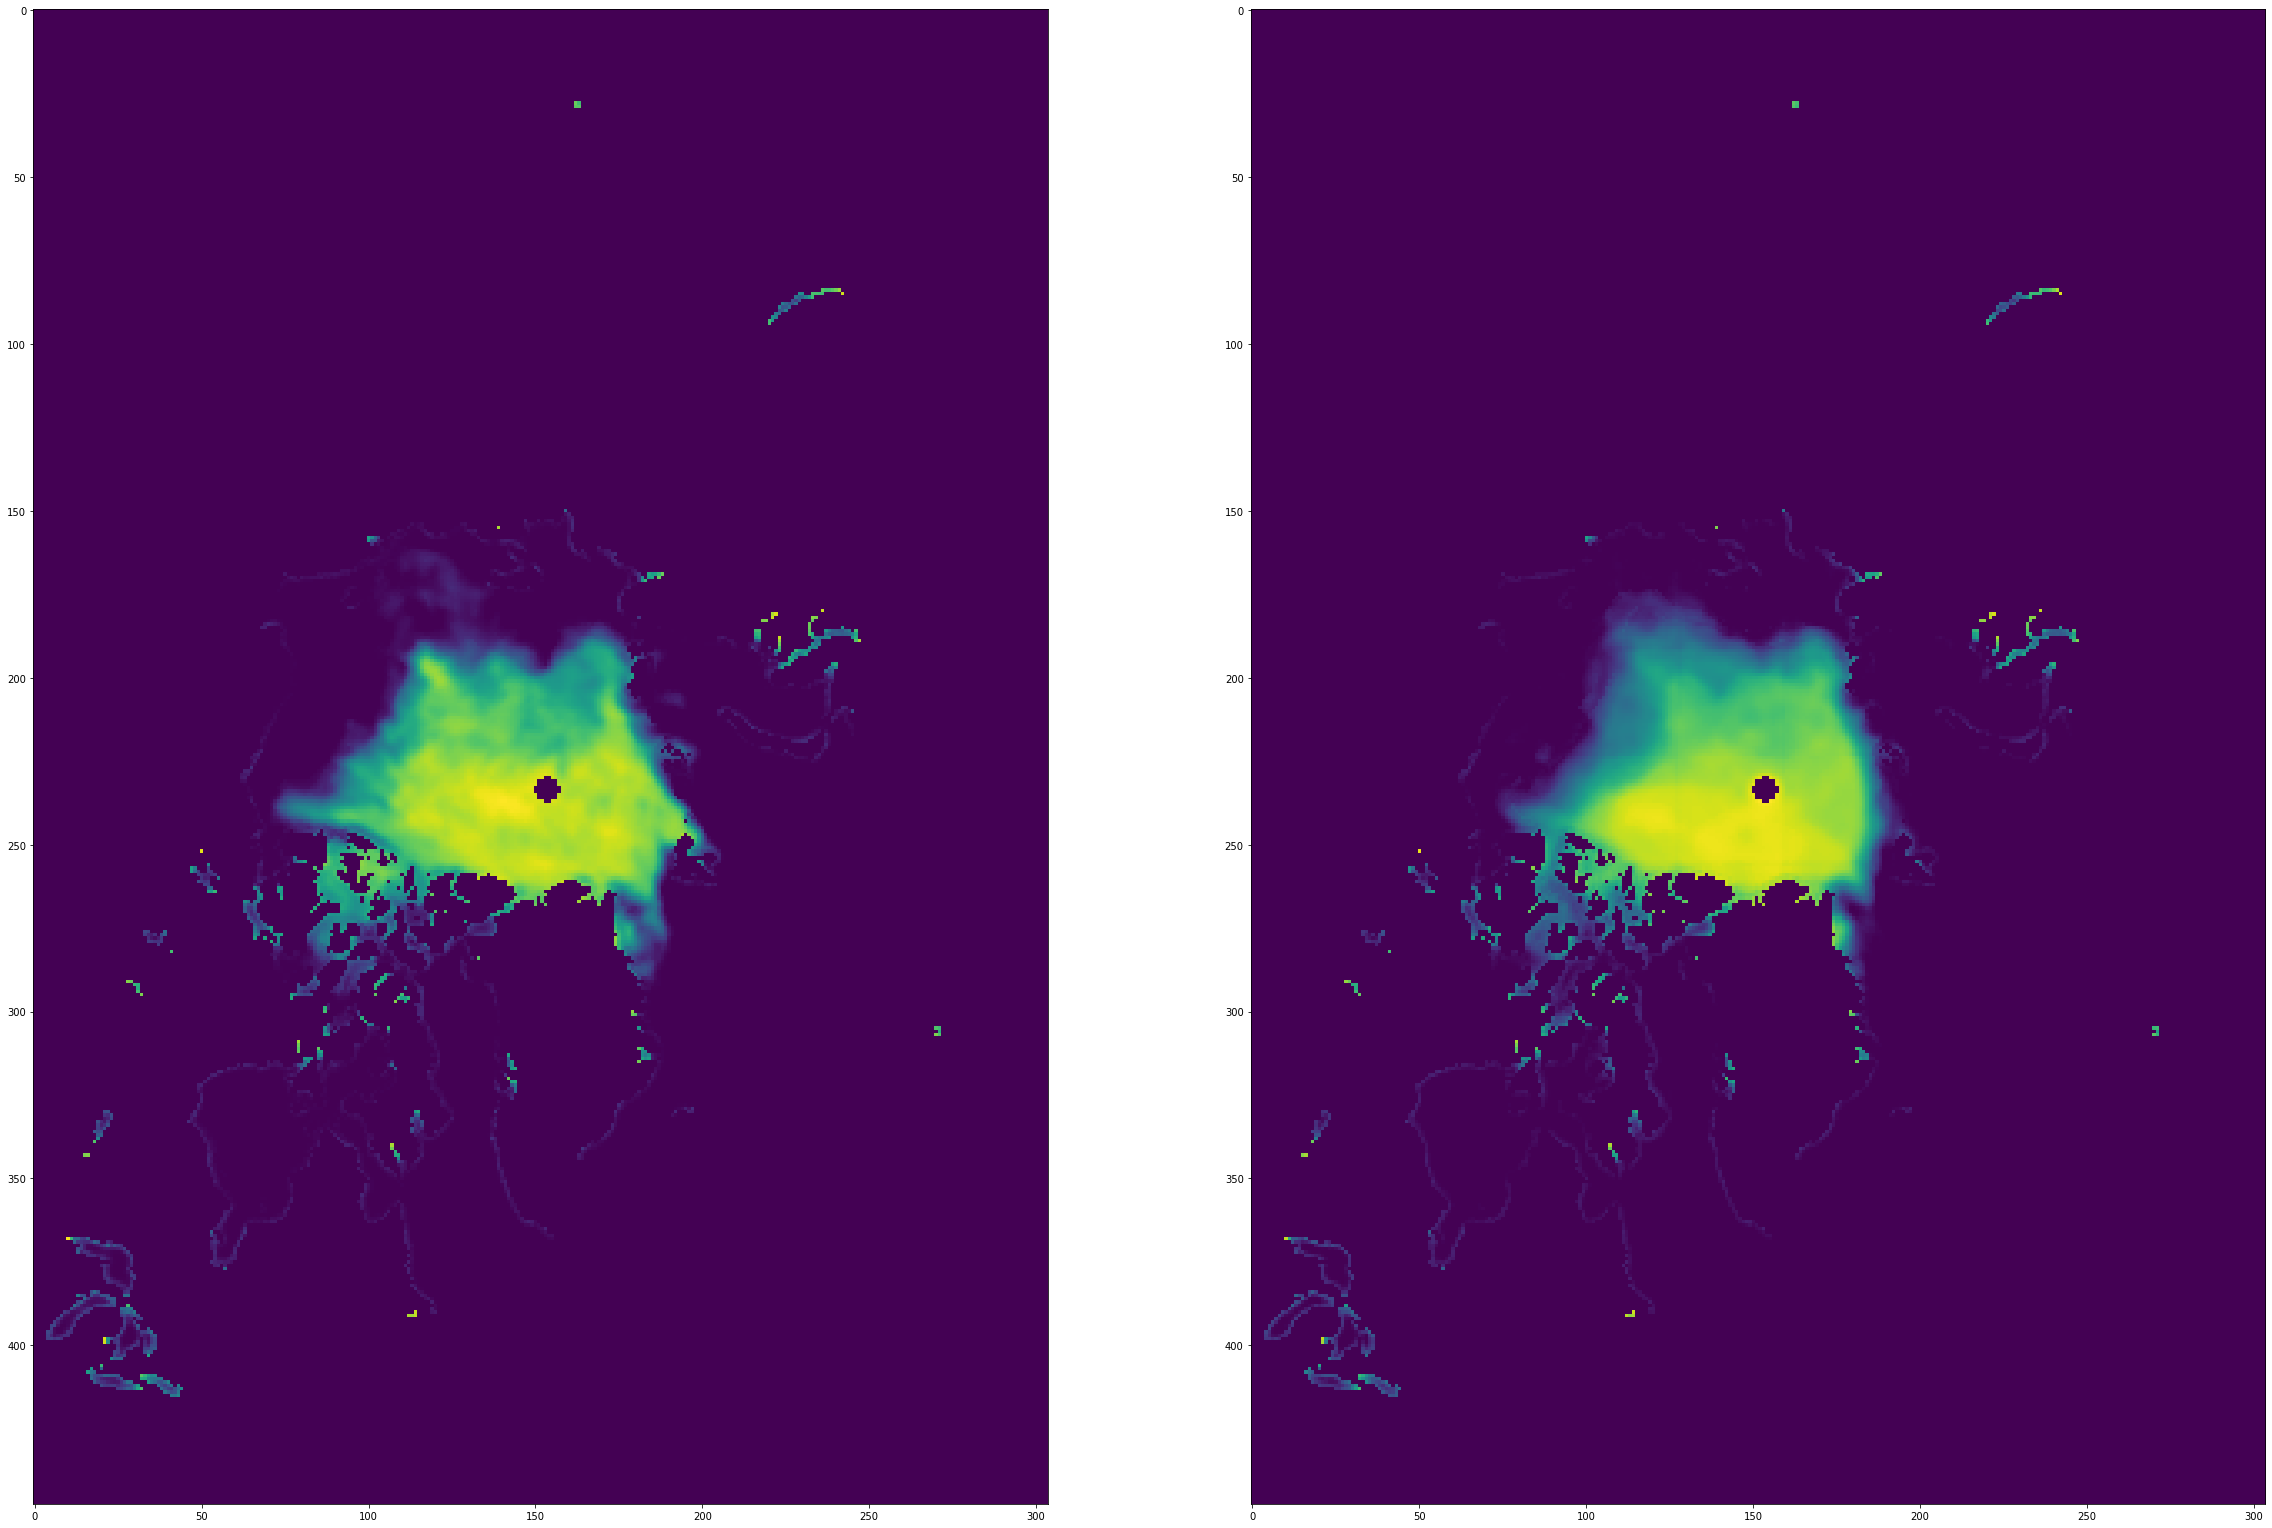

9 month 



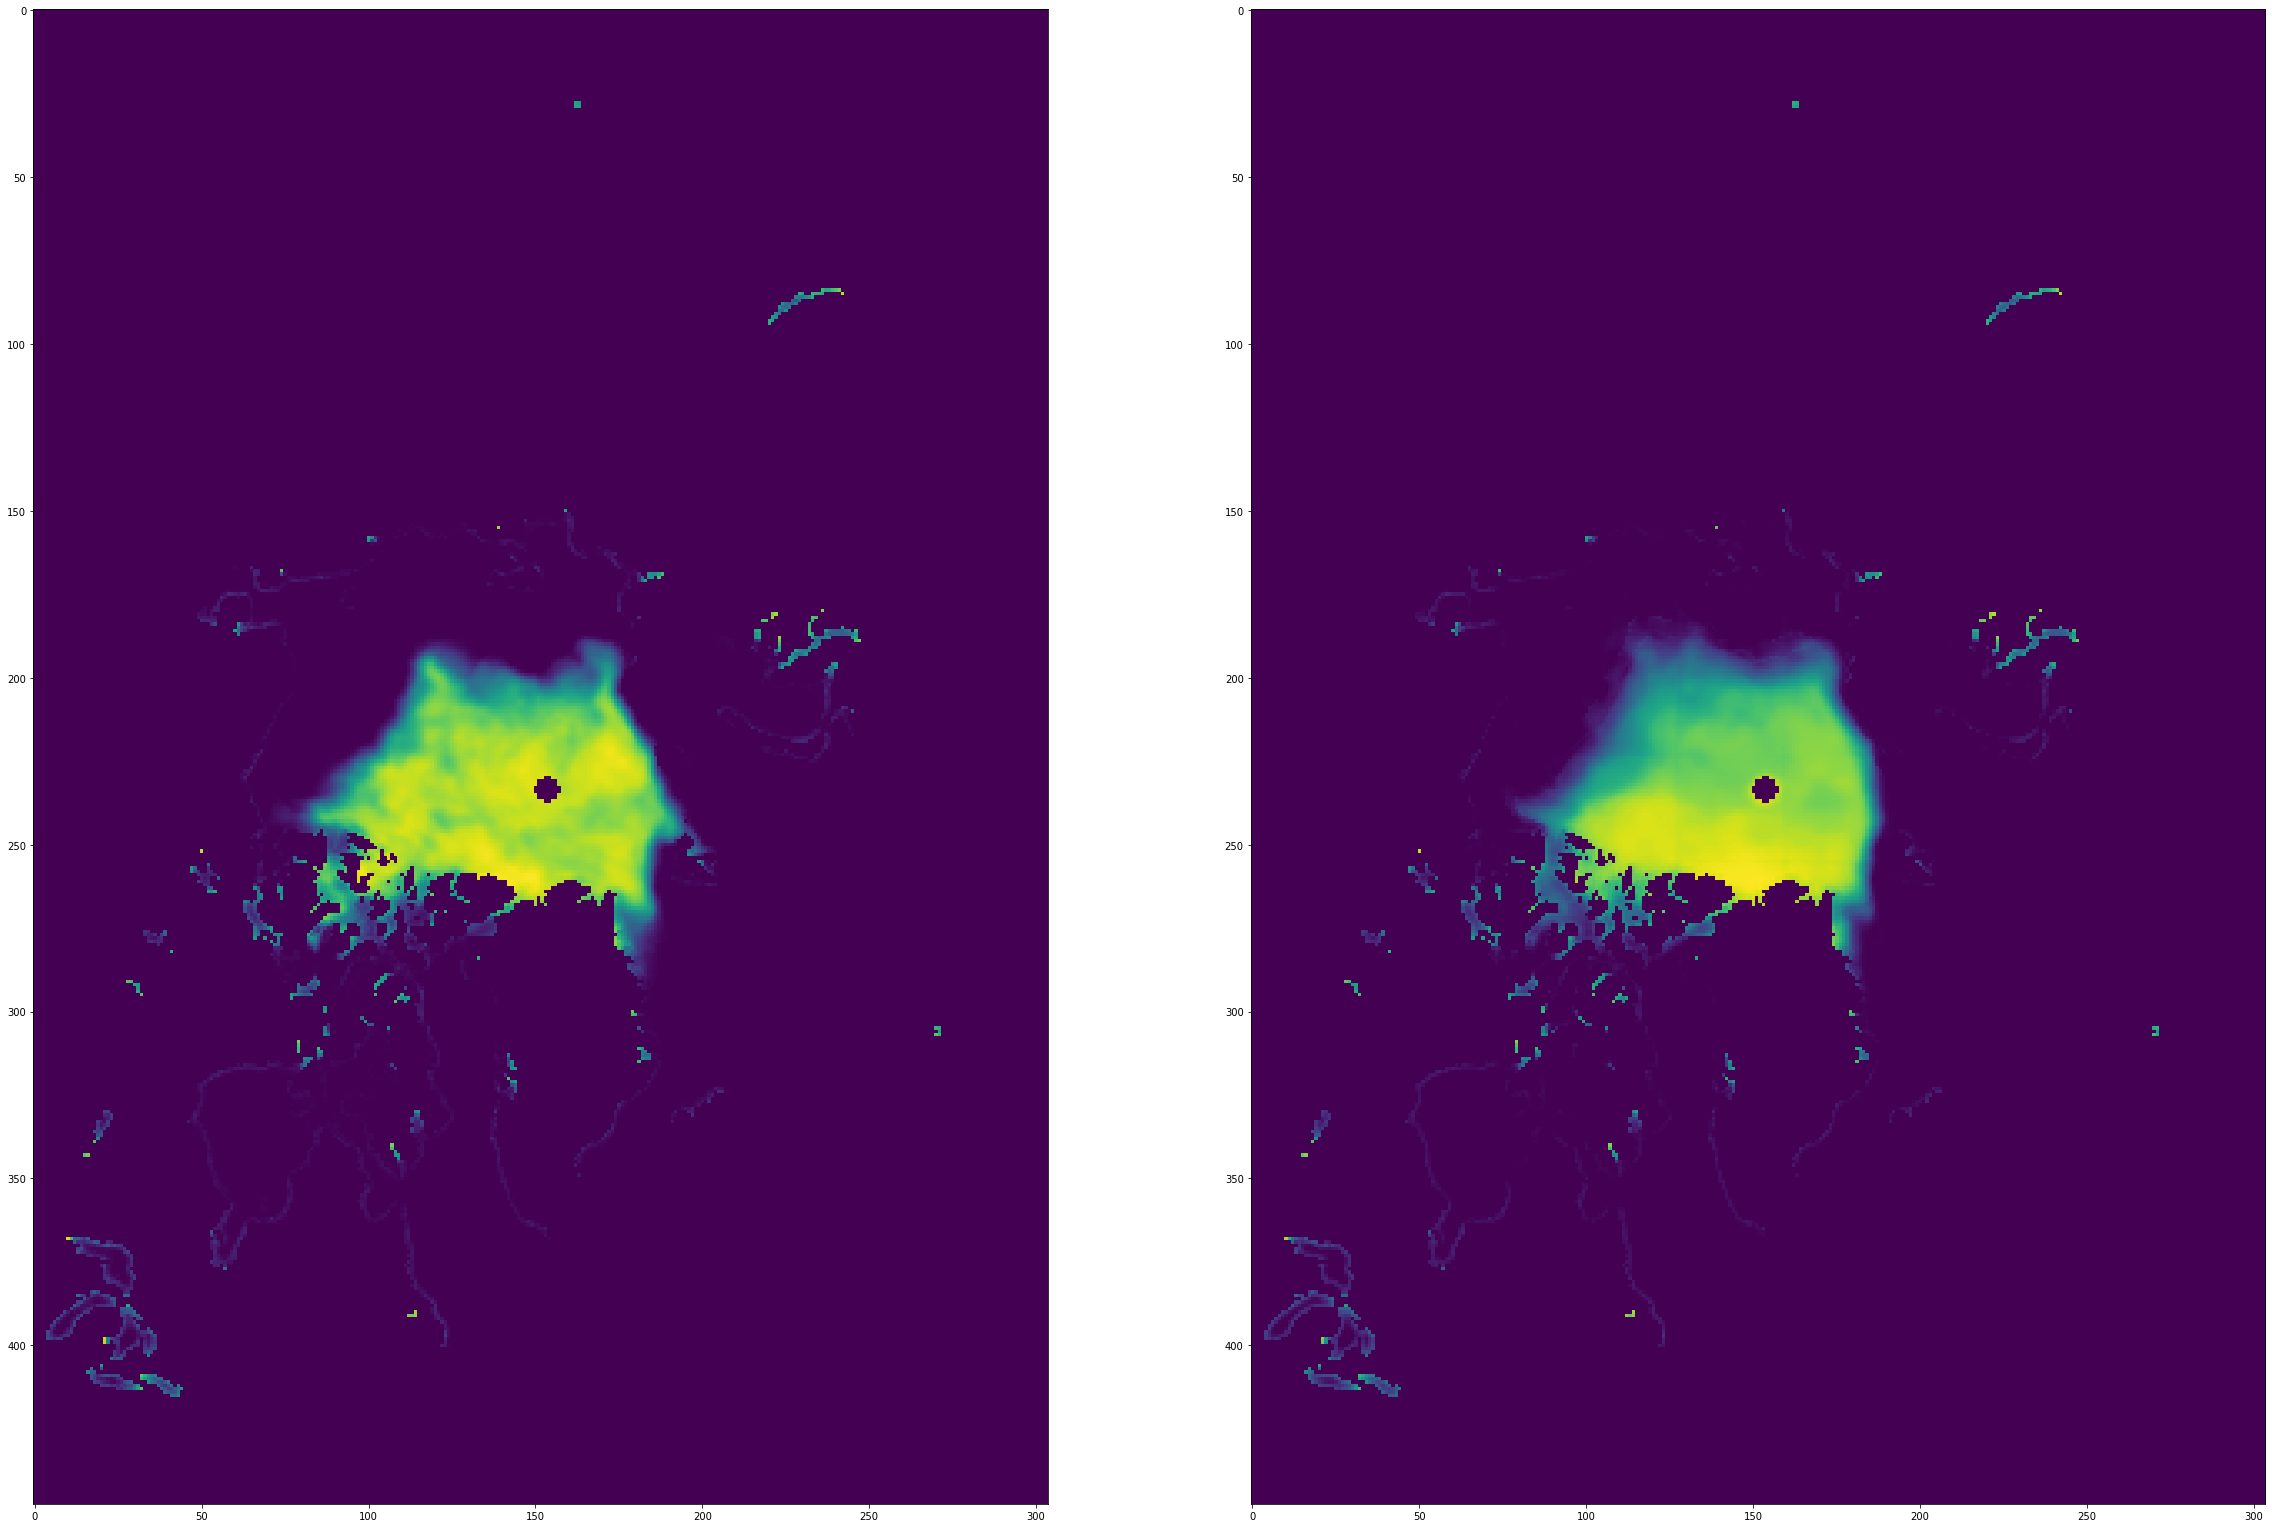

10 month 



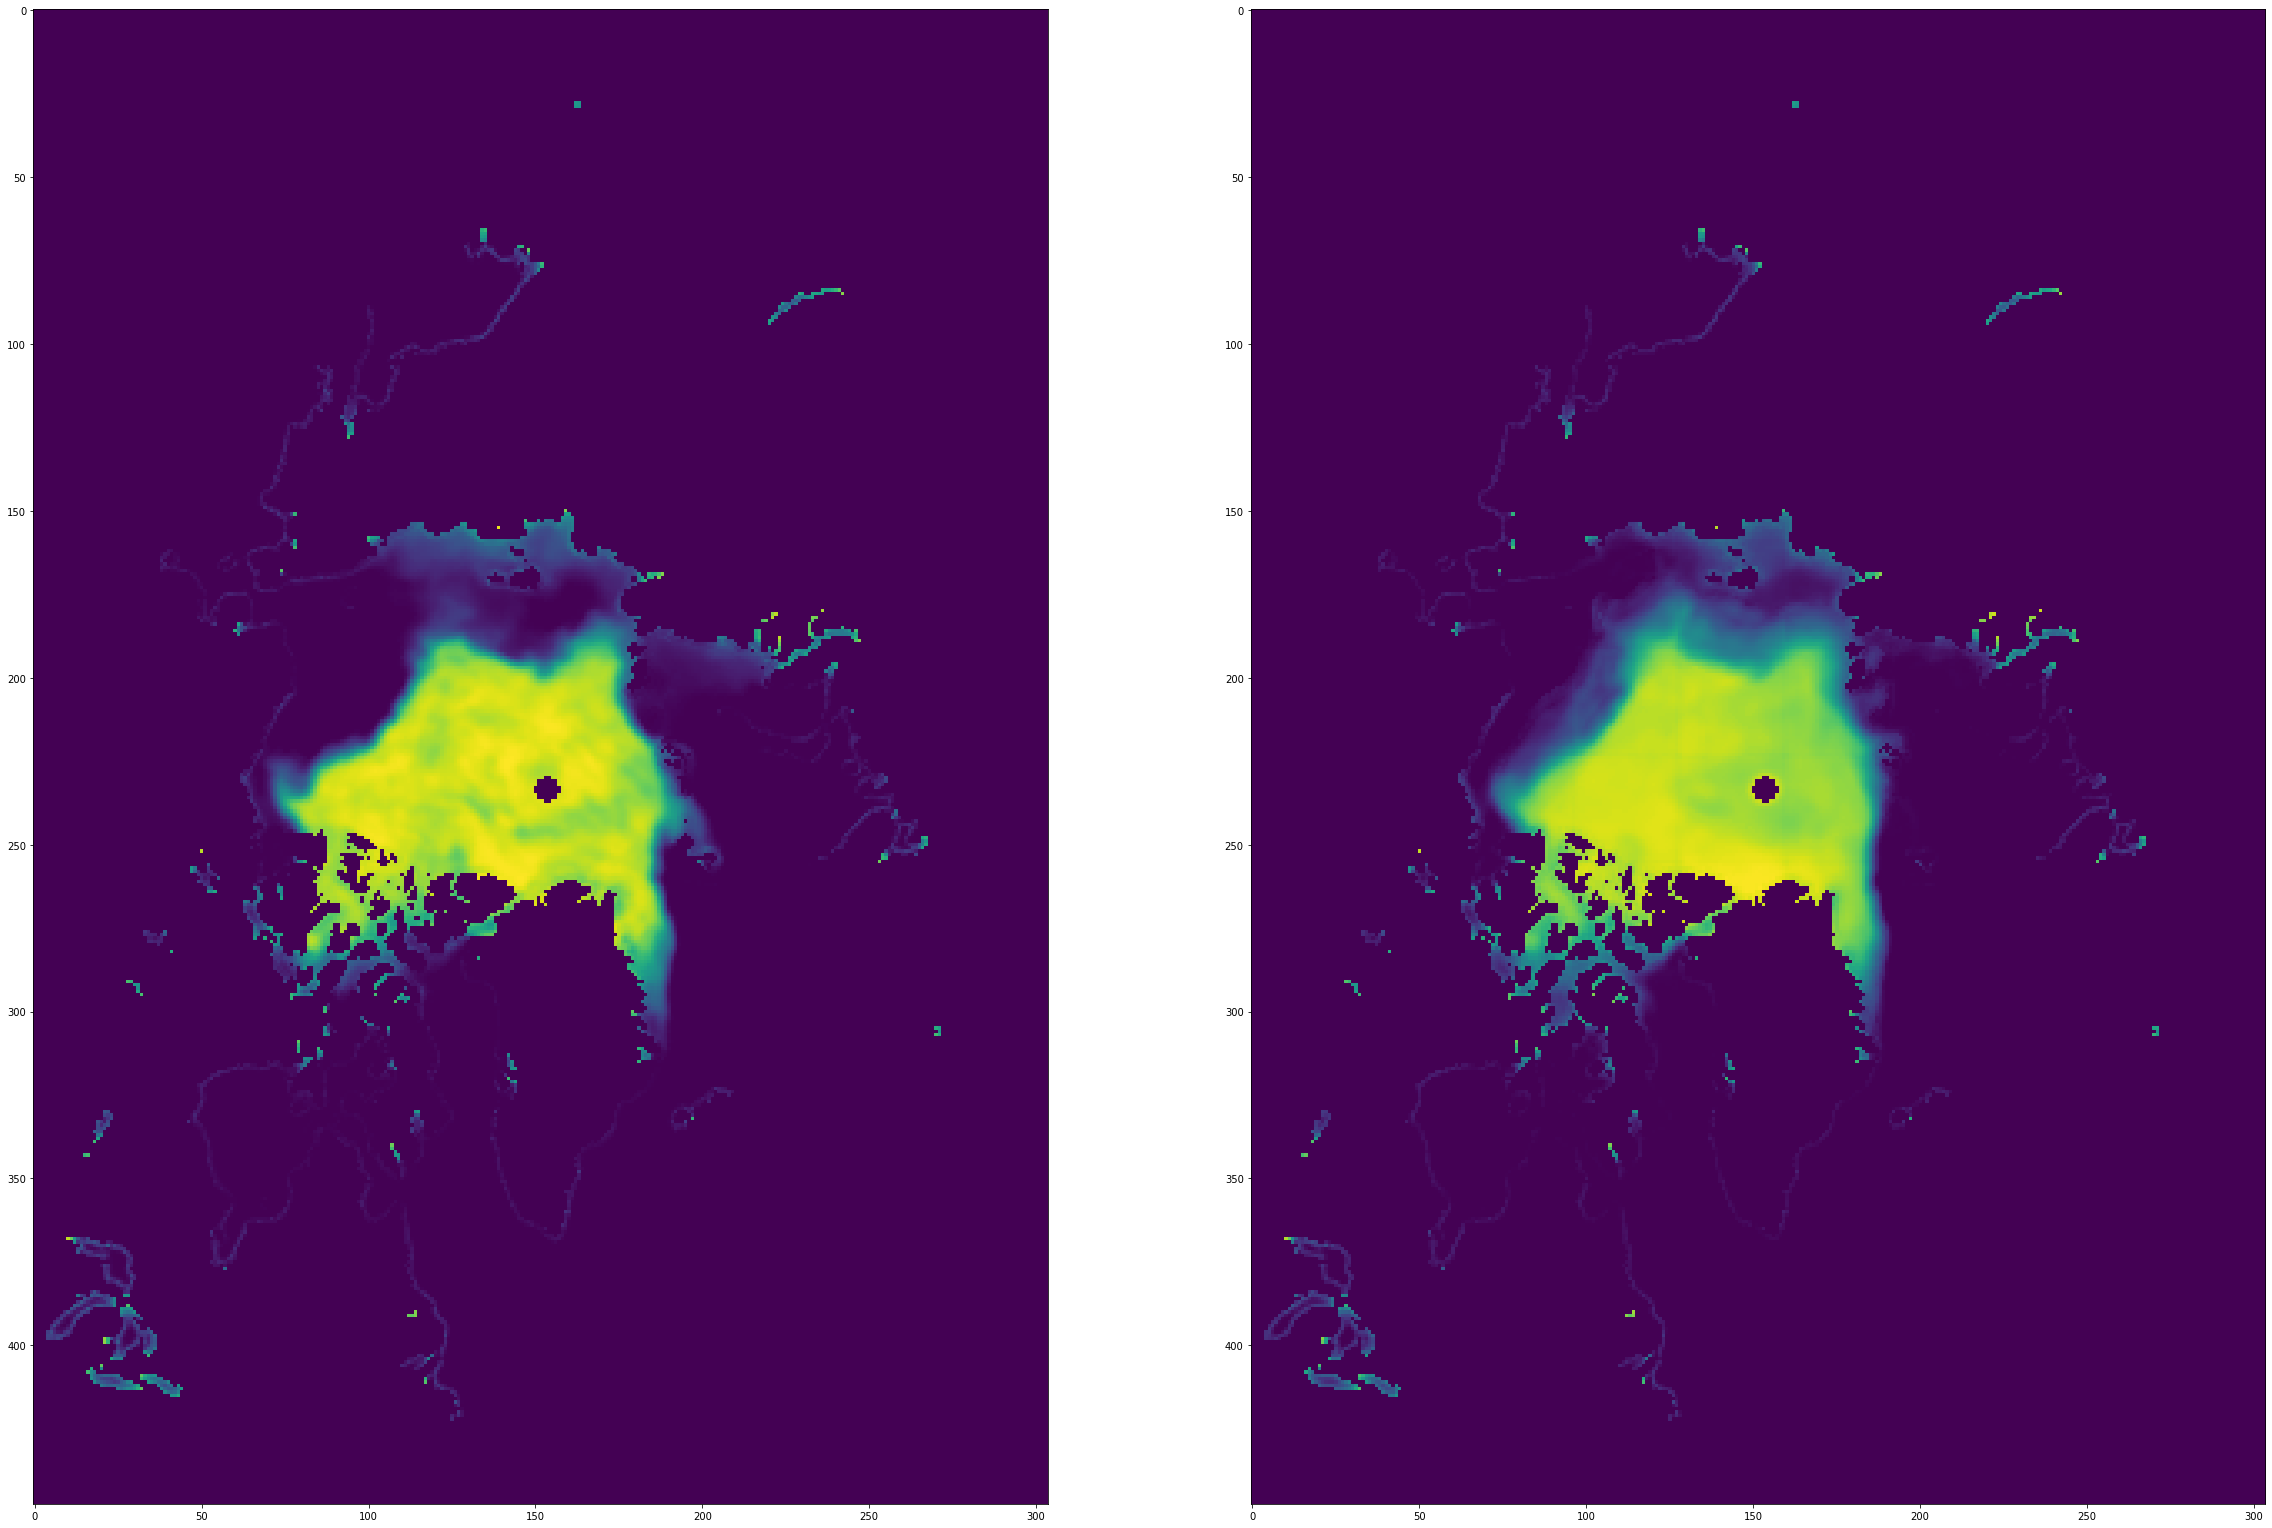

11 month 



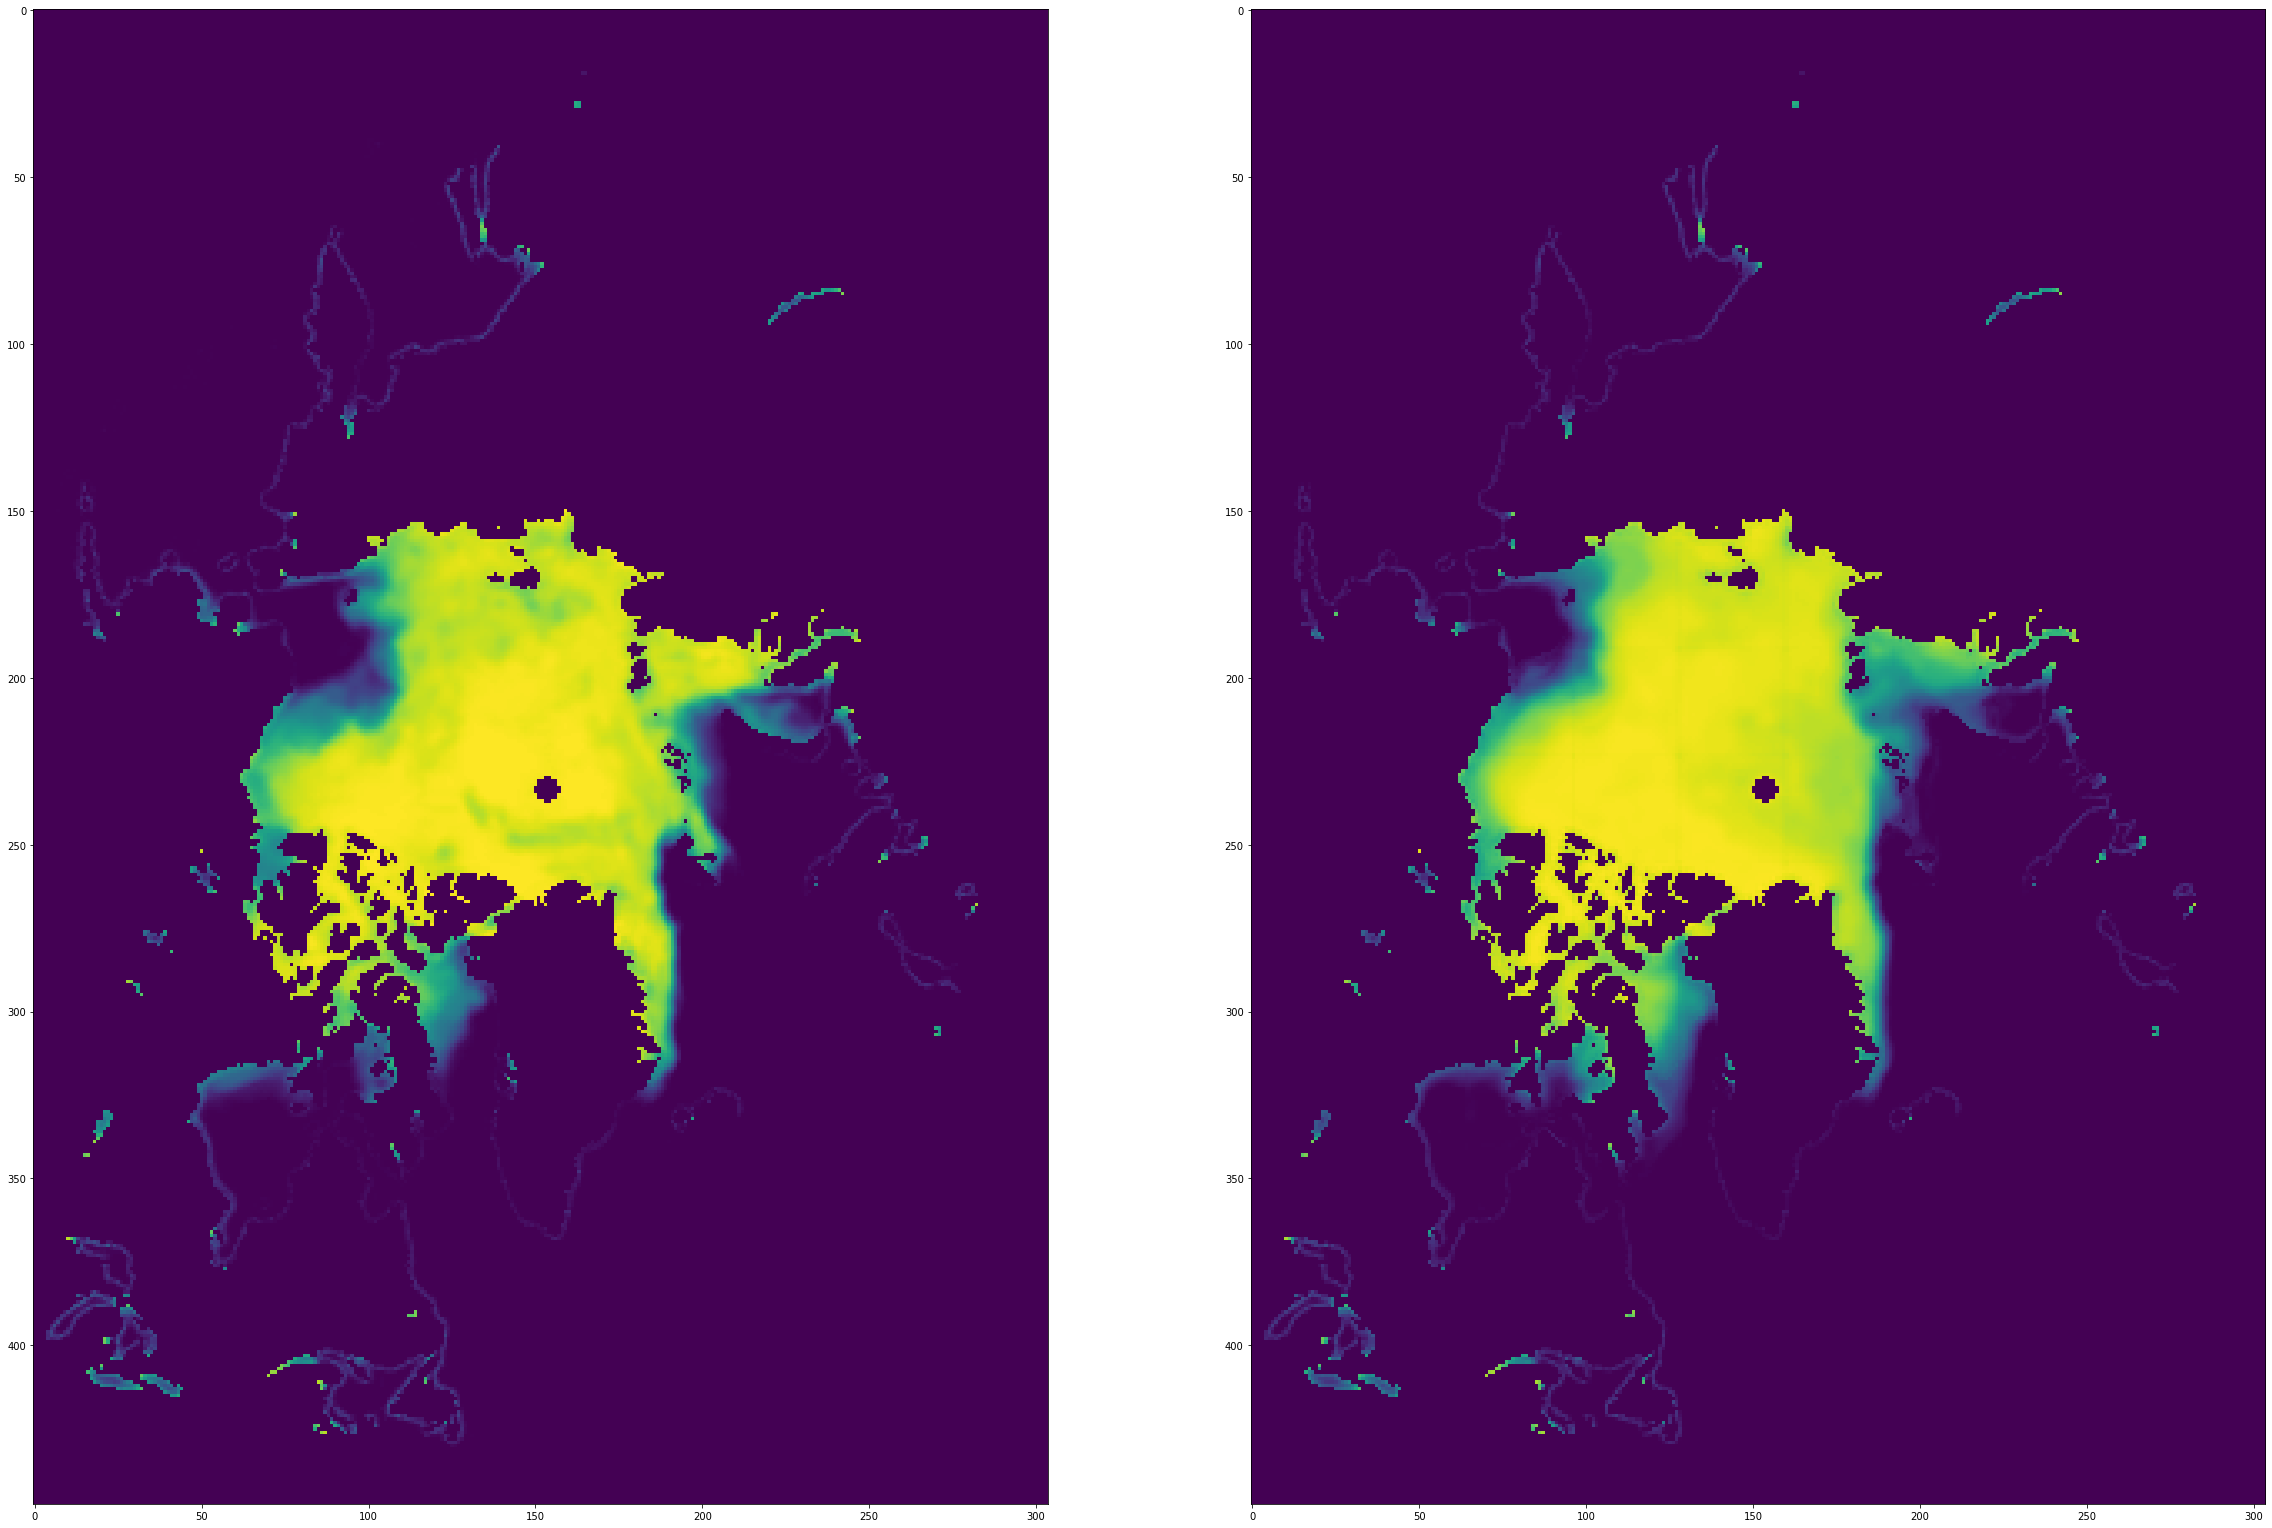

12 month 



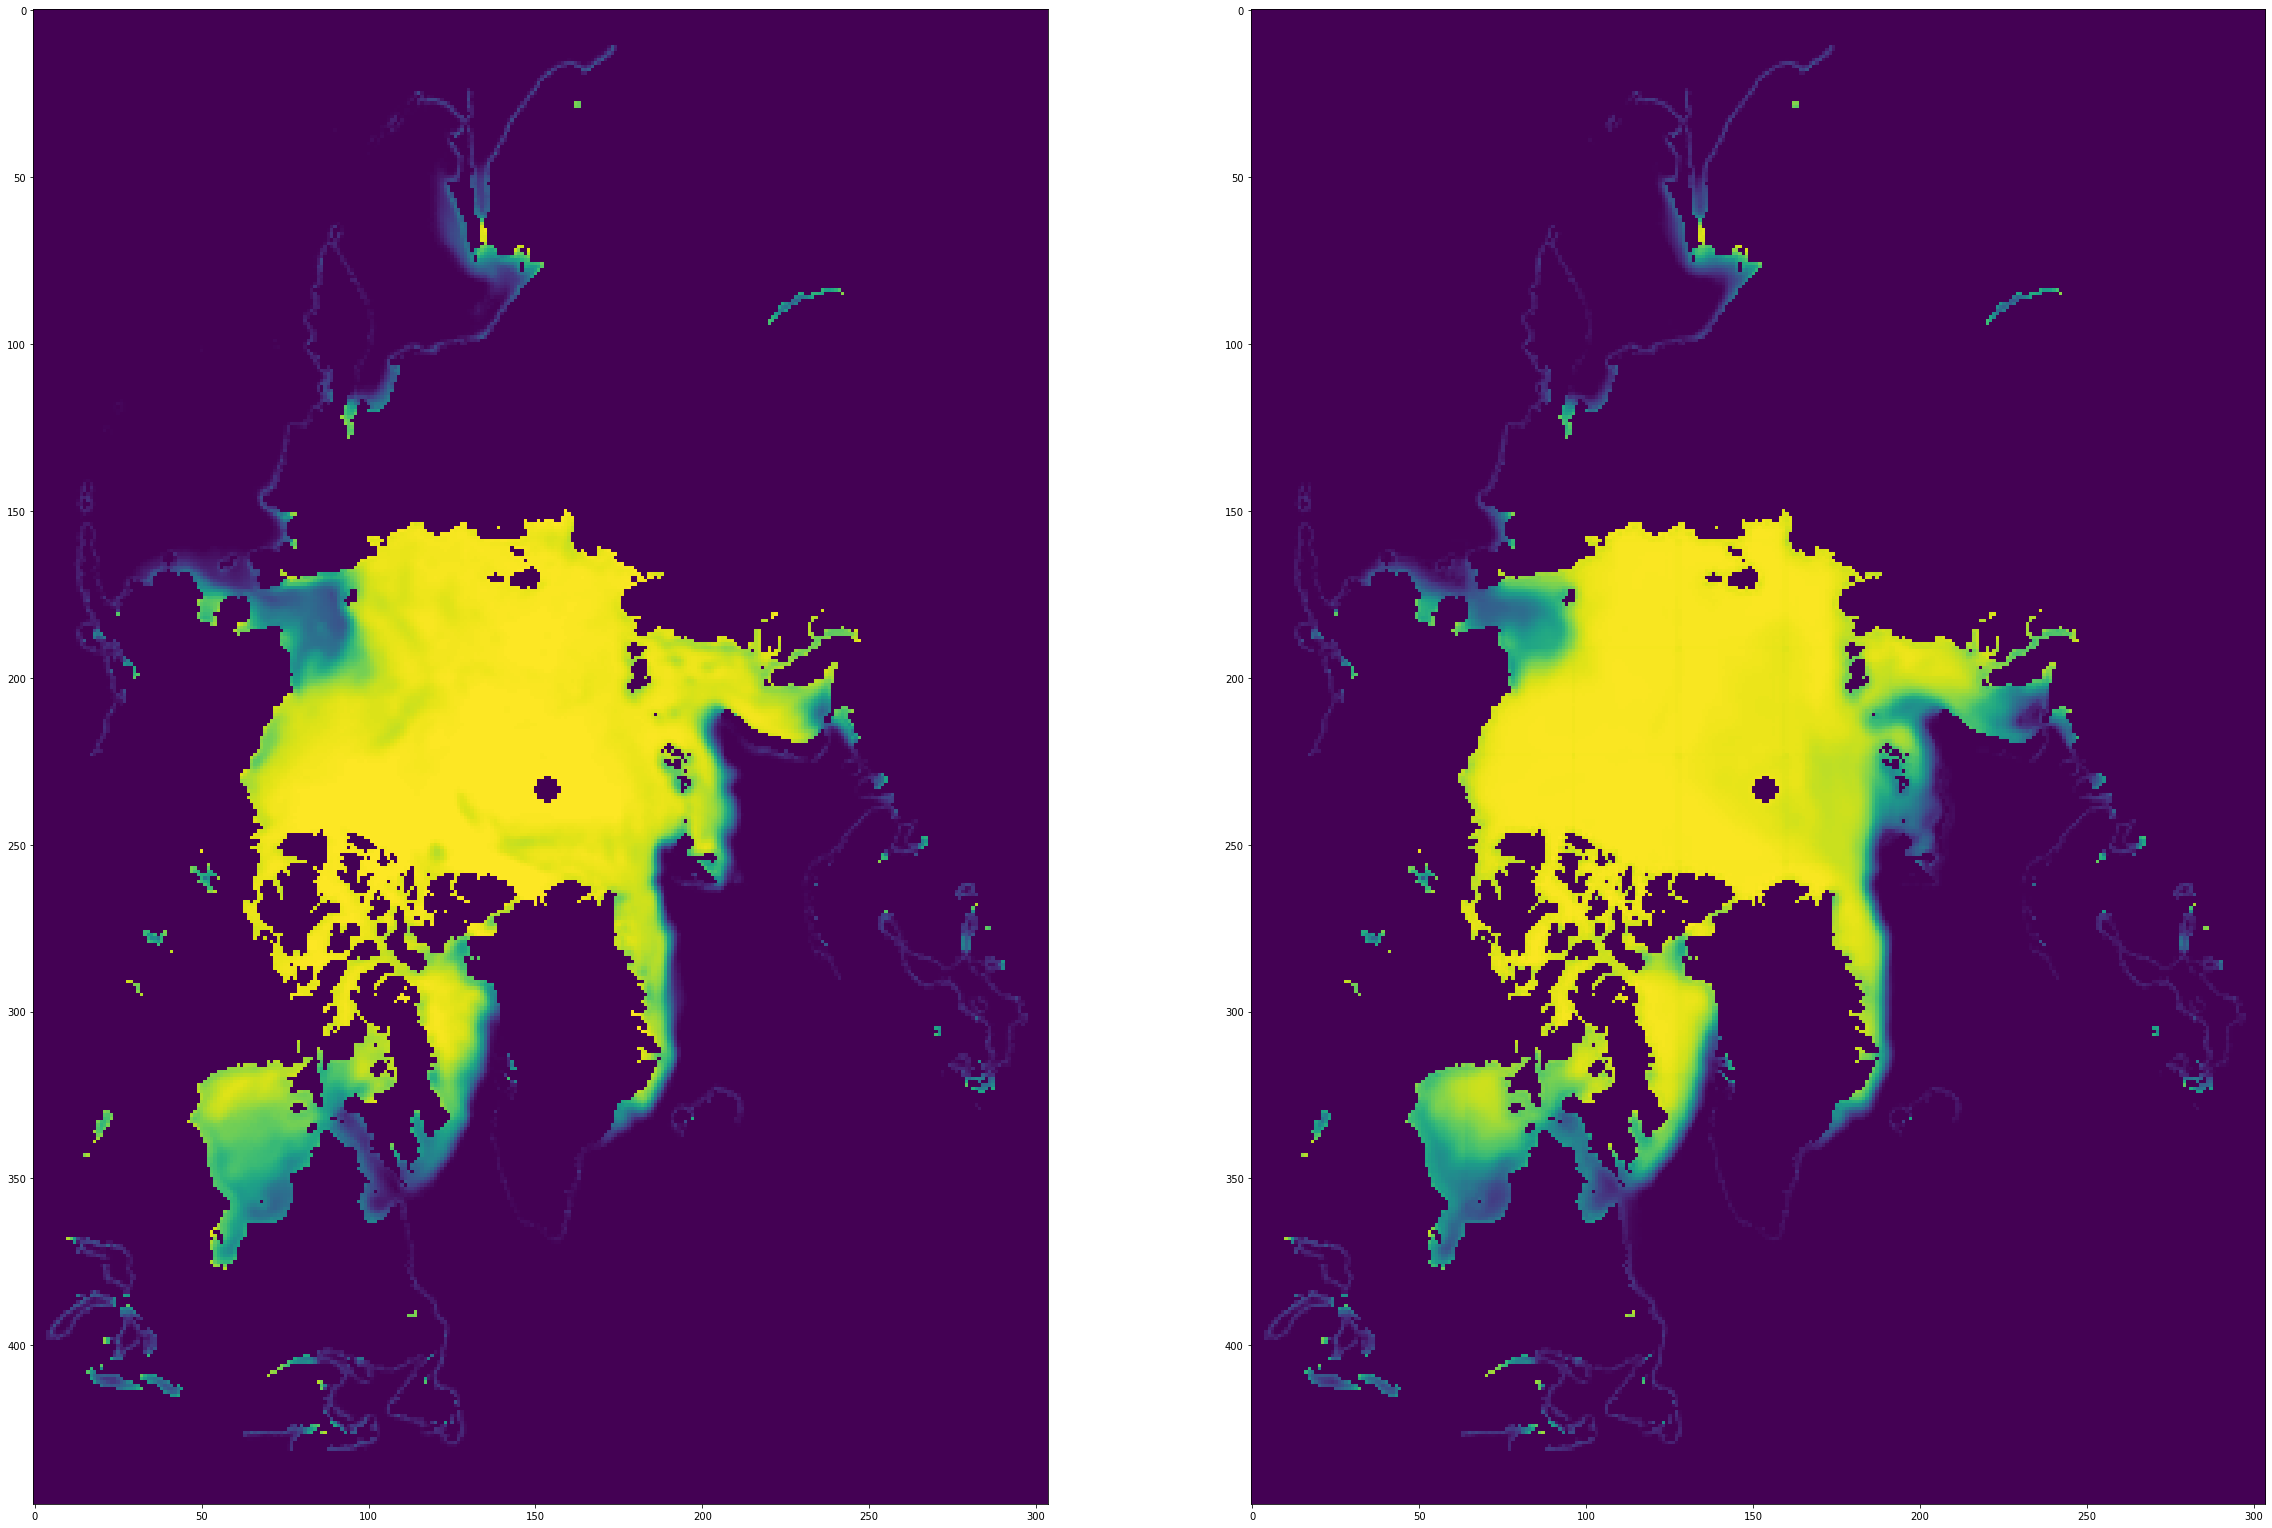

In [22]:
results_final = results_final.astype(int)
results_final = results_final.reshape(24, 448, 304)

for m in range(12):
    print(m+1, 'month', '\n')    
    fig = plt.figure(figsize =  (40, 50))
    fig.add_subplot(1, 2, 1)
    plt.imshow(results_final[m])
    fig.add_subplot(1, 2, 2)     
    plt.imshow(results_final[m+12])
    plt.show()